### RNN with LSTM cell
* Architecture reference from https://arxiv.org/pdf/2004.00959.pdf
* Country-specific network (with only non-zero data)

(Something new: Maybe decrease number of classifier by grouping countries in the same GDP/ bracket)

#### Data partition
* Test data is the last 10 days
* Validation 10 days before last 10 days
* Data logged
* Noise added is smaller compared to Offline-3
* Also optimize momentum of SGD
* Some countries kicked out for having too many zeros
* Version 5 learns the difference! Instead of the data itself
* Version 6 is the same as 5 but lite (in case it doesn't finish training)
* Version 7 is copy of 6 (but with logged data (after clear 0)
* As well, a ReLu is added 

#### What to change between different versions
* offlinex directory name (network output)
* graph directory
* output json file
* line by line progress track country file

* Graph directory in dir6 not 7

In [2]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import seaborn as sns
import matplotlib.pyplot as plt
#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()

In [4]:
countries
df_csse.shape

(172, 86)

#### What if use grouping from k-means? or hierarchical clustering to decide which countries are in the same bracket


In [5]:
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [6]:
def find_zero(lst):
    numzero = 0
    for i in lst:
        if i ==0:
            numzero += 1
    return(numzero)

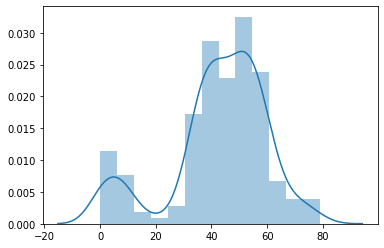

In [7]:
# graph number of days zero
cutoff = 25 # at most = 0
lstzero = []
skip_countries = []
for i in range(len(countries)):
    numz = find_zero(casesA[i,:].tolist())
    lstzero.append(numz)
    if numz > cutoff:
        skip_countries.append(i)

sns.distplot(np.array(lstzero));

In [8]:
len(skip_countries)

149

From the distribution, 30 seems a reasonable cutoff (most countries still present)

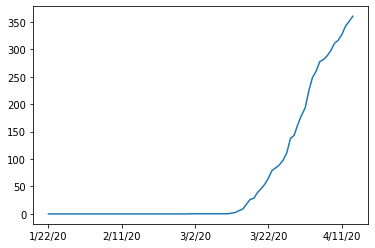

In [9]:
# plot 
#epoch = np.linspace(1, len(trainErr), len(trainErr))

cases.loc[50,:].plot.line()


In [10]:
case_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.52296317e-01, 2.52296317e-01, 2.52296317e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.04858300e+01, 4.95951417e+01, 5.06072874e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.20342147e+00, 6.20342147e+00, 8.17723739e+00],
       ...,
       [3.02112385e-03, 3.02112385e-03, 6.04224770e-03, ...,
        7.36435192e+02, 8.32579437e+02, 9.33083164e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91862032e+05, 1.91862032e+05, 1.91862032e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.39667807e+03, 4.39667807e+03, 4.39667807e+03]])

In [11]:
# log transform
case_test_log = np.log(case_test)
case_validation_log = np.log(case_validation)
case_train_log = np.log(case_train)
case_train_log

/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


array([[       -inf,        -inf,        -inf, ..., -1.37715102,
        -1.37715102, -1.37715102],
       [       -inf,        -inf,        -inf, ...,  3.70095204,
         3.90389288,  3.92409559],
       [       -inf,        -inf,        -inf, ...,  1.82510099,
         1.82510099,  2.10135437],
       ...,
       [-5.80212638, -5.80212638, -5.1089792 , ...,  6.60182124,
         6.72452864,  6.83849433],
       [       -inf,        -inf,        -inf, ..., 12.16453181,
        12.16453181, 12.16453181],
       [       -inf,        -inf,        -inf, ...,  8.38860455,
         8.38860455,  8.38860455]])

### Divide data into training sets
* specify number of days for train and prediction
* offset the dataset so for example: [1,2,3,4] then get [1,2],[2,3] which predicts 3 and 4 respectively

In [12]:
# test 
np.array(case_train[3,:])
#total_days-pred_days-t_days
case_train[3,5:8]

array([0., 0., 0.])

In [13]:
def clear_zero(nparray):
    # return the np array that contains only 1 0:
    lst = nparray.tolist()
    #print(len(lst))
    ind = 0
    splitInd = 0
    while(lst[ind]==0):
        splitInd += 1
        ind += 1
    #print(splitInd)
    return(np.array(lst[splitInd:]))

In [14]:
clear_zero(case_train[169,:]).shape[0]

74

In [15]:
def get_diff(arr):
    lst = arr.tolist()
    difflst = []
    for i in range(len(lst)):
        if i == 0:
            continue
        # start
        difflst.append(lst[i]-lst[i-1])
    return(np.array(difflst))

In [34]:
t_days = 25 # number of days used to test 
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []

diffData = []
for i in range(len(countries)):
    print(countries[i] + " "+ str(i))
    
    if i in skip_countries:
        country_train_X.append(0)
        country_train_Y.append(0)

        country_valid_X.append(0)
        country_valid_Y.append(0)

        country_test_X.append(0)
        country_test_Y.append(0)
        diffData.append(0)
        continue # too little data 
        
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    newcase1 = clear_zero(case_train[i,:])
    newcase = np.log(get_diff(newcase1)+1)
    #newcase = get_diff(newcase1)
    total_days = newcase.shape[0]
    diffData.append(newcase)
    print(total_days)
    for j in range(total_days-pred_days*2-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        cur_c.append(newcase[j:j+t_days])
        #print(str(j))
        out.append(newcase[j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
    country_train_X.append(cur_c)
    country_train_Y.append(out)
    
    country_valid_X.append(newcase[total_days-t_days-test_d*2:total_days-test_d*2])
    print(newcase[total_days-t_days-test_d*2:total_days-test_d*2].shape)
    country_valid_Y.append(newcase[total_days-test_d*2:total_days-test_d])
    print(newcase[total_days-test_d*2:total_days-test_d].shape)
    
    country_test_X.append(newcase[total_days-test_d-t_days:total_days-test_d])
    country_test_Y.append(newcase[total_days-test_d:])
    
    # the best way to check this
    #testlist = 


Burundi 0
Djibouti 1
Eritrea 2
Ethiopia 3
Kenya 4
Madagascar 5
Malawi 6
Mauritius 7
Mozambique 8
Rwanda 9
Seychelles 10
Somalia 11
South Sudan 12
Uganda 13
Tanzania 14
Zambia 15
Zimbabwe 16
Angola 17
Cameroon 18
Central African Republic 19
Chad 20
Equatorial Guinea 21
Gabon 22
Sao Tome and Principe 23
Botswana 24
Eswatini 25
Namibia 26
South Africa 27
Benin 28
Burkina Faso 29
Cabo Verde 30
Gambia 31
Ghana 32
Guinea 33
Guinea-Bissau 34
Liberia 35
Mali 36
Mauritania 37
Niger 38
Nigeria 39
Senegal 40
Sierra Leone 41
Togo 42
Algeria 43
Egypt 44
50
(25,)
(5,)
Libya 45
Morocco 46
Sudan 47
Tunisia 48
Western Sahara 49
Armenia 50
Azerbaijan 51
Bahrain 52
Cyprus 53
Georgia 54
Iraq 55
Israel 56
Jordan 57
Kuwait 58
Lebanon 59
Oman 60
Qatar 61
Saudi Arabia 62
Syria 63
Turkey 64
United Arab Emirates 65
66
(25,)
(5,)
Yemen 66
Kazakhstan 67
Kyrgyzstan 68
Uzbekistan 69
Afghanistan 70
Bangladesh 71
Bhutan 72
India 73
65
(25,)
(5,)
Iran 74
Maldives 75
Nepal 76
70
(25,)
(5,)
Pakistan 77
Sri Lanka 78
68
(

In [29]:
country_train_X[88][0].shape
country_train_X[81][0].shape

(25,)

In [30]:

diffData[81]

array([0.        , 0.        , 0.        , 0.01568949, 0.        ,
       0.02344288, 0.        , 0.03113662, 0.03113662, 0.03877162,
       0.        , 0.        , 0.01568949, 0.        , 0.        ,
       0.02344288, 0.        , 0.00787552, 0.        , 0.        ,
       0.01568949, 0.        , 0.00787552, 0.10498373, 0.11912059,
       0.05386893, 0.06133296, 0.07609594, 0.07609594, 0.0833965 ,
       0.12611478, 0.18037403, 0.09064414, 0.0833965 , 0.13995808,
       0.18037403, 0.10498373, 0.09783964, 0.11207714, 0.13306038,
       0.13995808, 0.26271126, 0.20643813, 0.38824881, 0.2807866 ,
       0.2807866 , 0.06874169, 0.44048642, 0.37746566, 0.        ,
       0.39891691, 0.4506143 , 0.41991766, 0.        , 0.26877275,
       0.0833965 , 0.24430317, 0.26877275, 0.29854102, 0.55573473,
       0.193491  , 0.41470867, 0.642566  , 0.49013021, 0.49496168,
       1.02208653, 0.86197961, 0.        , 0.52347037, 1.02208653,
       1.25458852, 0.67529191, 1.6345695 ])

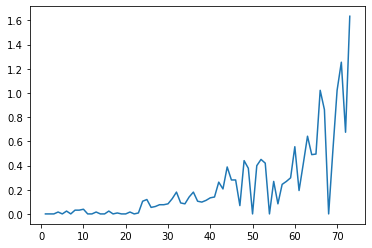

In [35]:
import matplotlib.pyplot as plt
x = np.linspace(1, len(diffData[81].tolist()), len(diffData[81].tolist()))
plt.plot(x, diffData[81])
plt.show()

In [36]:
len(country_train_X)

172

In [37]:
# check dimension

#len(country_test_X[33])
total_days-pred_days-test_d
pred_days
test_d
total_days
case_train[0,29:64].shape
case_train[0,0:40].shape

(40,)

#### Data size & index
The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. We haven’t discussed mini-batching, so lets just ignore that and assume we will always have just 1 dimension on the second axis.

In [38]:
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Optimized hyperparameters
|Parameter |Description|Distribution/Selection|Values|
|----------|------------|----------------------|---------|
|Learning rate|Minimum learning rate| Discrete|1e-1 to 1e-7|
|Hidden layers|Number of layers in the network|Discrete numeric|1 to 5|
|Hidden state|Number of memory cell in each layer|Discrete numeric|1 to 200|
|Momentum|SGD optimizer parameter for overshoot direction|Discrete numeric|0.1 to 0.9|

In [39]:
# Parameter
num_epochs = 50 # max
batch_size = 1
# Loss and optimizer
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate = 0.01 # to be changed/optimized 
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
output_directory = "mock/"
output_file_path = "mock/Train"
input_dim = t_days
hidden_dim = 2
hidden_state = 100
output_dim= pred_days
num_layers=2
lstm_input_size = t_days
#model = LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model_name = "mock"
output_file_path = "./outputs/" + model_name + "/training/"
directory = os.path.dirname(output_file_path)
if not os.path.exists(directory):
    print("Creating directory %s" % output_file_path)
    os.makedirs(directory)
else:
     print("Directory %s exists" % output_file_path)


Directory ./outputs/mock/training/ exists


In [40]:
# RNN structure

class RNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, data, last_hidden):
        input = torch.cat((data, last_hidden), 1)
        hidden = self.i2h(input)
        output = self.h2o(hidden)
        return hidden, output
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [41]:
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = F.relu(self.linear(lstm_out[-1].view(self.batch_size, -1)))
        
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

In [49]:
# training function
def train_model(train_loader, test_loader, model, device, criterion, optimizer, num_epochs, output_directory,learning_rate,hidden_dim,num_layers,momentum):
    
    total_step = len(train_loader)
    model.train()
    model.hidden = model.init_hidden() # LSTM hidden reinitialization
    
    #open files to log error
    train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers)+ "_"+ str(momentum) +".txt", "a")
    test_error = open(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) + "_"+ str(momentum)+".txt", "a")

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_valid = float('inf')
    best_epoch = 1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (seqs, labels) in enumerate(train_loader):
            #print(seqs.shape)
            # add gaussian noise to sequence
            noiselevel = torch.max(torch.tensor(country_train_X[2])).item()/1000
            noise = torch.abs(torch.randn(seqs.shape[0],seqs.shape[1],seqs.shape[2],seqs.shape[3])*noiselevel)
            #print(noise.shape)
            seqs += noise # add gaussian noise
            #print(seqs.shape)
            seqs = seqs.to(device)
            labels = labels.to(device)

            # Forward pass
            #seqs = seqs.squeeze()
            #print(seqs.shape)
            #print(model(seqs))
            outputs = model(seqs) # error 
            loss = criterion(outputs.squeeze(), labels.squeeze()) # change input to 
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #save training loss to file
        epoch_loss = running_loss / len(train_loader.dataset)
        print("%s, %s" % (epoch, epoch_loss), file=train_error)
        
        #calculate test loss for epoch
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for i, (seqs, labels) in enumerate(test_loader):
                x = seqs.to(device)
                y = labels.to(device)
                outputs = model(x)
                #print(outputs.shape)
                #print(y.shape)
                loss = criterion(outputs.squeeze(), y.squeeze())
                test_loss += loss.item() 
                
                # for metrics
                #updateYlist(outputs,y)
                

        test_loss = test_loss / len(test_loader.dataset)
        
        #save outputs for epoch
        print("%s, %s" % (epoch, test_loss), file=test_error)
        
        # for each epoch, calculate metrics (f1, pr)
        #calculateMetrics(outputs,y)
        
        if test_loss < best_loss_valid:
            best_loss_valid = test_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print ('Saving the best model weights at Epoch [{}], Best Valid Loss: {:.4f}' 
                       .format(epoch+1, best_loss_valid))

        
    train_error.close()
    test_error.close()

    #model.load_state_dict(best_model_wts)
    print("train error:", epoch_loss)
    return model, best_loss_valid


In [50]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred.squeeze(), y.squeeze())
            test_loss += loss.item() 
            
    return pred,test_loss

In [44]:
#dimension check
a = torch.tensor(country_train_X[81]) #torch.Size([19, 30, 1, 1])
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# #torch.tensor(country_train_Y[0])
# torch.tensor(country_train_X[0])
# a.size(-1)
# torch.tensor(country_test_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# #torch.tensor(country_valid_Y[0]).unsqueeze_(0).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape

In [45]:
import matplotlib.pyplot as plt

graph_dir = "./graph_Offline7/"
directory = os.path.dirname(graph_dir)
if not os.path.exists(directory):
    print("Creating directory %s" % graph_dir)
    os.makedirs(directory)
else:
     print("Directory %s exists" % graph_dir)

def graph_country(index,prediction,outdir):
    
    # produce projection closeup & general graph
    # with label & title
    #print(prediction)
    data = diffData[index]
    newpred = prediction#.tolist()
    days = data.shape[0]
    
    # general trend
    x = np.linspace(1, len(data.tolist()), len(data.tolist()))
    y_real = data
    y_pred = data[:days-test_d].tolist()
    #print(len(y_pred))
    y_pred.extend(newpred)
    #print(len(y_pred))
    #print(len(y_real))
    y_pred = np.array(y_pred)
    plt.figure(index)
    plt.plot(x, y_real, label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" trend")
    plt.savefig(outdir+countries[i]+"_general")
    plt.show()
    # specific plot
    
    x = np.linspace(1, len(data[days-test_d:].tolist()), len(data[days-test_d:].tolist()))
    y_real = data[days-test_d:]
    y_pred = newpred
    plt.figure(index*2)
    plt.plot(x, y_real, label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" 5 days prediction")
    plt.savefig(outdir+countries[i]+"_specific")    
    plt.show()

Creating directory ./graph_Offline6/


In [51]:
# test if it runs
learning_rate = 0.01 # to be changed/optimized 
num_layers = 2
hidden_dim = 100
momentum = 0.1

net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
print(net)
model = net.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[81]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[81]).unsqueeze_(1).float())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# load validation
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[81]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[81]).unsqueeze_(0).float())
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

# load test
test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[81]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[81]).unsqueeze_(0).float())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# mock trial
err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim, num_layers,momentum)



LSTM(
  (lstm): LSTM(25, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=5, bias=True)
)
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3230
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3134
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3050
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3029
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3008
train error: 0.06188992883912042


tensor([[0.5235, 1.0221, 1.2546, 0.6753, 1.6346]], device='cuda:0')
tensor([0.2180, 0.2264, 0.0000, 0.2689, 0.0000], device='cuda:0')


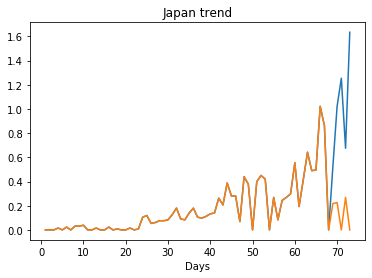

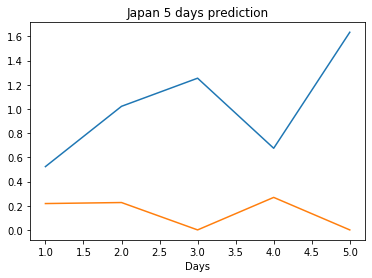

In [52]:
pred, loss = test_model(test_loader,model,device,criterion)
graph_country(81,pred.tolist(),graph_dir)

In [48]:
diffData[81].shape

(73,)

Creating directory ./offline7/Egypt/training/
Egypt
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0558
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0491
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0490
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0489
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0489
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0488
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0488
train error: 0.04869038574397564
0.048814207315444946
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0831
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0830
Savin

train error: 0.07036462798714638
0.08791132271289825
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0537
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0464
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0438
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0426
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0419
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0415
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0414
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0413
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0413
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0412
train error: 0.04435307206586003
0.041242025792598724
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0544
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0494
Savin

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0526
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0524
train error: 0.050266614044085146
0.05236154422163963
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1095
train error: 0.08351000025868416
0.10951926559209824
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0950
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0940
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0939
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0939
train error: 0.06919690902965764
0.09389491379261017
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0584
train error: 0.06149486353000005
0.058373164385557175
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0566
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0541
Saving the best model weights at Epo

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0488
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0487
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0482
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0478
train error: 0.04518329029281934
0.047770969569683075
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0176
train error: 0.03589189654837052
0.017628341913223267
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0776
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0747
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0738
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0737
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0732
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0731
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0731
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0730
Savin

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0517
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0510
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0502
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0490
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0485
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0480
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0476
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0472
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0465
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0459
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0456
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0554
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0554
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0552
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0551
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0551
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0550
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0550
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0549
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0549
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0548
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0548
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0548
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0953
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0857
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0748
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0656
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0483
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0443
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0416
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0390
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0372
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0424
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0421
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0420
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0419
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0416
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0416
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0415
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0415
Saving the best model weights at E

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0797
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0782
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0757
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0747
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0737
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0729
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0721
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0714
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0708
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0702
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0697
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0692
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0688
Saving the best model weights at Epoch

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0645
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0643
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0642
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0640
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0639
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0638
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0637
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0636
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0635
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0634
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0634
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0633
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0632
Saving the best model weights at E

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0152
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0101
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0097
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0421
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0421
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0420
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0416
train error: 0.04393334633981188
0.04156278446316719
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0689
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0665
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0644
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0625
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0607
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0592
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0578
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0565
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0554
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0534
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0526
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0512
Saving the best model weights at Epoch

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0562
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0561
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0560
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0558
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0556
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0555
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0554
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0553
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0552
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0551
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0551
Saving the best model weights at E

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0696
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0693
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0689
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0687
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0685
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0682
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0681
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0680
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0680
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0679
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0678
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0678
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0678
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0802
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0680
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0641
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0621
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0616
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0616
train error: 0.05715234999855359
0.061584748327732086
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1058
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1034
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1014
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0995
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0964
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0951
Saving the best model weights at Epoch [8], Best Valid Loss: 0

Saving the best model weights at Epoch [18], Best Valid Loss: 0.0525
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0523
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0520
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0514
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0512
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0511
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0509
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0508
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0507
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0506
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0504
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0236
train error: 0.034353193795929354
0.023600352928042412
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0885
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0855
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0832
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0814
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0799
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0788
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0779
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0770
Saving the best model weights at Epoch [9], Best Valid L

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0492
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0491
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0491
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0491
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0491
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0489
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0489
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0489
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0729
train error: 0.055559175989280146
0.07292523980140686
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0044
train error: 0.019977704032013814
0.004413784947246313
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0453
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0452
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0450
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0448
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0446
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0445
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0443
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0440
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0438
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0437
Savi

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0623
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0616
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0610
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0604
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0593
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0587
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0581
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0576
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0570
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0565
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0559
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0554
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0549
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0438
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0435
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0434
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0434
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0433
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0433
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0433
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0432
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0432
train error: 0.04561969731003046
0.043169595301151276
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [2], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0615
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0601
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0587
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0575
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0566
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0550
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0541
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0535
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0529
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0524
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0519
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0513
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0510
Saving the best model weights at Epoch

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0889
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0886
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0882
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0878
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0863
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0856
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0849
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0836
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0829
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0823
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0811
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0454
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0453
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0450
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0449
train error: 0.04138871065030495
0.04488212987780571
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0858
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0850
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0846
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0843
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0836
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0832
Saving the best model weights at Epoch [9], Best Valid Los

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0638
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0634
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0630
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0626
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0622
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0618
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0614
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0610
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0606
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0602
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0598
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0594
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0591
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0587
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0082
Saving the best model weights at E

train error: 0.08351000025868416
0.10951926559209824
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0894
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0889
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0884
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0879
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0874
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0865
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0860
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0856
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0851
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0847
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0843
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [14], Best Valid Los

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0595
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0594
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0593
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0592
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0591
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0590
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0589
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0588
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0587
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0586
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0585
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0583
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0582
Saving the best model weights at E

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0626
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0624
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0622
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0621
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0619
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0618
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0616
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0614
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0613
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0611
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0610
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0608
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0607
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0605
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0500
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0494
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0492
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0489
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0487
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0486
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0485
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0484
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0482
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0481
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0481
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0479
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0913
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0898
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0885
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0873
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0860
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0850
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0840
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0833
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0825
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0820
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0813
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0808
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0803
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0798
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0768
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0763
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0758
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0753
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0748
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0743
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0739
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0734
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0730
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0726
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0721
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0717
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0713
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0709
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0502
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0499
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0497
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0495
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0491
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0489
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0486
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0484
train error: 0.04219063228617112
0.04843255877494812
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0734
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0728
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0722
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0716
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0640
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0638
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0636
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0634
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0630
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0626
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0624
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0622
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0620
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0618
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0616
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0614
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0633
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0631
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0630
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0629
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0628
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0627
train error: 0.05530864018946886
0.06273908913135529
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0696
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0646
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0630
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0614
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0600
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0589
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0578
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0567
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0558
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0551
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0543
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0537
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0531
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0526
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0521
Saving the best model weights at Epoc

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0726
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0720
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0715
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0710
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0705
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0700
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0695
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0691
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0686
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0681
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0677
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0673
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0668
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0664
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0748
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0747
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0747
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0746
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0746
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0746
train error: 0.059044627286493775
0.07455284893512726
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0647
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0644
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0641
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0638
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0635
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0631
Saving the best model weights at Epoch [8], Best Valid L

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0623
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0622
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0620
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0619
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0618
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0617
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0615
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0614
train error: 0.050029073779781656
0.06140800192952156
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0802
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0789
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0776
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0762
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0751
Saving the best model weights at Epoch [6], Best Valid

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0872
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0868
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0865
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0861
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0858
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0855
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0851
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0848
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0845
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0836
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0833
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0830
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0718
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0713
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0708
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0704
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0699
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0694
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0690
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0685
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0680
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0676
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0672
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0667
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0663
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0659
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0687
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0982
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0982
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0980
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0980
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0980
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0657
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0656
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0654
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0653
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0652
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0650
train error: 0.055630947649478915
0.06498581171035767
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1074
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1073
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1073
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1073
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1072
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1072
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1071
Saving the best model weights at Epoch [8], Best Valid L

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0903
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0899
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0896
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0885
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0881
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0878
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0874
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0871
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0867
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0864
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0861
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0857
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.1063
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1061
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1061
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1061
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1060
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1060
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1060
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1060
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1059
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1059
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1059
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0844
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0844
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0844
train error: 0.0667130426193277
0.08436919748783112
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0907
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0906
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0905
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0904
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0903
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0902
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0901
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0900
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0899
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0899
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0898
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0897
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0896
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0895
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0980
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0978
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0978
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0977
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0976
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0976
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0975
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0975
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0974
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0973
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0973
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0972
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0953
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0953
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0952
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0952
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0952
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0952
train error: 0.07389488983899355
0.09516756236553192
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0943
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0941
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0940
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0939
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0938
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0937
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0877
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0874
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0939
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0939
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0939
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0938
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0938
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0937
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0937
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0935
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0935
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0934
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0934
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0351
train error: 0.03249776692440112
0.035123445093631744
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0982
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0978
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0973
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0968
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0963
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0954
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0949
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0944
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0940
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0935
Saving the best model weights at Epoch [13], Best Valid Lo

Saving the best model weights at Epoch [18], Best Valid Loss: 0.0760
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0757
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0754
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0751
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0748
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0745
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0742
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0739
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0737
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0734
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0731
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0728
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0726
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0723
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.1011
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1011
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1011
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1011
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1010
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1010
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1010
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1010
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1010
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1009
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1009
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1009
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1009
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1009
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0309
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0309
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1006
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1006
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1006
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1005
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1005
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1005
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1004
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1004
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1004
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1004
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1003
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.1008
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1006
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1006
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1005
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1004
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1003
train error: 0.07464781161397696
0.10029971599578857
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0858
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0857
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0857
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0857
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0857
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0856
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [12], Best Valid Loss: 0.1031
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1030
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1029
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1028
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1027
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1025
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1023
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1022
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1021
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1020
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1019
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1018
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1017
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0960
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0957
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0955
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0955
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0954
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0953
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0953
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0952
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0702
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0701
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0701
train error: 0.05771107661227385
0.07010500878095627
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0815
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0815
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0815
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0814
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0944
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0944
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0943
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0943
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0943
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0943
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0943
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0941
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0941
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0840
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0837
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0836
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0834
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0833
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0832
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0830
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0829
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0827
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0826
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0825
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0823
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0822
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0973
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0971
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0968
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0966
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0963
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0953
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0951
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0948
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0946
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0944
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0941
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0935
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0934
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0933
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0933
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0932
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0931
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0930
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0928
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0928
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0927
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0926
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0925
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1015
train error: 0.07750593461096286
0.10149260610342026
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0768
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0768
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0768
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0768
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0768
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0767
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0996
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0996
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0996
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0995
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0995
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0995
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0994
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0994
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0994
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0994
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0992
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0907
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0907
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0907
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0793
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0793
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0793
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0793
train error: 0.062227137076358
0.07933535426855087
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0692
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0692
Saving the best model weights at Epoch [3], Best Valid

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0750
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0750
Saving the best model weights at Epo

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0800
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0800
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0800
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0800
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0800
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0800
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0799
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0799
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0799
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0799
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0799
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0799
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0798
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0798
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0778
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0827
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0827
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0826
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0826
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0825
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0824
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0824
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0823
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0823
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0822
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0822
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0821
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0821
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0820
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0794
train error: 0.06438217125833035
0.07938205450773239
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0433
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0432
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0828
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0827
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0827
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0827
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0826
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0826
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0826
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0825
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0825
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0824
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0824
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0824
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0823
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0823
Saving the best model weights at Epoch

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0876
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0875
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0875
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0917
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0917
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0916
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0916
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0916
train error: 0.07129705225427946
0.09163796156644821
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [9], Best Valid Los

Saving the best model weights at Epoch [13], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1049
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1048
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1048
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1048
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1048
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1048
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.0915
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0915
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0915
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0915
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0915
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0913
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0913
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0913
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0913
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0595
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0594
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0594
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0594
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0594
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0593
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0593
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0593
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0593
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0592
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0592
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0592
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0592
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0591
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1091
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0958
train error: 0.07169479473183553
0

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0854
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0853
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0853
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0853
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0853
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0853
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0853
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0928
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0928
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0928
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0928
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0685
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0685
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0685
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0684
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0684
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0684
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0684
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0684
train error: 0.051437020457039274
0.06841470301151276
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0926
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0926
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0926
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [6], Best Valid

Saving the best model weights at Epoch [12], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1091
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0985
Saving the best model weights at E

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0997
Saving the best model weights at Epoch

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0991
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0842
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0842
train error: 0.06530733893935879
0.08419262617826462
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0942
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [11], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1035
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0769
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0816
train error: 0.06454064523180326
0.0815688818693161
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0961
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0961
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0793
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0793
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0793
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0921
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0921
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0990
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [22], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1007
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1007
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0893
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0893
train error: 0.06810057473679383
0.0892871841788292
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0431
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0431
Saving the best model weights at Epoch [3], Best Vali

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0880
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0880
Saving the best model weights at Epo

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0870
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0936
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0936
train error: 0.07207511613766353
0.09355061501264572
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0912
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0870
Saving the best model weights at E

train error: 0.08351000025868416
0.10951926559209824
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0979
Saving the best model weights at Epoch [14], Best Valid Los

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0816
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0816
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0839
train error: 0.06494525745511055
0.08386896550655365
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0956
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0955
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0955
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0955
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0955
Saving the best model weights at Epoc

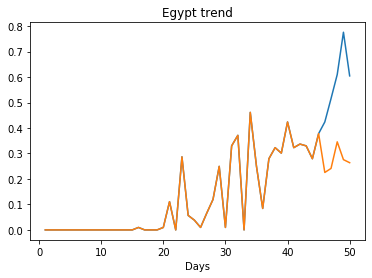

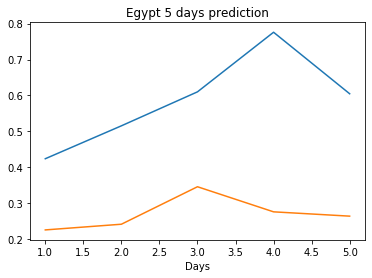

Creating directory ./offline7/United Arab Emirates/training/
United Arab Emirates
Saving the best model weights at Epoch [1], Best Valid Loss: 2.7064
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5966
Saving the best model weights at Epoch [3], Best Valid Loss: 2.4187
Saving the best model weights at Epoch [4], Best Valid Loss: 2.3986
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3661
Saving the best model weights at Epoch [6], Best Valid Loss: 2.3358
Saving the best model weights at Epoch [7], Best Valid Loss: 2.2921
Saving the best model weights at Epoch [8], Best Valid Loss: 2.1185
Saving the best model weights at Epoch [10], Best Valid Loss: 2.0103
Saving the best model weights at Epoch [11], Best Valid Loss: 1.9701
Saving the best model weights at Epoch [12], Best Valid Loss: 1.8379
Saving the best model weights at Epoch [13], Best Valid Loss: 1.7619
Saving the best model weights at Epoch [14], Best Valid Loss: 1.6384
Saving the best model weights

Saving the best model weights at Epoch [2], Best Valid Loss: 1.7547
Saving the best model weights at Epoch [3], Best Valid Loss: 1.7455
Saving the best model weights at Epoch [4], Best Valid Loss: 1.4397
Saving the best model weights at Epoch [5], Best Valid Loss: 1.3157
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0929
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0654
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0372
train error: 0.3107825493958268
1.0372036695480347
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3302
Saving the best model weights at Epoch [2], Best Valid Loss: 1.6055
Saving the best model weights at Epoch [3], Best Valid Loss: 1.5085
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2947
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1805
train error: 0.20550157012428005
0.1805344671010971
Saving the best model weights at Epoch [1], Best Valid Loss: 2.4154
Saving the be

Saving the best model weights at Epoch [23], Best Valid Loss: 2.0959
Saving the best model weights at Epoch [26], Best Valid Loss: 2.0883
Saving the best model weights at Epoch [27], Best Valid Loss: 1.9940
Saving the best model weights at Epoch [31], Best Valid Loss: 1.9436
Saving the best model weights at Epoch [32], Best Valid Loss: 1.7974
Saving the best model weights at Epoch [33], Best Valid Loss: 1.7196
Saving the best model weights at Epoch [34], Best Valid Loss: 1.6901
Saving the best model weights at Epoch [37], Best Valid Loss: 1.6414
Saving the best model weights at Epoch [38], Best Valid Loss: 1.5595
Saving the best model weights at Epoch [39], Best Valid Loss: 1.4843
Saving the best model weights at Epoch [40], Best Valid Loss: 1.3516
Saving the best model weights at Epoch [42], Best Valid Loss: 1.3375
Saving the best model weights at Epoch [43], Best Valid Loss: 1.2583
Saving the best model weights at Epoch [44], Best Valid Loss: 1.2476
Saving the best model weights at E

train error: 0.6613494116933115
2.634350538253784
Saving the best model weights at Epoch [1], Best Valid Loss: 3.0563
Saving the best model weights at Epoch [2], Best Valid Loss: 3.0180
Saving the best model weights at Epoch [3], Best Valid Loss: 2.8075
train error: 0.7006821379726452
2.8074655532836914
Saving the best model weights at Epoch [1], Best Valid Loss: 3.4053
train error: 0.7941086864279162
3.405292510986328
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1336
Saving the best model weights at Epoch [2], Best Valid Loss: 3.1096
Saving the best model weights at Epoch [3], Best Valid Loss: 3.0844
Saving the best model weights at Epoch [8], Best Valid Loss: 3.0500
Saving the best model weights at Epoch [19], Best Valid Loss: 3.0393
Saving the best model weights at Epoch [33], Best Valid Loss: 3.0292
train error: 0.7064093358574375
3.029233694076538
Saving the best model weights at Epoch [1], Best Valid Loss: 3.0447
Saving the best model weights at Epoch [3], Best 

Saving the best model weights at Epoch [44], Best Valid Loss: 1.6836
Saving the best model weights at Epoch [45], Best Valid Loss: 1.6763
Saving the best model weights at Epoch [46], Best Valid Loss: 1.6694
Saving the best model weights at Epoch [47], Best Valid Loss: 1.6618
Saving the best model weights at Epoch [48], Best Valid Loss: 1.6568
Saving the best model weights at Epoch [49], Best Valid Loss: 1.6497
Saving the best model weights at Epoch [50], Best Valid Loss: 1.6423
train error: 0.45131707215501415
1.6422840356826782
Saving the best model weights at Epoch [1], Best Valid Loss: 3.4231
train error: 0.7410048721057754
3.4230599403381348
Saving the best model weights at Epoch [1], Best Valid Loss: 2.8110
Saving the best model weights at Epoch [2], Best Valid Loss: 2.6504
Saving the best model weights at Epoch [3], Best Valid Loss: 2.6294
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5657
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5447
Saving

Saving the best model weights at Epoch [44], Best Valid Loss: 2.3179
Saving the best model weights at Epoch [45], Best Valid Loss: 2.3100
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3011
Saving the best model weights at Epoch [47], Best Valid Loss: 2.2946
Saving the best model weights at Epoch [48], Best Valid Loss: 2.2917
Saving the best model weights at Epoch [49], Best Valid Loss: 2.2794
Saving the best model weights at Epoch [50], Best Valid Loss: 2.2733
train error: 0.504567904157504
2.2733266353607178
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1058
Saving the best model weights at Epoch [2], Best Valid Loss: 3.0747
Saving the best model weights at Epoch [4], Best Valid Loss: 3.0676
Saving the best model weights at Epoch [5], Best Valid Loss: 3.0391
Saving the best model weights at Epoch [9], Best Valid Loss: 3.0390
Saving the best model weights at Epoch [10], Best Valid Loss: 3.0333
train error: 0.5105474192889468
3.033334732055664
Saving t

Saving the best model weights at Epoch [6], Best Valid Loss: 1.9420
Saving the best model weights at Epoch [7], Best Valid Loss: 1.4926
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1451
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0851
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0663
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9011
Saving the best model weights at Epoch [12], Best Valid Loss: 0.8508
Saving the best model weights at Epoch [13], Best Valid Loss: 0.7641
Saving the best model weights at Epoch [14], Best Valid Loss: 0.7273
Saving the best model weights at Epoch [17], Best Valid Loss: 0.7241
train error: 0.1600569995540765
0.7240766286849976
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2405
Saving the best model weights at Epoch [2], Best Valid Loss: 3.1406
Saving the best model weights at Epoch [3], Best Valid Loss: 3.0579
Saving the best model weights at Epoch [4], Best Valid Loss

Saving the best model weights at Epoch [14], Best Valid Loss: 1.9221
Saving the best model weights at Epoch [15], Best Valid Loss: 1.9082
Saving the best model weights at Epoch [16], Best Valid Loss: 1.8144
Saving the best model weights at Epoch [34], Best Valid Loss: 1.8093
train error: 0.48242818906662926
1.809282660484314
Saving the best model weights at Epoch [1], Best Valid Loss: 2.9951
Saving the best model weights at Epoch [2], Best Valid Loss: 2.8973
Saving the best model weights at Epoch [3], Best Valid Loss: 2.8191
Saving the best model weights at Epoch [4], Best Valid Loss: 2.7540
Saving the best model weights at Epoch [5], Best Valid Loss: 2.6984
Saving the best model weights at Epoch [6], Best Valid Loss: 2.6517
Saving the best model weights at Epoch [7], Best Valid Loss: 2.6133
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5790
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5520
Saving the best model weights at Epoch [10], Best Valid Loss:

Saving the best model weights at Epoch [11], Best Valid Loss: 2.2892
Saving the best model weights at Epoch [12], Best Valid Loss: 2.2795
Saving the best model weights at Epoch [13], Best Valid Loss: 2.2630
Saving the best model weights at Epoch [14], Best Valid Loss: 2.2600
Saving the best model weights at Epoch [15], Best Valid Loss: 2.2564
Saving the best model weights at Epoch [16], Best Valid Loss: 2.2537
Saving the best model weights at Epoch [17], Best Valid Loss: 2.2501
Saving the best model weights at Epoch [18], Best Valid Loss: 2.2466
Saving the best model weights at Epoch [25], Best Valid Loss: 2.2451
Saving the best model weights at Epoch [27], Best Valid Loss: 2.2426
Saving the best model weights at Epoch [29], Best Valid Loss: 2.2419
Saving the best model weights at Epoch [36], Best Valid Loss: 2.2306
Saving the best model weights at Epoch [49], Best Valid Loss: 2.2269
Saving the best model weights at Epoch [50], Best Valid Loss: 2.2256
train error: 0.5534284840668401
2.

Saving the best model weights at Epoch [21], Best Valid Loss: 1.9281
Saving the best model weights at Epoch [22], Best Valid Loss: 1.9222
Saving the best model weights at Epoch [23], Best Valid Loss: 1.9177
Saving the best model weights at Epoch [24], Best Valid Loss: 1.9126
Saving the best model weights at Epoch [25], Best Valid Loss: 1.9063
Saving the best model weights at Epoch [26], Best Valid Loss: 1.9001
Saving the best model weights at Epoch [27], Best Valid Loss: 1.8962
Saving the best model weights at Epoch [28], Best Valid Loss: 1.8953
Saving the best model weights at Epoch [29], Best Valid Loss: 1.8931
Saving the best model weights at Epoch [30], Best Valid Loss: 1.8901
Saving the best model weights at Epoch [31], Best Valid Loss: 1.8875
Saving the best model weights at Epoch [32], Best Valid Loss: 1.8875
Saving the best model weights at Epoch [33], Best Valid Loss: 1.8868
Saving the best model weights at Epoch [34], Best Valid Loss: 1.8840
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 2.7105
train error: 0.6291332970703801
2.7104833126068115
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2858
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2477
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2171
Saving the best model weights at Epoch [4], Best Valid Loss: 3.1916
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1699
Saving the best model weights at Epoch [6], Best Valid Loss: 3.1501
Saving the best model weights at Epoch [7], Best Valid Loss: 3.1354
Saving the best model weights at Epoch [8], Best Valid Loss: 3.1225
Saving the best model weights at Epoch [9], Best Valid Loss: 3.1111
Saving the best model weights at Epoch [10], Best Valid Loss: 3.1008
Saving the best model weights at Epoch [11], Best Valid Loss: 3.0927
Saving the best model weights at Epoch [12], Best Valid Loss: 3.0859
Saving the best model weights at Epoch [13], Best Valid Loss:

Saving the best model weights at Epoch [21], Best Valid Loss: 2.7243
Saving the best model weights at Epoch [22], Best Valid Loss: 2.7209
Saving the best model weights at Epoch [23], Best Valid Loss: 2.7186
Saving the best model weights at Epoch [24], Best Valid Loss: 2.7155
Saving the best model weights at Epoch [25], Best Valid Loss: 2.7128
Saving the best model weights at Epoch [26], Best Valid Loss: 2.7108
Saving the best model weights at Epoch [27], Best Valid Loss: 2.7088
Saving the best model weights at Epoch [28], Best Valid Loss: 2.7074
Saving the best model weights at Epoch [29], Best Valid Loss: 2.7068
Saving the best model weights at Epoch [30], Best Valid Loss: 2.7065
Saving the best model weights at Epoch [32], Best Valid Loss: 2.7057
Saving the best model weights at Epoch [33], Best Valid Loss: 2.7048
Saving the best model weights at Epoch [34], Best Valid Loss: 2.7039
Saving the best model weights at Epoch [35], Best Valid Loss: 2.7035
Saving the best model weights at E

Saving the best model weights at Epoch [20], Best Valid Loss: 2.2326
Saving the best model weights at Epoch [21], Best Valid Loss: 2.2259
Saving the best model weights at Epoch [22], Best Valid Loss: 2.2229
Saving the best model weights at Epoch [23], Best Valid Loss: 2.2197
Saving the best model weights at Epoch [24], Best Valid Loss: 2.2136
Saving the best model weights at Epoch [25], Best Valid Loss: 2.1997
Saving the best model weights at Epoch [26], Best Valid Loss: 2.1980
Saving the best model weights at Epoch [28], Best Valid Loss: 2.1957
Saving the best model weights at Epoch [36], Best Valid Loss: 2.1948
Saving the best model weights at Epoch [37], Best Valid Loss: 2.1931
Saving the best model weights at Epoch [41], Best Valid Loss: 2.1883
Saving the best model weights at Epoch [42], Best Valid Loss: 2.1842
train error: 0.5842867152344796
2.1841695308685303
Saving the best model weights at Epoch [1], Best Valid Loss: 2.2549
Saving the best model weights at Epoch [2], Best Vali

Saving the best model weights at Epoch [11], Best Valid Loss: 2.3861
Saving the best model weights at Epoch [12], Best Valid Loss: 2.3827
Saving the best model weights at Epoch [13], Best Valid Loss: 2.3689
Saving the best model weights at Epoch [14], Best Valid Loss: 2.3669
Saving the best model weights at Epoch [16], Best Valid Loss: 2.3626
Saving the best model weights at Epoch [17], Best Valid Loss: 2.3574
Saving the best model weights at Epoch [18], Best Valid Loss: 2.3550
Saving the best model weights at Epoch [19], Best Valid Loss: 2.3549
Saving the best model weights at Epoch [20], Best Valid Loss: 2.3538
Saving the best model weights at Epoch [21], Best Valid Loss: 2.3537
Saving the best model weights at Epoch [22], Best Valid Loss: 2.3512
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3503
Saving the best model weights at Epoch [38], Best Valid Loss: 2.3499
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3472
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 2.3942
Saving the best model weights at Epoch [39], Best Valid Loss: 2.3934
Saving the best model weights at Epoch [41], Best Valid Loss: 2.3928
train error: 0.5701204463839531
2.3927764892578125
Saving the best model weights at Epoch [1], Best Valid Loss: 3.0914
Saving the best model weights at Epoch [2], Best Valid Loss: 2.9603
Saving the best model weights at Epoch [3], Best Valid Loss: 2.8433
Saving the best model weights at Epoch [4], Best Valid Loss: 2.7702
Saving the best model weights at Epoch [5], Best Valid Loss: 2.7173
Saving the best model weights at Epoch [6], Best Valid Loss: 2.6696
Saving the best model weights at Epoch [7], Best Valid Loss: 2.6442
Saving the best model weights at Epoch [8], Best Valid Loss: 2.6155
Saving the best model weights at Epoch [9], Best Valid Loss: 2.6031
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5871
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [15], Best Valid Loss: 3.0834
Saving the best model weights at Epoch [16], Best Valid Loss: 3.0797
Saving the best model weights at Epoch [17], Best Valid Loss: 3.0767
Saving the best model weights at Epoch [18], Best Valid Loss: 3.0738
Saving the best model weights at Epoch [19], Best Valid Loss: 3.0720
Saving the best model weights at Epoch [20], Best Valid Loss: 3.0701
Saving the best model weights at Epoch [21], Best Valid Loss: 3.0688
Saving the best model weights at Epoch [22], Best Valid Loss: 3.0669
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0659
Saving the best model weights at Epoch [24], Best Valid Loss: 3.0646
Saving the best model weights at Epoch [25], Best Valid Loss: 3.0632
Saving the best model weights at Epoch [26], Best Valid Loss: 3.0625
Saving the best model weights at Epoch [27], Best Valid Loss: 3.0620
Saving the best model weights at Epoch [28], Best Valid Loss: 3.0608
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 3.0357
Saving the best model weights at Epoch [42], Best Valid Loss: 3.0309
Saving the best model weights at Epoch [43], Best Valid Loss: 3.0249
Saving the best model weights at Epoch [44], Best Valid Loss: 3.0193
Saving the best model weights at Epoch [45], Best Valid Loss: 3.0152
Saving the best model weights at Epoch [46], Best Valid Loss: 3.0093
Saving the best model weights at Epoch [47], Best Valid Loss: 3.0046
Saving the best model weights at Epoch [48], Best Valid Loss: 3.0003
Saving the best model weights at Epoch [49], Best Valid Loss: 2.9958
Saving the best model weights at Epoch [50], Best Valid Loss: 2.9903
train error: 0.7276921181548988
2.9903032779693604
Saving the best model weights at Epoch [1], Best Valid Loss: 2.9130
Saving the best model weights at Epoch [2], Best Valid Loss: 2.8202
Saving the best model weights at Epoch [3], Best Valid Loss: 2.7265
Saving the best model weights at Epoch [4], Best Valid 

Saving the best model weights at Epoch [27], Best Valid Loss: 2.4282
Saving the best model weights at Epoch [28], Best Valid Loss: 2.4077
Saving the best model weights at Epoch [29], Best Valid Loss: 2.3880
Saving the best model weights at Epoch [30], Best Valid Loss: 2.3711
Saving the best model weights at Epoch [31], Best Valid Loss: 2.3529
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3371
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3192
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3031
Saving the best model weights at Epoch [35], Best Valid Loss: 2.2883
Saving the best model weights at Epoch [36], Best Valid Loss: 2.2719
Saving the best model weights at Epoch [37], Best Valid Loss: 2.2577
Saving the best model weights at Epoch [38], Best Valid Loss: 2.2437
Saving the best model weights at Epoch [39], Best Valid Loss: 2.2293
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2159
Saving the best model weights at E

Saving the best model weights at Epoch [6], Best Valid Loss: 3.0856
Saving the best model weights at Epoch [7], Best Valid Loss: 3.0656
Saving the best model weights at Epoch [8], Best Valid Loss: 3.0469
Saving the best model weights at Epoch [9], Best Valid Loss: 3.0301
Saving the best model weights at Epoch [10], Best Valid Loss: 3.0109
Saving the best model weights at Epoch [11], Best Valid Loss: 2.9918
Saving the best model weights at Epoch [12], Best Valid Loss: 2.9717
Saving the best model weights at Epoch [13], Best Valid Loss: 2.9520
Saving the best model weights at Epoch [14], Best Valid Loss: 2.9340
Saving the best model weights at Epoch [15], Best Valid Loss: 2.9155
Saving the best model weights at Epoch [16], Best Valid Loss: 2.8980
Saving the best model weights at Epoch [17], Best Valid Loss: 2.8780
Saving the best model weights at Epoch [18], Best Valid Loss: 2.8584
Saving the best model weights at Epoch [19], Best Valid Loss: 2.8351
Saving the best model weights at Epoch

Saving the best model weights at Epoch [28], Best Valid Loss: 2.9698
Saving the best model weights at Epoch [29], Best Valid Loss: 2.9611
Saving the best model weights at Epoch [30], Best Valid Loss: 2.9526
Saving the best model weights at Epoch [31], Best Valid Loss: 2.9440
Saving the best model weights at Epoch [32], Best Valid Loss: 2.9357
Saving the best model weights at Epoch [33], Best Valid Loss: 2.9274
Saving the best model weights at Epoch [34], Best Valid Loss: 2.9194
Saving the best model weights at Epoch [35], Best Valid Loss: 2.9116
Saving the best model weights at Epoch [36], Best Valid Loss: 2.9039
Saving the best model weights at Epoch [37], Best Valid Loss: 2.8963
Saving the best model weights at Epoch [38], Best Valid Loss: 2.8888
Saving the best model weights at Epoch [39], Best Valid Loss: 2.8814
Saving the best model weights at Epoch [40], Best Valid Loss: 2.8743
Saving the best model weights at Epoch [41], Best Valid Loss: 2.8672
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 1.8140
train error: 0.49344842568520575
1.8140052556991577
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2830
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2736
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2644
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2514
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2375
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2227
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2084
Saving the best model weights at Epoch [8], Best Valid Loss: 3.1942
Saving the best model weights at Epoch [9], Best Valid Loss: 3.1803
Saving the best model weights at Epoch [10], Best Valid Loss: 3.1668
Saving the best model weights at Epoch [11], Best Valid Loss: 3.1533
Saving the best model weights at Epoch [12], Best Valid Loss: 3.1401
Saving the best model weights at Epoch [13], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 2.6642
Saving the best model weights at Epoch [18], Best Valid Loss: 2.6569
Saving the best model weights at Epoch [19], Best Valid Loss: 2.6536
Saving the best model weights at Epoch [20], Best Valid Loss: 2.6439
Saving the best model weights at Epoch [21], Best Valid Loss: 2.6297
Saving the best model weights at Epoch [24], Best Valid Loss: 2.6271
Saving the best model weights at Epoch [25], Best Valid Loss: 2.6185
Saving the best model weights at Epoch [26], Best Valid Loss: 2.6148
Saving the best model weights at Epoch [28], Best Valid Loss: 2.6130
Saving the best model weights at Epoch [32], Best Valid Loss: 2.6073
Saving the best model weights at Epoch [38], Best Valid Loss: 2.6018
Saving the best model weights at Epoch [39], Best Valid Loss: 2.6002
Saving the best model weights at Epoch [50], Best Valid Loss: 2.5956
train error: 0.6427496308761258
2.5956380367279053
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [24], Best Valid Loss: 3.1099
Saving the best model weights at Epoch [25], Best Valid Loss: 3.1014
Saving the best model weights at Epoch [26], Best Valid Loss: 3.0931
Saving the best model weights at Epoch [27], Best Valid Loss: 3.0850
Saving the best model weights at Epoch [28], Best Valid Loss: 3.0770
Saving the best model weights at Epoch [29], Best Valid Loss: 3.0691
Saving the best model weights at Epoch [30], Best Valid Loss: 3.0614
Saving the best model weights at Epoch [31], Best Valid Loss: 3.0539
Saving the best model weights at Epoch [32], Best Valid Loss: 3.0464
Saving the best model weights at Epoch [33], Best Valid Loss: 3.0391
Saving the best model weights at Epoch [34], Best Valid Loss: 3.0321
Saving the best model weights at Epoch [35], Best Valid Loss: 3.0248
Saving the best model weights at Epoch [36], Best Valid Loss: 3.0179
Saving the best model weights at Epoch [37], Best Valid Loss: 3.0110
Saving the best model weights at E

Saving the best model weights at Epoch [8], Best Valid Loss: 3.1914
Saving the best model weights at Epoch [9], Best Valid Loss: 3.1832
Saving the best model weights at Epoch [10], Best Valid Loss: 3.1752
Saving the best model weights at Epoch [11], Best Valid Loss: 3.1672
Saving the best model weights at Epoch [12], Best Valid Loss: 3.1595
Saving the best model weights at Epoch [13], Best Valid Loss: 3.1518
Saving the best model weights at Epoch [14], Best Valid Loss: 3.1443
Saving the best model weights at Epoch [15], Best Valid Loss: 3.1371
Saving the best model weights at Epoch [16], Best Valid Loss: 3.1298
Saving the best model weights at Epoch [17], Best Valid Loss: 3.1227
Saving the best model weights at Epoch [18], Best Valid Loss: 3.1157
Saving the best model weights at Epoch [19], Best Valid Loss: 3.1088
Saving the best model weights at Epoch [20], Best Valid Loss: 3.1021
Saving the best model weights at Epoch [21], Best Valid Loss: 3.0957
Saving the best model weights at Epo

Saving the best model weights at Epoch [32], Best Valid Loss: 2.2262
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2223
Saving the best model weights at Epoch [43], Best Valid Loss: 2.2203
Saving the best model weights at Epoch [44], Best Valid Loss: 2.2149
train error: 0.5867323625472284
2.214928150177002
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1021
Saving the best model weights at Epoch [2], Best Valid Loss: 3.0930
Saving the best model weights at Epoch [3], Best Valid Loss: 3.0842
Saving the best model weights at Epoch [4], Best Valid Loss: 3.0755
Saving the best model weights at Epoch [5], Best Valid Loss: 3.0668
Saving the best model weights at Epoch [6], Best Valid Loss: 3.0583
Saving the best model weights at Epoch [7], Best Valid Loss: 3.0500
Saving the best model weights at Epoch [8], Best Valid Loss: 3.0418
Saving the best model weights at Epoch [9], Best Valid Loss: 3.0338
Saving the best model weights at Epoch [10], Best Valid Loss: 

Saving the best model weights at Epoch [14], Best Valid Loss: 2.7631
Saving the best model weights at Epoch [15], Best Valid Loss: 2.7483
Saving the best model weights at Epoch [16], Best Valid Loss: 2.7424
Saving the best model weights at Epoch [17], Best Valid Loss: 2.7285
Saving the best model weights at Epoch [19], Best Valid Loss: 2.7226
Saving the best model weights at Epoch [21], Best Valid Loss: 2.7176
Saving the best model weights at Epoch [22], Best Valid Loss: 2.7142
Saving the best model weights at Epoch [23], Best Valid Loss: 2.7053
Saving the best model weights at Epoch [26], Best Valid Loss: 2.7049
Saving the best model weights at Epoch [30], Best Valid Loss: 2.6977
Saving the best model weights at Epoch [34], Best Valid Loss: 2.6939
Saving the best model weights at Epoch [40], Best Valid Loss: 2.6913
train error: 0.6512954969319605
2.691293478012085
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3301
Saving the best model weights at Epoch [2], Best Valid

Saving the best model weights at Epoch [6], Best Valid Loss: 2.6572
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5953
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5422
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5063
Saving the best model weights at Epoch [10], Best Valid Loss: 2.4717
Saving the best model weights at Epoch [11], Best Valid Loss: 2.4325
Saving the best model weights at Epoch [12], Best Valid Loss: 2.4053
Saving the best model weights at Epoch [13], Best Valid Loss: 2.3736
Saving the best model weights at Epoch [14], Best Valid Loss: 2.3510
Saving the best model weights at Epoch [15], Best Valid Loss: 2.3412
Saving the best model weights at Epoch [16], Best Valid Loss: 2.3180
Saving the best model weights at Epoch [17], Best Valid Loss: 2.3049
Saving the best model weights at Epoch [18], Best Valid Loss: 2.2893
Saving the best model weights at Epoch [19], Best Valid Loss: 2.2831
Saving the best model weights at Epoch

Saving the best model weights at Epoch [43], Best Valid Loss: 2.7880
Saving the best model weights at Epoch [44], Best Valid Loss: 2.7826
Saving the best model weights at Epoch [45], Best Valid Loss: 2.7775
Saving the best model weights at Epoch [46], Best Valid Loss: 2.7725
Saving the best model weights at Epoch [47], Best Valid Loss: 2.7679
Saving the best model weights at Epoch [48], Best Valid Loss: 2.7632
Saving the best model weights at Epoch [49], Best Valid Loss: 2.7586
Saving the best model weights at Epoch [50], Best Valid Loss: 2.7536
train error: 0.6499261393422081
2.753636360168457
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3237
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2797
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2442
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2176
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1925
Saving the best model weights at Epoch [6], Best Valid Los

Saving the best model weights at Epoch [31], Best Valid Loss: 2.3982
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3833
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3702
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3552
Saving the best model weights at Epoch [35], Best Valid Loss: 2.3422
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3292
Saving the best model weights at Epoch [37], Best Valid Loss: 2.3176
Saving the best model weights at Epoch [38], Best Valid Loss: 2.3036
Saving the best model weights at Epoch [39], Best Valid Loss: 2.2923
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2820
Saving the best model weights at Epoch [41], Best Valid Loss: 2.2700
Saving the best model weights at Epoch [42], Best Valid Loss: 2.2600
Saving the best model weights at Epoch [43], Best Valid Loss: 2.2484
Saving the best model weights at Epoch [44], Best Valid Loss: 2.2383
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 2.8673
Saving the best model weights at Epoch [48], Best Valid Loss: 2.8641
Saving the best model weights at Epoch [49], Best Valid Loss: 2.8609
Saving the best model weights at Epoch [50], Best Valid Loss: 2.8581
train error: 0.6290595347602521
2.8580901622772217
Saving the best model weights at Epoch [1], Best Valid Loss: 3.0542
Saving the best model weights at Epoch [2], Best Valid Loss: 2.9875
Saving the best model weights at Epoch [3], Best Valid Loss: 2.9371
Saving the best model weights at Epoch [4], Best Valid Loss: 2.8756
Saving the best model weights at Epoch [5], Best Valid Loss: 2.8326
Saving the best model weights at Epoch [6], Best Valid Loss: 2.8049
Saving the best model weights at Epoch [7], Best Valid Loss: 2.7689
Saving the best model weights at Epoch [8], Best Valid Loss: 2.7439
Saving the best model weights at Epoch [9], Best Valid Loss: 2.7149
Saving the best model weights at Epoch [10], Best Valid Loss:

Saving the best model weights at Epoch [35], Best Valid Loss: 2.3571
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3419
Saving the best model weights at Epoch [37], Best Valid Loss: 2.3274
Saving the best model weights at Epoch [38], Best Valid Loss: 2.3136
Saving the best model weights at Epoch [39], Best Valid Loss: 2.3017
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2869
Saving the best model weights at Epoch [41], Best Valid Loss: 2.2743
Saving the best model weights at Epoch [42], Best Valid Loss: 2.2622
Saving the best model weights at Epoch [43], Best Valid Loss: 2.2517
Saving the best model weights at Epoch [44], Best Valid Loss: 2.2392
Saving the best model weights at Epoch [45], Best Valid Loss: 2.2283
Saving the best model weights at Epoch [46], Best Valid Loss: 2.2170
Saving the best model weights at Epoch [47], Best Valid Loss: 2.2075
Saving the best model weights at Epoch [48], Best Valid Loss: 2.1968
Saving the best model weights at E

Saving the best model weights at Epoch [21], Best Valid Loss: 3.0497
Saving the best model weights at Epoch [22], Best Valid Loss: 3.0408
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0319
Saving the best model weights at Epoch [24], Best Valid Loss: 3.0237
Saving the best model weights at Epoch [25], Best Valid Loss: 3.0163
Saving the best model weights at Epoch [26], Best Valid Loss: 3.0083
Saving the best model weights at Epoch [27], Best Valid Loss: 3.0004
Saving the best model weights at Epoch [28], Best Valid Loss: 2.9925
Saving the best model weights at Epoch [29], Best Valid Loss: 2.9852
Saving the best model weights at Epoch [30], Best Valid Loss: 2.9783
Saving the best model weights at Epoch [31], Best Valid Loss: 2.9716
Saving the best model weights at Epoch [32], Best Valid Loss: 2.9649
Saving the best model weights at Epoch [33], Best Valid Loss: 2.9587
Saving the best model weights at Epoch [34], Best Valid Loss: 2.9526
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 3.1768
Saving the best model weights at Epoch [8], Best Valid Loss: 3.1586
Saving the best model weights at Epoch [9], Best Valid Loss: 3.1409
Saving the best model weights at Epoch [10], Best Valid Loss: 3.1241
Saving the best model weights at Epoch [11], Best Valid Loss: 3.1076
Saving the best model weights at Epoch [12], Best Valid Loss: 3.0915
Saving the best model weights at Epoch [13], Best Valid Loss: 3.0761
Saving the best model weights at Epoch [14], Best Valid Loss: 3.0613
Saving the best model weights at Epoch [15], Best Valid Loss: 3.0472
Saving the best model weights at Epoch [16], Best Valid Loss: 3.0332
Saving the best model weights at Epoch [17], Best Valid Loss: 3.0195
Saving the best model weights at Epoch [18], Best Valid Loss: 3.0067
Saving the best model weights at Epoch [19], Best Valid Loss: 2.9939
Saving the best model weights at Epoch [20], Best Valid Loss: 2.9819
Saving the best model weights at Epoc

Saving the best model weights at Epoch [45], Best Valid Loss: 2.8614
Saving the best model weights at Epoch [46], Best Valid Loss: 2.8587
Saving the best model weights at Epoch [47], Best Valid Loss: 2.8562
Saving the best model weights at Epoch [48], Best Valid Loss: 2.8536
Saving the best model weights at Epoch [49], Best Valid Loss: 2.8511
Saving the best model weights at Epoch [50], Best Valid Loss: 2.8487
train error: 0.6615299133643988
2.8487064838409424
Saving the best model weights at Epoch [1], Best Valid Loss: 3.0995
Saving the best model weights at Epoch [2], Best Valid Loss: 3.0839
Saving the best model weights at Epoch [3], Best Valid Loss: 3.0692
Saving the best model weights at Epoch [4], Best Valid Loss: 3.0553
Saving the best model weights at Epoch [5], Best Valid Loss: 3.0402
Saving the best model weights at Epoch [6], Best Valid Loss: 3.0262
Saving the best model weights at Epoch [7], Best Valid Loss: 3.0136
Saving the best model weights at Epoch [8], Best Valid Loss

Saving the best model weights at Epoch [34], Best Valid Loss: 2.9062
Saving the best model weights at Epoch [35], Best Valid Loss: 2.9003
Saving the best model weights at Epoch [36], Best Valid Loss: 2.8946
Saving the best model weights at Epoch [37], Best Valid Loss: 2.8888
Saving the best model weights at Epoch [38], Best Valid Loss: 2.8832
Saving the best model weights at Epoch [39], Best Valid Loss: 2.8778
Saving the best model weights at Epoch [40], Best Valid Loss: 2.8723
Saving the best model weights at Epoch [41], Best Valid Loss: 2.8670
Saving the best model weights at Epoch [42], Best Valid Loss: 2.8618
Saving the best model weights at Epoch [43], Best Valid Loss: 2.8567
Saving the best model weights at Epoch [44], Best Valid Loss: 2.8516
Saving the best model weights at Epoch [45], Best Valid Loss: 2.8467
Saving the best model weights at Epoch [46], Best Valid Loss: 2.8418
Saving the best model weights at Epoch [47], Best Valid Loss: 2.8370
Saving the best model weights at E

Saving the best model weights at Epoch [19], Best Valid Loss: 3.2312
Saving the best model weights at Epoch [20], Best Valid Loss: 3.2263
Saving the best model weights at Epoch [21], Best Valid Loss: 3.2223
Saving the best model weights at Epoch [22], Best Valid Loss: 3.2177
Saving the best model weights at Epoch [23], Best Valid Loss: 3.2137
Saving the best model weights at Epoch [24], Best Valid Loss: 3.2098
Saving the best model weights at Epoch [25], Best Valid Loss: 3.2056
Saving the best model weights at Epoch [26], Best Valid Loss: 3.2019
Saving the best model weights at Epoch [27], Best Valid Loss: 3.1984
Saving the best model weights at Epoch [28], Best Valid Loss: 3.1948
Saving the best model weights at Epoch [29], Best Valid Loss: 3.1912
Saving the best model weights at Epoch [30], Best Valid Loss: 3.1880
Saving the best model weights at Epoch [31], Best Valid Loss: 3.1847
Saving the best model weights at Epoch [32], Best Valid Loss: 3.1817
Saving the best model weights at E

Saving the best model weights at Epoch [11], Best Valid Loss: 3.1758
Saving the best model weights at Epoch [12], Best Valid Loss: 3.1617
Saving the best model weights at Epoch [13], Best Valid Loss: 3.1486
Saving the best model weights at Epoch [14], Best Valid Loss: 3.1358
Saving the best model weights at Epoch [15], Best Valid Loss: 3.1227
Saving the best model weights at Epoch [16], Best Valid Loss: 3.1113
Saving the best model weights at Epoch [17], Best Valid Loss: 3.0990
Saving the best model weights at Epoch [18], Best Valid Loss: 3.0878
Saving the best model weights at Epoch [19], Best Valid Loss: 3.0767
Saving the best model weights at Epoch [20], Best Valid Loss: 3.0661
Saving the best model weights at Epoch [21], Best Valid Loss: 3.0557
Saving the best model weights at Epoch [22], Best Valid Loss: 3.0463
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0361
Saving the best model weights at Epoch [24], Best Valid Loss: 3.0269
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 2.3519
train error: 0.6014384948197873
2.351919412612915
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2754
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2726
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2699
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2672
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2644
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2618
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2591
Saving the best model weights at Epoch [8], Best Valid Loss: 3.2563
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2537
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2510
Saving the best model weights at Epoch [11], Best Valid Loss: 3.2484
Saving the best model weights at Epoch [12], Best Valid Loss: 3.2458
Saving the best model weights at Epoch [13], Best Valid Loss: 

Saving the best model weights at Epoch [17], Best Valid Loss: 3.2987
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2975
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2964
Saving the best model weights at Epoch [20], Best Valid Loss: 3.2953
Saving the best model weights at Epoch [21], Best Valid Loss: 3.2941
Saving the best model weights at Epoch [22], Best Valid Loss: 3.2930
Saving the best model weights at Epoch [23], Best Valid Loss: 3.2919
Saving the best model weights at Epoch [24], Best Valid Loss: 3.2907
Saving the best model weights at Epoch [25], Best Valid Loss: 3.2896
Saving the best model weights at Epoch [26], Best Valid Loss: 3.2885
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2874
Saving the best model weights at Epoch [28], Best Valid Loss: 3.2863
Saving the best model weights at Epoch [29], Best Valid Loss: 3.2851
Saving the best model weights at Epoch [30], Best Valid Loss: 3.2840
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 3.0450
Saving the best model weights at Epoch [36], Best Valid Loss: 3.0406
Saving the best model weights at Epoch [37], Best Valid Loss: 3.0330
Saving the best model weights at Epoch [38], Best Valid Loss: 3.0251
Saving the best model weights at Epoch [39], Best Valid Loss: 3.0190
Saving the best model weights at Epoch [40], Best Valid Loss: 3.0126
Saving the best model weights at Epoch [41], Best Valid Loss: 3.0063
Saving the best model weights at Epoch [42], Best Valid Loss: 3.0003
Saving the best model weights at Epoch [43], Best Valid Loss: 2.9943
Saving the best model weights at Epoch [44], Best Valid Loss: 2.9877
Saving the best model weights at Epoch [45], Best Valid Loss: 2.9830
Saving the best model weights at Epoch [46], Best Valid Loss: 2.9760
Saving the best model weights at Epoch [47], Best Valid Loss: 2.9708
Saving the best model weights at Epoch [48], Best Valid Loss: 2.9647
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.3271
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3024
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2816
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2562
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2340
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2069
Saving the best model weights at Epoch [8], Best Valid Loss: 3.1837
Saving the best model weights at Epoch [9], Best Valid Loss: 3.1611
Saving the best model weights at Epoch [10], Best Valid Loss: 3.1364
Saving the best model weights at Epoch [11], Best Valid Loss: 3.1154
Saving the best model weights at Epoch [12], Best Valid Loss: 3.0919
Saving the best model weights at Epoch [13], Best Valid Loss: 3.0707
Saving the best model weights at Epoch [14], Best Valid Loss: 3.0506
Saving the best model weights at Epoch [15], Best Valid Loss: 3.0311
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 3.3533
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3522
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3511
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3501
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3490
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3480
Saving the best model weights at Epoch [26], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [27], Best Valid Loss: 3.3458
Saving the best model weights at Epoch [28], Best Valid Loss: 3.3448
Saving the best model weights at Epoch [29], Best Valid Loss: 3.3437
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3423
Saving the best model weights at Epoch [31], Best Valid Loss: 3.3406
Saving the best model weights at Epoch [32], Best Valid Loss: 3.3389
Saving the best model weights at Epoch [33], Best Valid Loss: 3.3371
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 3.1102
Saving the best model weights at Epoch [39], Best Valid Loss: 3.1092
Saving the best model weights at Epoch [40], Best Valid Loss: 3.1083
Saving the best model weights at Epoch [41], Best Valid Loss: 3.1074
Saving the best model weights at Epoch [42], Best Valid Loss: 3.1064
Saving the best model weights at Epoch [43], Best Valid Loss: 3.1055
Saving the best model weights at Epoch [44], Best Valid Loss: 3.1046
Saving the best model weights at Epoch [45], Best Valid Loss: 3.1037
Saving the best model weights at Epoch [46], Best Valid Loss: 3.1028
Saving the best model weights at Epoch [47], Best Valid Loss: 3.1018
Saving the best model weights at Epoch [48], Best Valid Loss: 3.1009
Saving the best model weights at Epoch [49], Best Valid Loss: 3.1000
Saving the best model weights at Epoch [50], Best Valid Loss: 3.0991
train error: 0.7088054604227504
3.0990850925445557
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [5], Best Valid Loss: 3.2160
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2149
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2138
Saving the best model weights at Epoch [8], Best Valid Loss: 3.2126
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2115
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2104
Saving the best model weights at Epoch [11], Best Valid Loss: 3.2093
Saving the best model weights at Epoch [12], Best Valid Loss: 3.2082
Saving the best model weights at Epoch [13], Best Valid Loss: 3.2071
Saving the best model weights at Epoch [14], Best Valid Loss: 3.2060
Saving the best model weights at Epoch [15], Best Valid Loss: 3.2049
Saving the best model weights at Epoch [16], Best Valid Loss: 3.2038
Saving the best model weights at Epoch [17], Best Valid Loss: 3.2027
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2016
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 3.2063
Saving the best model weights at Epoch [24], Best Valid Loss: 3.2021
Saving the best model weights at Epoch [25], Best Valid Loss: 3.1981
Saving the best model weights at Epoch [26], Best Valid Loss: 3.1931
Saving the best model weights at Epoch [27], Best Valid Loss: 3.1882
Saving the best model weights at Epoch [28], Best Valid Loss: 3.1847
Saving the best model weights at Epoch [29], Best Valid Loss: 3.1802
Saving the best model weights at Epoch [30], Best Valid Loss: 3.1766
Saving the best model weights at Epoch [31], Best Valid Loss: 3.1726
Saving the best model weights at Epoch [32], Best Valid Loss: 3.1679
Saving the best model weights at Epoch [33], Best Valid Loss: 3.1641
Saving the best model weights at Epoch [34], Best Valid Loss: 3.1604
Saving the best model weights at Epoch [35], Best Valid Loss: 3.1559
Saving the best model weights at Epoch [36], Best Valid Loss: 3.1524
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 3.3330
Saving the best model weights at Epoch [42], Best Valid Loss: 3.3321
Saving the best model weights at Epoch [43], Best Valid Loss: 3.3312
Saving the best model weights at Epoch [44], Best Valid Loss: 3.3304
Saving the best model weights at Epoch [45], Best Valid Loss: 3.3296
Saving the best model weights at Epoch [46], Best Valid Loss: 3.3287
Saving the best model weights at Epoch [47], Best Valid Loss: 3.3279
Saving the best model weights at Epoch [48], Best Valid Loss: 3.3271
Saving the best model weights at Epoch [49], Best Valid Loss: 3.3263
Saving the best model weights at Epoch [50], Best Valid Loss: 3.3255
train error: 0.7588261979962548
3.3254547119140625
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3454
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3342
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3207
Saving the best model weights at Epoch [4], Best Valid 

Saving the best model weights at Epoch [8], Best Valid Loss: 3.3383
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3346
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3310
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3276
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3238
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3203
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3168
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3133
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3098
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3064
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3030
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2994
Saving the best model weights at Epoch [20], Best Valid Loss: 3.2960
Saving the best model weights at Epoch [21], Best Valid Loss: 3.2925
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 2.9885
Saving the best model weights at Epoch [27], Best Valid Loss: 2.9880
Saving the best model weights at Epoch [28], Best Valid Loss: 2.9875
Saving the best model weights at Epoch [29], Best Valid Loss: 2.9871
Saving the best model weights at Epoch [30], Best Valid Loss: 2.9866
Saving the best model weights at Epoch [31], Best Valid Loss: 2.9861
Saving the best model weights at Epoch [32], Best Valid Loss: 2.9856
Saving the best model weights at Epoch [33], Best Valid Loss: 2.9851
Saving the best model weights at Epoch [34], Best Valid Loss: 2.9847
Saving the best model weights at Epoch [35], Best Valid Loss: 2.9842
Saving the best model weights at Epoch [36], Best Valid Loss: 2.9837
Saving the best model weights at Epoch [37], Best Valid Loss: 2.9832
Saving the best model weights at Epoch [38], Best Valid Loss: 2.9828
Saving the best model weights at Epoch [39], Best Valid Loss: 2.9823
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 2.8709
Saving the best model weights at Epoch [45], Best Valid Loss: 2.8693
Saving the best model weights at Epoch [46], Best Valid Loss: 2.8674
Saving the best model weights at Epoch [47], Best Valid Loss: 2.8656
Saving the best model weights at Epoch [48], Best Valid Loss: 2.8635
Saving the best model weights at Epoch [49], Best Valid Loss: 2.8624
Saving the best model weights at Epoch [50], Best Valid Loss: 2.8603
train error: 0.6644204773249165
2.8602705001831055
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2574
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2569
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2563
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2557
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2552
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2546
Saving the best model weights at Epoch [7], Best Valid Los

Saving the best model weights at Epoch [11], Best Valid Loss: 3.0364
Saving the best model weights at Epoch [12], Best Valid Loss: 3.0254
Saving the best model weights at Epoch [13], Best Valid Loss: 3.0131
Saving the best model weights at Epoch [14], Best Valid Loss: 3.0003
Saving the best model weights at Epoch [15], Best Valid Loss: 2.9891
Saving the best model weights at Epoch [16], Best Valid Loss: 2.9760
Saving the best model weights at Epoch [17], Best Valid Loss: 2.9645
Saving the best model weights at Epoch [18], Best Valid Loss: 2.9554
Saving the best model weights at Epoch [19], Best Valid Loss: 2.9457
Saving the best model weights at Epoch [20], Best Valid Loss: 2.9343
Saving the best model weights at Epoch [21], Best Valid Loss: 2.9220
Saving the best model weights at Epoch [22], Best Valid Loss: 2.9143
Saving the best model weights at Epoch [23], Best Valid Loss: 2.9040
Saving the best model weights at Epoch [24], Best Valid Loss: 2.8928
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 3.3043
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3025
Saving the best model weights at Epoch [31], Best Valid Loss: 3.3006
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2989
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2971
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2953
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2935
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2918
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2900
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2882
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2864
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2847
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2829
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2812
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 3.2461
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2449
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2438
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2427
train error: 0.7511304042512371
3.242680788040161
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2658
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2642
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2624
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2607
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2591
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2574
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2557
Saving the best model weights at Epoch [8], Best Valid Loss: 3.2540
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2524
Saving the best model weights at Epoch [10], Best Valid Loss: 

Saving the best model weights at Epoch [14], Best Valid Loss: 2.8402
Saving the best model weights at Epoch [15], Best Valid Loss: 2.8386
Saving the best model weights at Epoch [16], Best Valid Loss: 2.8371
Saving the best model weights at Epoch [17], Best Valid Loss: 2.8355
Saving the best model weights at Epoch [18], Best Valid Loss: 2.8339
Saving the best model weights at Epoch [19], Best Valid Loss: 2.8323
Saving the best model weights at Epoch [20], Best Valid Loss: 2.8308
Saving the best model weights at Epoch [21], Best Valid Loss: 2.8292
Saving the best model weights at Epoch [22], Best Valid Loss: 2.8277
Saving the best model weights at Epoch [23], Best Valid Loss: 2.8261
Saving the best model weights at Epoch [24], Best Valid Loss: 2.8245
Saving the best model weights at Epoch [25], Best Valid Loss: 2.8230
Saving the best model weights at Epoch [26], Best Valid Loss: 2.8214
Saving the best model weights at Epoch [27], Best Valid Loss: 2.8199
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 3.2356
Saving the best model weights at Epoch [31], Best Valid Loss: 3.2351
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2346
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2340
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2335
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2330
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2324
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2319
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2314
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2308
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2303
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2298
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2292
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2287
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 2.9378
Saving the best model weights at Epoch [49], Best Valid Loss: 2.9328
Saving the best model weights at Epoch [50], Best Valid Loss: 2.9278
train error: 0.6353983424243427
2.9278228282928467
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2656
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2644
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2632
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2620
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2609
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2597
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2585
Saving the best model weights at Epoch [8], Best Valid Loss: 3.2573
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2562
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2550
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [15], Best Valid Loss: 3.1310
Saving the best model weights at Epoch [16], Best Valid Loss: 3.1225
Saving the best model weights at Epoch [17], Best Valid Loss: 3.1131
Saving the best model weights at Epoch [18], Best Valid Loss: 3.1052
Saving the best model weights at Epoch [19], Best Valid Loss: 3.0982
Saving the best model weights at Epoch [20], Best Valid Loss: 3.0905
Saving the best model weights at Epoch [21], Best Valid Loss: 3.0821
Saving the best model weights at Epoch [22], Best Valid Loss: 3.0732
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0661
Saving the best model weights at Epoch [24], Best Valid Loss: 3.0583
Saving the best model weights at Epoch [25], Best Valid Loss: 3.0515
Saving the best model weights at Epoch [26], Best Valid Loss: 3.0445
Saving the best model weights at Epoch [27], Best Valid Loss: 3.0376
Saving the best model weights at Epoch [28], Best Valid Loss: 3.0313
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 3.1188
Saving the best model weights at Epoch [34], Best Valid Loss: 3.1150
Saving the best model weights at Epoch [35], Best Valid Loss: 3.1112
Saving the best model weights at Epoch [36], Best Valid Loss: 3.1074
Saving the best model weights at Epoch [37], Best Valid Loss: 3.1034
Saving the best model weights at Epoch [38], Best Valid Loss: 3.0997
Saving the best model weights at Epoch [39], Best Valid Loss: 3.0959
Saving the best model weights at Epoch [40], Best Valid Loss: 3.0921
Saving the best model weights at Epoch [41], Best Valid Loss: 3.0883
Saving the best model weights at Epoch [42], Best Valid Loss: 3.0847
Saving the best model weights at Epoch [43], Best Valid Loss: 3.0810
Saving the best model weights at Epoch [44], Best Valid Loss: 3.0771
Saving the best model weights at Epoch [45], Best Valid Loss: 3.0735
Saving the best model weights at Epoch [46], Best Valid Loss: 3.0698
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 3.2320
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2315
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2309
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2304
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2299
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2293
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2288
Saving the best model weights at Epoch [8], Best Valid Loss: 3.2283
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2277
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2272
Saving the best model weights at Epoch [11], Best Valid Loss: 3.2267
Saving the best model weights at Epoch [12], Best Valid Loss: 3.2261
Saving the best model weights at Epoch [13], Best Valid Loss: 3.2256
Saving the best model weights at Epoch [14], Best Valid Loss: 3.2251
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [17], Best Valid Loss: 3.2049
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2031
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2013
Saving the best model weights at Epoch [20], Best Valid Loss: 3.1995
Saving the best model weights at Epoch [21], Best Valid Loss: 3.1976
Saving the best model weights at Epoch [22], Best Valid Loss: 3.1959
Saving the best model weights at Epoch [23], Best Valid Loss: 3.1940
Saving the best model weights at Epoch [24], Best Valid Loss: 3.1922
Saving the best model weights at Epoch [25], Best Valid Loss: 3.1904
Saving the best model weights at Epoch [26], Best Valid Loss: 3.1886
Saving the best model weights at Epoch [27], Best Valid Loss: 3.1869
Saving the best model weights at Epoch [28], Best Valid Loss: 3.1851
Saving the best model weights at Epoch [29], Best Valid Loss: 3.1833
Saving the best model weights at Epoch [30], Best Valid Loss: 3.1815
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 3.3288
Saving the best model weights at Epoch [36], Best Valid Loss: 3.3284
Saving the best model weights at Epoch [37], Best Valid Loss: 3.3279
Saving the best model weights at Epoch [38], Best Valid Loss: 3.3275
Saving the best model weights at Epoch [39], Best Valid Loss: 3.3270
Saving the best model weights at Epoch [40], Best Valid Loss: 3.3265
Saving the best model weights at Epoch [41], Best Valid Loss: 3.3261
Saving the best model weights at Epoch [42], Best Valid Loss: 3.3256
Saving the best model weights at Epoch [43], Best Valid Loss: 3.3252
Saving the best model weights at Epoch [44], Best Valid Loss: 3.3247
Saving the best model weights at Epoch [45], Best Valid Loss: 3.3242
Saving the best model weights at Epoch [46], Best Valid Loss: 3.3238
Saving the best model weights at Epoch [47], Best Valid Loss: 3.3233
Saving the best model weights at Epoch [48], Best Valid Loss: 3.3229
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.3774
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3768
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3762
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3756
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3750
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3744
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3738
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3733
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3727
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3721
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3715
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3710
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3704
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3698
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [21], Best Valid Loss: 3.0335
Saving the best model weights at Epoch [22], Best Valid Loss: 3.0245
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0143
Saving the best model weights at Epoch [24], Best Valid Loss: 3.0050
Saving the best model weights at Epoch [25], Best Valid Loss: 2.9946
Saving the best model weights at Epoch [26], Best Valid Loss: 2.9875
Saving the best model weights at Epoch [27], Best Valid Loss: 2.9776
Saving the best model weights at Epoch [28], Best Valid Loss: 2.9675
Saving the best model weights at Epoch [29], Best Valid Loss: 2.9604
Saving the best model weights at Epoch [30], Best Valid Loss: 2.9513
Saving the best model weights at Epoch [31], Best Valid Loss: 2.9418
Saving the best model weights at Epoch [32], Best Valid Loss: 2.9337
Saving the best model weights at Epoch [33], Best Valid Loss: 2.9251
Saving the best model weights at Epoch [34], Best Valid Loss: 2.9178
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 3.0334
Saving the best model weights at Epoch [40], Best Valid Loss: 3.0331
Saving the best model weights at Epoch [41], Best Valid Loss: 3.0329
Saving the best model weights at Epoch [42], Best Valid Loss: 3.0326
Saving the best model weights at Epoch [43], Best Valid Loss: 3.0323
Saving the best model weights at Epoch [44], Best Valid Loss: 3.0321
Saving the best model weights at Epoch [45], Best Valid Loss: 3.0318
Saving the best model weights at Epoch [46], Best Valid Loss: 3.0316
Saving the best model weights at Epoch [47], Best Valid Loss: 3.0313
Saving the best model weights at Epoch [48], Best Valid Loss: 3.0311
Saving the best model weights at Epoch [49], Best Valid Loss: 3.0308
Saving the best model weights at Epoch [50], Best Valid Loss: 3.0305
train error: 0.7110732690160794
3.0305416584014893
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3556
Saving the best model weights at Epoch [2], Best Vali

Saving the best model weights at Epoch [9], Best Valid Loss: 3.2229
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2226
Saving the best model weights at Epoch [11], Best Valid Loss: 3.2223
Saving the best model weights at Epoch [12], Best Valid Loss: 3.2220
Saving the best model weights at Epoch [13], Best Valid Loss: 3.2216
Saving the best model weights at Epoch [14], Best Valid Loss: 3.2213
Saving the best model weights at Epoch [15], Best Valid Loss: 3.2210
Saving the best model weights at Epoch [16], Best Valid Loss: 3.2207
Saving the best model weights at Epoch [17], Best Valid Loss: 3.2203
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2200
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2197
Saving the best model weights at Epoch [20], Best Valid Loss: 3.2194
Saving the best model weights at Epoch [21], Best Valid Loss: 3.2191
Saving the best model weights at Epoch [22], Best Valid Loss: 3.2187
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 3.1739
Saving the best model weights at Epoch [28], Best Valid Loss: 3.1738
Saving the best model weights at Epoch [29], Best Valid Loss: 3.1736
Saving the best model weights at Epoch [30], Best Valid Loss: 3.1734
Saving the best model weights at Epoch [31], Best Valid Loss: 3.1732
Saving the best model weights at Epoch [32], Best Valid Loss: 3.1730
Saving the best model weights at Epoch [33], Best Valid Loss: 3.1729
Saving the best model weights at Epoch [34], Best Valid Loss: 3.1727
Saving the best model weights at Epoch [35], Best Valid Loss: 3.1725
Saving the best model weights at Epoch [36], Best Valid Loss: 3.1723
Saving the best model weights at Epoch [37], Best Valid Loss: 3.1721
Saving the best model weights at Epoch [38], Best Valid Loss: 3.1720
Saving the best model weights at Epoch [39], Best Valid Loss: 3.1718
Saving the best model weights at Epoch [40], Best Valid Loss: 3.1716
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 3.1063
Saving the best model weights at Epoch [46], Best Valid Loss: 3.1048
Saving the best model weights at Epoch [47], Best Valid Loss: 3.1032
Saving the best model weights at Epoch [48], Best Valid Loss: 3.1018
Saving the best model weights at Epoch [49], Best Valid Loss: 3.1003
Saving the best model weights at Epoch [50], Best Valid Loss: 3.0989
train error: 0.7307683698111965
3.098938465118408
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2723
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2722
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2721
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2721
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2720
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2720
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2719
Saving the best model weights at Epoch [8], Best Valid Loss:

Saving the best model weights at Epoch [12], Best Valid Loss: 3.3492
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3479
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3468
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3454
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3443
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3431
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3420
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3409
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3398
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3386
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3375
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3363
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3351
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3339
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 3.1314
Saving the best model weights at Epoch [31], Best Valid Loss: 3.1312
Saving the best model weights at Epoch [32], Best Valid Loss: 3.1311
Saving the best model weights at Epoch [33], Best Valid Loss: 3.1309
Saving the best model weights at Epoch [34], Best Valid Loss: 3.1307
Saving the best model weights at Epoch [35], Best Valid Loss: 3.1305
Saving the best model weights at Epoch [36], Best Valid Loss: 3.1304
Saving the best model weights at Epoch [37], Best Valid Loss: 3.1302
Saving the best model weights at Epoch [38], Best Valid Loss: 3.1300
Saving the best model weights at Epoch [39], Best Valid Loss: 3.1299
Saving the best model weights at Epoch [40], Best Valid Loss: 3.1297
Saving the best model weights at Epoch [41], Best Valid Loss: 3.1295
Saving the best model weights at Epoch [42], Best Valid Loss: 3.1294
Saving the best model weights at Epoch [43], Best Valid Loss: 3.1292
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 3.1038
Saving the best model weights at Epoch [49], Best Valid Loss: 3.1037
Saving the best model weights at Epoch [50], Best Valid Loss: 3.1036
train error: 0.7228223259050038
3.1036431789398193
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3376
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3376
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3375
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3374
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3373
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3372
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3372
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3371
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3370
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3369
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [15], Best Valid Loss: 3.2506
Saving the best model weights at Epoch [16], Best Valid Loss: 3.2505
Saving the best model weights at Epoch [17], Best Valid Loss: 3.2503
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2501
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2500
Saving the best model weights at Epoch [20], Best Valid Loss: 3.2498
Saving the best model weights at Epoch [21], Best Valid Loss: 3.2496
Saving the best model weights at Epoch [22], Best Valid Loss: 3.2495
Saving the best model weights at Epoch [23], Best Valid Loss: 3.2493
Saving the best model weights at Epoch [24], Best Valid Loss: 3.2491
Saving the best model weights at Epoch [25], Best Valid Loss: 3.2489
Saving the best model weights at Epoch [26], Best Valid Loss: 3.2488
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2486
Saving the best model weights at Epoch [28], Best Valid Loss: 3.2484
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 3.3520
Saving the best model weights at Epoch [34], Best Valid Loss: 3.3516
Saving the best model weights at Epoch [35], Best Valid Loss: 3.3511
Saving the best model weights at Epoch [36], Best Valid Loss: 3.3507
Saving the best model weights at Epoch [37], Best Valid Loss: 3.3503
Saving the best model weights at Epoch [38], Best Valid Loss: 3.3498
Saving the best model weights at Epoch [39], Best Valid Loss: 3.3493
Saving the best model weights at Epoch [40], Best Valid Loss: 3.3488
Saving the best model weights at Epoch [41], Best Valid Loss: 3.3484
Saving the best model weights at Epoch [42], Best Valid Loss: 3.3479
Saving the best model weights at Epoch [43], Best Valid Loss: 3.3475
Saving the best model weights at Epoch [44], Best Valid Loss: 3.3471
Saving the best model weights at Epoch [45], Best Valid Loss: 3.3466
Saving the best model weights at Epoch [46], Best Valid Loss: 3.3462
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.3400
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3385
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3371
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3357
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3339
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3324
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3307
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3290
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3271
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3254
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3236
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3219
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3202
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3184
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [18], Best Valid Loss: 3.0995
Saving the best model weights at Epoch [19], Best Valid Loss: 3.0990
Saving the best model weights at Epoch [20], Best Valid Loss: 3.0984
Saving the best model weights at Epoch [21], Best Valid Loss: 3.0979
Saving the best model weights at Epoch [22], Best Valid Loss: 3.0972
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0966
Saving the best model weights at Epoch [24], Best Valid Loss: 3.0960
Saving the best model weights at Epoch [25], Best Valid Loss: 3.0955
Saving the best model weights at Epoch [26], Best Valid Loss: 3.0949
Saving the best model weights at Epoch [27], Best Valid Loss: 3.0944
Saving the best model weights at Epoch [28], Best Valid Loss: 3.0939
Saving the best model weights at Epoch [29], Best Valid Loss: 3.0932
Saving the best model weights at Epoch [30], Best Valid Loss: 3.0926
Saving the best model weights at Epoch [31], Best Valid Loss: 3.0921
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 3.2150
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2148
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2145
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2143
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2141
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2138
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2136
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2134
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2131
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2129
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2127
Saving the best model weights at Epoch [44], Best Valid Loss: 3.2124
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2122
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2120
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.3613
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3613
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3612
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3612
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3611
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3611
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3610
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3610
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3609
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3609
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3608
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3608
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3607
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3607
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [18], Best Valid Loss: 3.3893
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3892
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3891
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3891
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3890
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3890
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3889
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3889
Saving the best model weights at Epoch [26], Best Valid Loss: 3.3888
Saving the best model weights at Epoch [27], Best Valid Loss: 3.3888
Saving the best model weights at Epoch [28], Best Valid Loss: 3.3887
Saving the best model weights at Epoch [29], Best Valid Loss: 3.3887
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3886
Saving the best model weights at Epoch [31], Best Valid Loss: 3.3885
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 3.1903
Saving the best model weights at Epoch [37], Best Valid Loss: 3.1902
Saving the best model weights at Epoch [38], Best Valid Loss: 3.1901
Saving the best model weights at Epoch [39], Best Valid Loss: 3.1898
Saving the best model weights at Epoch [40], Best Valid Loss: 3.1897
Saving the best model weights at Epoch [41], Best Valid Loss: 3.1895
Saving the best model weights at Epoch [42], Best Valid Loss: 3.1894
Saving the best model weights at Epoch [43], Best Valid Loss: 3.1892
Saving the best model weights at Epoch [44], Best Valid Loss: 3.1891
Saving the best model weights at Epoch [45], Best Valid Loss: 3.1890
Saving the best model weights at Epoch [46], Best Valid Loss: 3.1888
Saving the best model weights at Epoch [47], Best Valid Loss: 3.1887
Saving the best model weights at Epoch [48], Best Valid Loss: 3.1885
Saving the best model weights at Epoch [49], Best Valid Loss: 3.1884
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 3.3187
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3183
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3180
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3175
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3172
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3168
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3164
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3160
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3157
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3153
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3146
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3142
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3138
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [21], Best Valid Loss: 3.3405
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3405
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3404
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3403
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3402
Saving the best model weights at Epoch [26], Best Valid Loss: 3.3401
Saving the best model weights at Epoch [27], Best Valid Loss: 3.3401
Saving the best model weights at Epoch [28], Best Valid Loss: 3.3400
Saving the best model weights at Epoch [29], Best Valid Loss: 3.3399
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3398
Saving the best model weights at Epoch [31], Best Valid Loss: 3.3397
Saving the best model weights at Epoch [32], Best Valid Loss: 3.3397
Saving the best model weights at Epoch [33], Best Valid Loss: 3.3396
Saving the best model weights at Epoch [34], Best Valid Loss: 3.3395
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 3.3667
Saving the best model weights at Epoch [40], Best Valid Loss: 3.3667
Saving the best model weights at Epoch [41], Best Valid Loss: 3.3666
Saving the best model weights at Epoch [42], Best Valid Loss: 3.3665
Saving the best model weights at Epoch [43], Best Valid Loss: 3.3665
Saving the best model weights at Epoch [44], Best Valid Loss: 3.3664
Saving the best model weights at Epoch [45], Best Valid Loss: 3.3664
Saving the best model weights at Epoch [46], Best Valid Loss: 3.3663
Saving the best model weights at Epoch [47], Best Valid Loss: 3.3663
Saving the best model weights at Epoch [48], Best Valid Loss: 3.3662
Saving the best model weights at Epoch [49], Best Valid Loss: 3.3662
Saving the best model weights at Epoch [50], Best Valid Loss: 3.3661
train error: 0.7764409328660657
3.366107702255249
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3982
Saving the best model weights at Epoch [2], Best Valid

Saving the best model weights at Epoch [7], Best Valid Loss: 2.9709
Saving the best model weights at Epoch [8], Best Valid Loss: 2.9709
Saving the best model weights at Epoch [9], Best Valid Loss: 2.9708
Saving the best model weights at Epoch [10], Best Valid Loss: 2.9707
Saving the best model weights at Epoch [11], Best Valid Loss: 2.9707
Saving the best model weights at Epoch [12], Best Valid Loss: 2.9706
Saving the best model weights at Epoch [13], Best Valid Loss: 2.9705
Saving the best model weights at Epoch [14], Best Valid Loss: 2.9705
Saving the best model weights at Epoch [15], Best Valid Loss: 2.9704
Saving the best model weights at Epoch [16], Best Valid Loss: 2.9703
Saving the best model weights at Epoch [17], Best Valid Loss: 2.9703
Saving the best model weights at Epoch [18], Best Valid Loss: 2.9702
Saving the best model weights at Epoch [19], Best Valid Loss: 2.9701
Saving the best model weights at Epoch [20], Best Valid Loss: 2.9701
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 3.0389
Saving the best model weights at Epoch [26], Best Valid Loss: 3.0378
Saving the best model weights at Epoch [27], Best Valid Loss: 3.0365
Saving the best model weights at Epoch [28], Best Valid Loss: 3.0354
Saving the best model weights at Epoch [29], Best Valid Loss: 3.0341
Saving the best model weights at Epoch [30], Best Valid Loss: 3.0330
Saving the best model weights at Epoch [31], Best Valid Loss: 3.0316
Saving the best model weights at Epoch [32], Best Valid Loss: 3.0305
Saving the best model weights at Epoch [33], Best Valid Loss: 3.0293
Saving the best model weights at Epoch [34], Best Valid Loss: 3.0280
Saving the best model weights at Epoch [35], Best Valid Loss: 3.0268
Saving the best model weights at Epoch [36], Best Valid Loss: 3.0255
Saving the best model weights at Epoch [37], Best Valid Loss: 3.0243
Saving the best model weights at Epoch [38], Best Valid Loss: 3.0231
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 3.2074
Saving the best model weights at Epoch [44], Best Valid Loss: 3.2072
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2070
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2068
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2066
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2064
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2062
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2060
train error: 0.7191438151583556
3.206043004989624
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1828
Saving the best model weights at Epoch [2], Best Valid Loss: 3.1821
Saving the best model weights at Epoch [3], Best Valid Loss: 3.1814
Saving the best model weights at Epoch [4], Best Valid Loss: 3.1805
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1798
Saving the best model weights at Epoch [6], Best Valid Los

Saving the best model weights at Epoch [11], Best Valid Loss: 3.3260
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3257
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3253
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3249
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3246
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3242
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3238
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3235
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3231
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3228
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3224
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3220
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3217
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3213
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 3.2925
Saving the best model weights at Epoch [30], Best Valid Loss: 3.2923
Saving the best model weights at Epoch [31], Best Valid Loss: 3.2921
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2919
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2917
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2914
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2912
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2910
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2908
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2906
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2904
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2902
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2900
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2904
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2892
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2880
train error: 0.7688662298023701
3.288020372390747
Saving the best model weights at Epoch [1], Best Valid Loss: 3.0408
Saving the best model weights at Epoch [2], Best Valid Loss: 3.0408
Saving the best model weights at Epoch [3], Best Valid Loss: 3.0408
Saving the best model weights at Epoch [4], Best Valid Loss: 3.0408
Saving the best model weights at Epoch [5], Best Valid Loss: 3.0407
Saving the best model weights at Epoch [6], Best Valid Loss: 3.0407
Saving the best model weights at Epoch [7], Best Valid Loss: 3.0407
Saving the best model weights at Epoch [8], Best Valid Loss: 3.0407
Saving the best model weights at Epoch [9], Best Valid Loss: 3.0407
Saving the best model weights at Epoch [10], Best Valid Loss: 

Saving the best model weights at Epoch [16], Best Valid Loss: 3.1534
Saving the best model weights at Epoch [17], Best Valid Loss: 3.1533
Saving the best model weights at Epoch [18], Best Valid Loss: 3.1532
Saving the best model weights at Epoch [19], Best Valid Loss: 3.1531
Saving the best model weights at Epoch [20], Best Valid Loss: 3.1530
Saving the best model weights at Epoch [21], Best Valid Loss: 3.1529
Saving the best model weights at Epoch [22], Best Valid Loss: 3.1528
Saving the best model weights at Epoch [23], Best Valid Loss: 3.1527
Saving the best model weights at Epoch [24], Best Valid Loss: 3.1526
Saving the best model weights at Epoch [25], Best Valid Loss: 3.1525
Saving the best model weights at Epoch [26], Best Valid Loss: 3.1524
Saving the best model weights at Epoch [27], Best Valid Loss: 3.1523
Saving the best model weights at Epoch [28], Best Valid Loss: 3.1522
Saving the best model weights at Epoch [29], Best Valid Loss: 3.1521
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 3.1940
Saving the best model weights at Epoch [35], Best Valid Loss: 3.1940
Saving the best model weights at Epoch [36], Best Valid Loss: 3.1940
Saving the best model weights at Epoch [37], Best Valid Loss: 3.1940
Saving the best model weights at Epoch [38], Best Valid Loss: 3.1940
Saving the best model weights at Epoch [39], Best Valid Loss: 3.1939
Saving the best model weights at Epoch [40], Best Valid Loss: 3.1939
Saving the best model weights at Epoch [41], Best Valid Loss: 3.1939
Saving the best model weights at Epoch [42], Best Valid Loss: 3.1939
Saving the best model weights at Epoch [43], Best Valid Loss: 3.1939
Saving the best model weights at Epoch [44], Best Valid Loss: 3.1939
Saving the best model weights at Epoch [45], Best Valid Loss: 3.1938
Saving the best model weights at Epoch [46], Best Valid Loss: 3.1938
Saving the best model weights at Epoch [47], Best Valid Loss: 3.1938
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3149
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3148
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3148
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3148
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3148
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3148
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 3.3470
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3470
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3470
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3470
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3470
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [26], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [27], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [28], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [29], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [31], Best Valid Loss: 3.3469
Saving the best model weights at Epoch [32], Best Valid Loss: 3.3469
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 3.3454
Saving the best model weights at Epoch [38], Best Valid Loss: 3.3453
Saving the best model weights at Epoch [39], Best Valid Loss: 3.3453
Saving the best model weights at Epoch [40], Best Valid Loss: 3.3452
Saving the best model weights at Epoch [41], Best Valid Loss: 3.3452
Saving the best model weights at Epoch [42], Best Valid Loss: 3.3451
Saving the best model weights at Epoch [43], Best Valid Loss: 3.3451
Saving the best model weights at Epoch [44], Best Valid Loss: 3.3450
Saving the best model weights at Epoch [45], Best Valid Loss: 3.3450
Saving the best model weights at Epoch [46], Best Valid Loss: 3.3449
Saving the best model weights at Epoch [47], Best Valid Loss: 3.3448
Saving the best model weights at Epoch [48], Best Valid Loss: 3.3448
Saving the best model weights at Epoch [49], Best Valid Loss: 3.3447
Saving the best model weights at Epoch [50], Best Valid Loss: 3.3447
train error: 0.7755323897206015
3.

Saving the best model weights at Epoch [4], Best Valid Loss: 3.3735
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3734
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3734
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3733
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3733
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3732
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3732
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3731
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3731
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3730
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3730
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3729
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3729
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3728
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 3.2772
Saving the best model weights at Epoch [23], Best Valid Loss: 3.2772
Saving the best model weights at Epoch [24], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [25], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [26], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [28], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [29], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [30], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [31], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2771
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2770
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2770
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2770
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 3.2736
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2736
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2735
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2735
Saving the best model weights at Epoch [44], Best Valid Loss: 3.2735
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2735
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2735
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2735
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2734
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2734
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2734
train error: 0.7570682753237986
3.273402452468872
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3377
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3376
Saving the best model weights at Epoch [3], Best Valid 

Saving the best model weights at Epoch [7], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3558
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3557
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3557
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3557
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3557
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3557
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 2.9190
Saving the best model weights at Epoch [26], Best Valid Loss: 2.9190
Saving the best model weights at Epoch [27], Best Valid Loss: 2.9190
Saving the best model weights at Epoch [28], Best Valid Loss: 2.9190
Saving the best model weights at Epoch [29], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [30], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [31], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [32], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [33], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [34], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [35], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [36], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [37], Best Valid Loss: 2.9189
Saving the best model weights at Epoch [38], Best Valid Loss: 2.9189
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 3.1883
Saving the best model weights at Epoch [44], Best Valid Loss: 3.1883
Saving the best model weights at Epoch [45], Best Valid Loss: 3.1882
Saving the best model weights at Epoch [46], Best Valid Loss: 3.1882
Saving the best model weights at Epoch [47], Best Valid Loss: 3.1882
Saving the best model weights at Epoch [48], Best Valid Loss: 3.1882
Saving the best model weights at Epoch [49], Best Valid Loss: 3.1882
Saving the best model weights at Epoch [50], Best Valid Loss: 3.1881
train error: 0.7500286271134692
3.188135862350464
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1067
Saving the best model weights at Epoch [2], Best Valid Loss: 3.1067
Saving the best model weights at Epoch [3], Best Valid Loss: 3.1067
Saving the best model weights at Epoch [4], Best Valid Loss: 3.1066
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1066
Saving the best model weights at Epoch [6], Best Valid Los

Saving the best model weights at Epoch [10], Best Valid Loss: 3.3395
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3394
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3393
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3393
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3392
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3391
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3391
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3390
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3389
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3389
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3388
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3387
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3386
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3386
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 3.3115
Saving the best model weights at Epoch [27], Best Valid Loss: 3.3114
Saving the best model weights at Epoch [28], Best Valid Loss: 3.3113
Saving the best model weights at Epoch [29], Best Valid Loss: 3.3111
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3110
Saving the best model weights at Epoch [31], Best Valid Loss: 3.3109
Saving the best model weights at Epoch [32], Best Valid Loss: 3.3108
Saving the best model weights at Epoch [33], Best Valid Loss: 3.3107
Saving the best model weights at Epoch [34], Best Valid Loss: 3.3105
Saving the best model weights at Epoch [35], Best Valid Loss: 3.3104
Saving the best model weights at Epoch [36], Best Valid Loss: 3.3103
Saving the best model weights at Epoch [37], Best Valid Loss: 3.3102
Saving the best model weights at Epoch [38], Best Valid Loss: 3.3101
Saving the best model weights at Epoch [39], Best Valid Loss: 3.3100
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 3.2624
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2623
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2623
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2623
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2623
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2622
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2622
train error: 0.7556824088096619
3.2621994018554688
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3240
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3239
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3237
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3236
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3234
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3233
Saving the best model weights at Epoch [7], Best Valid Los

Saving the best model weights at Epoch [8], Best Valid Loss: 3.2264
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2264
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2263
Saving the best model weights at Epoch [11], Best Valid Loss: 3.2263
Saving the best model weights at Epoch [12], Best Valid Loss: 3.2263
Saving the best model weights at Epoch [13], Best Valid Loss: 3.2263
Saving the best model weights at Epoch [14], Best Valid Loss: 3.2263
Saving the best model weights at Epoch [15], Best Valid Loss: 3.2263
Saving the best model weights at Epoch [16], Best Valid Loss: 3.2262
Saving the best model weights at Epoch [17], Best Valid Loss: 3.2262
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2262
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2262
Saving the best model weights at Epoch [20], Best Valid Loss: 3.2262
Saving the best model weights at Epoch [21], Best Valid Loss: 3.2262
Saving the best model weights at Epo

Saving the best model weights at Epoch [24], Best Valid Loss: 3.2916
Saving the best model weights at Epoch [25], Best Valid Loss: 3.2916
Saving the best model weights at Epoch [26], Best Valid Loss: 3.2916
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2916
Saving the best model weights at Epoch [28], Best Valid Loss: 3.2916
Saving the best model weights at Epoch [29], Best Valid Loss: 3.2916
Saving the best model weights at Epoch [30], Best Valid Loss: 3.2916
Saving the best model weights at Epoch [31], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2915
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 3.2921
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2921
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2921
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2921
Saving the best model weights at Epoch [44], Best Valid Loss: 3.2921
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2921
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2920
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2920
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2920
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2920
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2920
train error: 0.7528860846594456
3.291999101638794
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3613
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3613
Saving the best model weights at Epoch [3], Best Valid 

Saving the best model weights at Epoch [7], Best Valid Loss: 3.3433
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3433
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3433
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3433
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3433
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3433
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3432
Saving the best model weights at Epoc

Saving the best model weights at Epoch [26], Best Valid Loss: 3.0893
Saving the best model weights at Epoch [27], Best Valid Loss: 3.0892
Saving the best model weights at Epoch [28], Best Valid Loss: 3.0891
Saving the best model weights at Epoch [29], Best Valid Loss: 3.0890
Saving the best model weights at Epoch [30], Best Valid Loss: 3.0889
Saving the best model weights at Epoch [31], Best Valid Loss: 3.0887
Saving the best model weights at Epoch [32], Best Valid Loss: 3.0886
Saving the best model weights at Epoch [33], Best Valid Loss: 3.0885
Saving the best model weights at Epoch [34], Best Valid Loss: 3.0884
Saving the best model weights at Epoch [35], Best Valid Loss: 3.0883
Saving the best model weights at Epoch [36], Best Valid Loss: 3.0882
Saving the best model weights at Epoch [37], Best Valid Loss: 3.0881
Saving the best model weights at Epoch [38], Best Valid Loss: 3.0880
Saving the best model weights at Epoch [39], Best Valid Loss: 3.0878
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 3.2656
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2655
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2655
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2655
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2654
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2654
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2654
train error: 0.7277612604441182
3.2653656005859375
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2405
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2405
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2404
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2404
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2404
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2403
Saving the best model weights at Epoch [7], Best Valid Los

Saving the best model weights at Epoch [11], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3054
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3053
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3053
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3053
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3053
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3053
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [28], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [29], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [30], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [31], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [32], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [33], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [34], Best Valid Loss: 3.4004
Saving the best model weights at Epoch [35], Best Valid Loss: 3.4004
Saving the best model weights at Epoch [36], Best Valid Loss: 3.4004
Saving the best model weights at Epoch [37], Best Valid Loss: 3.4004
Saving the best model weights at Epoch [38], Best Valid Loss: 3.4004
Saving the best model weights at Epoch [39], Best Valid Loss: 3.4004
Saving the best model weights at Epoch [40], Best Valid Loss: 3.4004
Saving the best model weights at E

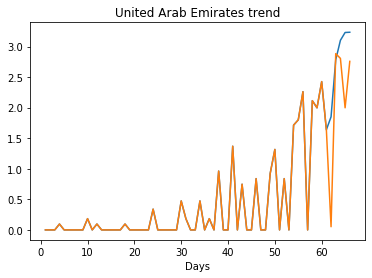

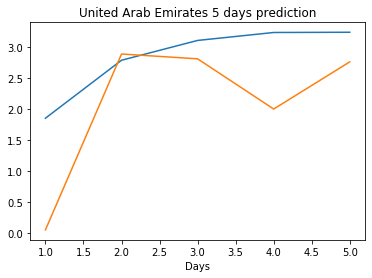

Creating directory ./offline7/India/training/
India
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0051
train error: 0.0009553351791206903
0.005133583676069975
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0066
train error: 0.0008258819999658347
0.006616963539272547
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0087
train error: 0.0011081380287578213
0.008653405122458935
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0058
train error: 0.0009357547220133711
0.005834067240357399
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [13],

train error: 0.0010020221338209012
0.007009039167314768
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0087
train error: 0.0011081380287578213
0.008653405122458935
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0055
train error: 0.000846597724739695
0.005539098288863897
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0060
train error: 0.0009296158727617391
0.0060111708007752895
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0079
train error: 0.0011081380287578213
0.007852519862353802
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0064
train error: 0.0009288232246035477
0.00636519119143486
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0073
train error: 0.0009955597526944378
0.00731987738981843
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0060
train error: 0.0008106883138680132
0.006003882270306349
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0085
train error: 0.001001508800557834
0.00851370207965374
Saving the

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0061
train error: 0.0008524511501794526
0.006092847790569067
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0069
train error: 0.0009456804139820937
0.006874867714941502
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0065
train error: 0.0009447967967086394
0.006502381060272455
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0096
Saving the

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0064
train error: 0.00101079448092302
0.006449292879551649
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0054
train error: 0.0007837820582305236
0.005391900893300772
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0053
train error: 0.000758916405175114
0.005302877631038427
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0063
train error: 0.000921418178525831
0.006265429314225912
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0119
Saving the best model weights at

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0078
Saving the best model weights at Epo

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0022
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0056
Saving the best model weights at E

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0075
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0100
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0095
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0089
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0089
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0060
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0060
train error: 0.0010026614643720677
0.006012172903865576
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0087
train error: 0.0011081380287578213
0.008653405122458935
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0058
Sa

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0103
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0101
Saving the best model weights at E

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0085
train error: 0.001002450726537063
0.008513404987752438
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [12], Best Valid L

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0130
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0037
train error: 0.004957282958397021
0.003720786888152361
Saving the best model weights at Epoch [1], Best

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0037
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0057
train error: 0.001589451093847553
0.005730275996029377
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0021
train error: 0.002963083120024142
0.002072454197332263
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0054
train error: 0.001097096789938708
0.0054357824847102165
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0087
train error: 0.0011081380287578213
0.008653405122458935
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0187
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0184
Saving the best model weights 

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0010
Saving the best model weights at E

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0082
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0057
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0061
train error: 0.0015465499775018543
0.006141692399978638
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0026
train error: 0.0012922199442982675
0.00258070859

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0038
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0082
train error: 0.0009362180184931883
0.008234120905399323
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0054
train error: 0.002160888211801648
0.005360560026019812
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0017
train error: 0.0021398854247915247
0.0016789246583357453
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0055
train error: 0.000965767381421756
0.005493061617016792
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0044
Saving the best model weigh

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0167
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0071
train error: 0.004233819533449908
0.007090121041983366
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [5], Best Val

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0089
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0089
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0085
Saving the best model weights at Ep

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0078
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0116
train error: 0.016161446738988162
0.01163411419838667
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [7], Best Valid 

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0076
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0103
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0103
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0103
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0103
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0103
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0103
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0041
train error: 0.0036741804079307864
0.004093254916369915
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [10], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0093
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0116
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0090
train error: 0.002603532059583813
0.00897238776087761
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0036
train error: 0.003459890877517561
0.0036241859197616577
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0079
Sav

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0056
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0068
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0065
train error: 0.010731622964764634
0.006506426725536585
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [10], Best Valid L

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0081
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0109
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0046
train error: 0.008742375019937753
0.004649240989238024
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [8], Best Valid 

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0074
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0054
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0073
train error: 0.0014654234730793784
0.007262283470481634
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [9], Best Valid 

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0083
Saving the best model weights at E

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0078
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0074
train error: 0.002090781678756078


Saving the best model weights at Epoch [4], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0192
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0192
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0192
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0192
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0087
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0111
train error: 0.006156467095327874
0.011072905734181404
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [2], Best 

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0036
train error: 0.008249625602426628
0.0036270630080252886
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [10], Best Valid 

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0059
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0055
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0066
train error: 0.011108597181737423
0.006609709467738867
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0078
train error: 0.0011479575414947854
0.007790162693709135
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0031


Saving the best model weights at Epoch [10], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0032
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0096
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0056
train error: 0.01106167941664656
0.005555292591452599
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [6], Best Valid

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0059
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0062
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0091
train error: 0.001625631988281384
0.009063530713319778
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [7], Best Valid

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0111
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0091
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0073
train error: 0.005082494505525877
0.007290546782314777
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [5], Best Val

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0086
Saving the best model weights at Epoc

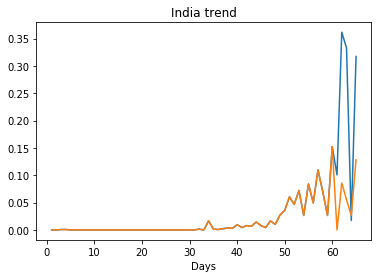

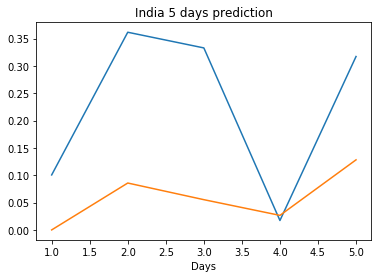

Creating directory ./offline7/Nepal/training/
Nepal
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0004
train error: 9.50560934078177e-05
0.00039982967427931726
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0003
train error: 9.702681069581689e-05
0.00030159784364514053
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
train error: 9.760514949448406e-05
0.00045549069182015955
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0005
train error: 9.59392754

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0004
train error: 9.563020405656581e-05
0.0004021140921395272
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
train error: 9.760514949448406e-05
0.00045549069182015955
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0004
train error: 9.249900672979753e-05
0.00036609938251785934
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0003
train error: 9.223974048576825e-05
0.00033039497793652117
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
train error: 9.760514949448406e-05
0.00045549069182015955
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0004
Saving the best model weights

train error: 9.229738977540234e-05
0.00039300444768741727
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0004
train error: 9.42337774891452e-05
0.0003686442505568266
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0004
train error: 9.447609110273853e-05
0.00041291676461696625
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0029
Saving the b

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0000
train error: 9.487224792792404e-05
2.5244453354389407e-05
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
train error: 9.760514949448406e-05
0.00045549069182015955
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0005


Saving the best model weights at Epoch [22], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0005
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0005
train error: 9.405654816094153e-05
0.0004592264594975859
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [9], Best Valid

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0005
Saving the best model weights at E

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0002
train error: 9.268774610973196e-05
0.00020519520330708474
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0004
train error: 9.433052811281024e-05
0.0003766484442166984
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005


Saving the best model weights at Epoch [37], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0009
train error: 0.000837575936956065


Saving the best model weights at Epoch [40], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0007
train error: 0.0007466206098927484
0.0007361969328485429
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [3], Best

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0009
Saving the best model weights at E

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0008
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0018
Saving the best model weights at Ep

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0008
Saving the best model weights at E

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0101
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0095
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0085
Saving the best model weights at E

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0001
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0006
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0002
train error: 0.00011644056908802928
0.0002277734747622162
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [7], Best Valid

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0006
train error: 0.0006165239943324455
0.0005831836024299264
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0060
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [13], Best Valid

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0005
train error: 0.00034693669087053943
0.0004865315859206021
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0003
train error: 9.621695999157964e-05
0.0003090061654802412
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0016


Saving the best model weights at Epoch [8], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0018
Saving the best model weights at Epo

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0015
Saving the best model weights at Epoc

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0007
Saving the best model weights at E

Saving the best model weights at Epoch [18], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0049
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0052
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0037
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0004
train error: 0.0007691170571238867
0.000426026206696406
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [2], Best

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0022
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0093
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0030
train error: 0.0034010461099179727
0.003001963021233678
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0101
Saving the best model weights at Epoch [5], Best Va

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0004
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0027
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0006
train error: 0.0005016562054931586
0.0005822502425871789
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [10], Best Valid

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0103
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0100
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0094
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0018
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0009
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0001
train error: 0.0005931930782805597

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0257
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0175
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0012
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0028
train error: 0.00227811759603875
0.0028071741107851267
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [4], Best Va

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0019
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0004
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0045
train error: 0.003987582633271813
0.004483913537114859
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [6], Best Vali

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0008
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0014
Saving the best model weights at E

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0010
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0135
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0163
train error: 0.015676543196397167
0.01629103533923626
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [12], Best Valid Lo

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0026
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0011
train error: 0.0025219337449276023

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0014
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0159
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0063
train error: 0.006362838031990187
0.006313987076282501
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [4], Best Va

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0005
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0015
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0025
train error: 0.002418454425475959
0.0025217561051249504
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [10], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0160
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0108
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0093
train error: 0.01091816650171365
0.009305487386882305
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [11], Best Valid Lo

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0036
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0006
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0119
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0116
train error: 0.01296948612268482
0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0006
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0031
train error: 0.004527892298730356
0.00314119691029191
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [2], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0016
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0036
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0015
train error: 0.0010204048785713634
0.0015019051497802138
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [2], Bes

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0144
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0088
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0024
train error: 0.0019437918256569122
0.002431088825687766
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0002
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0020
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0007
train error: 0.0011720330088532396
0.0007150106248445809
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [9], Best Valid

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0021
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0030
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0073
train error: 0.0076881745297993935
0.007346530444920063
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [12], Best Valid 

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0007
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0202
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0054
train error: 0.0049043833810303895
0.005383541341871023
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [13], Best Valid 

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0073
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0011
Saving the best model weights at E

train error: 9.760514949448406e-05
0.00045549069182015955
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [14], Best Vali

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0462
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0002
train error: 0.0003942943149013445

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0021
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0001
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0001
train error: 0.0009440873533354274
0.00011783708032453433
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
train error: 9.720888587543592e-05
0.0004555045161396265
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [2], Best Valid Loss

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0003
Saving the best model weights at Epoch

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0043
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0027
train error: 0.0031697574138109174
0.0027454036753624678
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [6], Best Va

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0011
Saving the best model weights at E

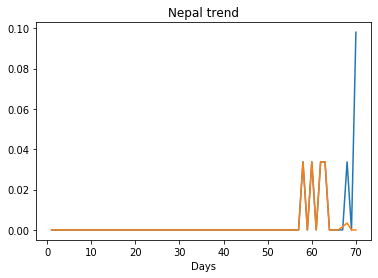

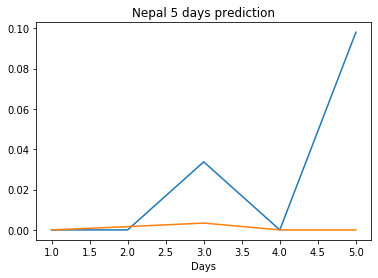

Creating directory ./offline7/Sri Lanka/training/
Sri Lanka
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0223
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0149
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0147
train error: 0.02926806083908587
0.0147012984380126
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0150

Saving the best model weights at Epoch [18], Best Valid Loss: 0.0214
train error: 0.03816656963053075
0.02144867181777954
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0322
train error: 0.04571401303683436
0.03215787559747696
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0192
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0186
train error: 0.0395941229918125
0.018554482609033585
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0278
Saving the best model

train error: 0.04571401303683436
0.03155892342329025
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0309
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0308
train error: 0.04253605338321491
0.03075268678367138
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0221
train error: 0.040215121038878955
0.022101862356066704
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0302
train error: 0.045714

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0174
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0169
Saving the best model weights at Epoch 

train error: 0.035527425281929245
0.010133447125554085
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0260
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [20], Best Valid L

Saving the best model weights at Epoch [18], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0147
train error: 0.03664739995799733
0.014666388742625713
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0252
train error: 0.03966757258626096
0.025195403024554253
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0139

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0173
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0178
Saving the best model weights at E

train error: 0.037248073470298994
0.02141670696437359
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0326
train error: 0.03931508913184657
0.032564472407102585
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0267
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0234
Savin

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0287
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0141
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [18

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0129
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0203
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0293
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0293
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0293
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0292
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0292
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0291
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0291
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0291
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0290
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0290
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0290
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0289
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0315
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0230
Saving the best model weights at E

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0309
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0309
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0306
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0306
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0305
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0267
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0260
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0247
Saving the best model weights at Ep

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0267
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0261
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0261
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0261
Saving the best model weights at E

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0095
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0071
Saving the best model weights at Epoch

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0352
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0349
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0342
train error: 0.039975023842557814
0.03418948873877525
Saving the best model weights at Epoch [1], Best Valid Lo

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0341
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0341
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0340
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0340
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0337
Saving the best model weights at E

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0241
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0349
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0349
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0345
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0342
Saving the best model weights at E

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0233
Saving the best model weights at E

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0280
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0269
Saving the best model weights at E

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0263
Saving the best model weights at E

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0309
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0306
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0306
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0303
Saving the best model weights at E

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0179
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0267
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0263
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0261
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0260
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0260
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0259
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0257
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0276
train error: 0.04295319428836757
0.027577100321650505
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0306
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [3], Best Va

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0312
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0271
train error: 0.039900576025529794
0.02709096670150757
Saving the best model weights at Epoch [1], Best 

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0192
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0188
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0225
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0258
train error: 0.03703986794095148
0.02576393447816372
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0145
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0341
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0341
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0341
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0341
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0329
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0329
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0329
train error: 0.04335712139392413
0.032854266464710236
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [7], Best Valid 

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0313
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0342
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0152
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0150
train error: 0.03151479552528172
0.014952740631997585
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [11], Best Valid Lo

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0184
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0224
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0421
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0421
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0420
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0420
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0420
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0419
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0419
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0419
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0416
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0261
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0259
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0257
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0232
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0187
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0185
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0298
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0298
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0297
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0297
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0295
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0295
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0293
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0252
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0100
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0100
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0100
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0099
train error: 0.03726636508310383
0.009896118193864822
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [6], Best Valid

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0312
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0237
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0288
train error: 0.041124597253546
0.02882746420800686
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0313
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0321
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0177
train error: 0.03689716759871579
0.017692450433969498
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [10], Best Valid Lo

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0208
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0315
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0231
train error: 0.03991299855635699
0.02313869632780552
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0326
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0326
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0326
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0311
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0316
train error: 0.04239045558708974
0.03159073367714882
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0367
Saving the best model weights at Epoch

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0106
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0272
train error: 0.04007238848840423
0.02720104530453682
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0290
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0236
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0284
train error: 0.040677017128363135
0.02841055393218994
Saving the best model weights at Epoch [1], Best 

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0354
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0201
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0237
train error: 0.03505336395888166
0.02370305173099041
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0301
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0381
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0328
train error: 0.04359853509672438
0.03278275579214096
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0338
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0289
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0240
train error: 0.04284620474120884
0.023958025500178337
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [10], Best Valid Lo

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0253
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0313
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0286
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0346
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0365
train error: 0.04565217628351437
0.03645708039402962
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [13], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0317
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0311
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0238
train error: 0.03415371102252693
0.023818325251340866
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0096
train error: 0.036713842528335976
0.009620621800422668
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0162
train error: 0.037203247687130264
0.016231102868914604
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0279
Saving the best mod

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0159
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0313
train error: 0.040860055838217675
0.031334441155195236
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0349
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0349
Saving the best model weights at Epoch [3], Best V

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0178
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0258
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0244
train error: 0.03851200310005383
0.02439293824136257
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0275
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0277
Saving the best model weights at E

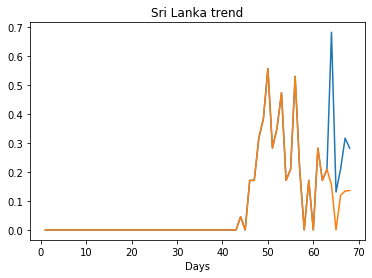

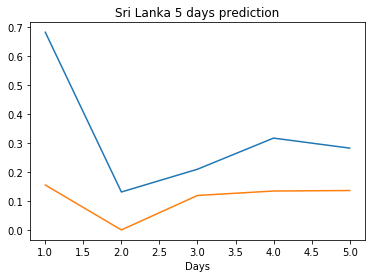

Creating directory ./offline7/Taiwan*/training/
Taiwan*
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1948
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1876
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1860
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1828
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1811
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1787
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1771
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1756
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1748
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1747
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1737
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1728
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1708
Saving the best model weights at Epoch [29], Best V

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0177
train error: 0.03619561121051543
0.017702607437968254
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1112
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1103
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1081
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1069
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1066
train error: 0.047149648919003084
0.1065954938530922
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1653
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1572
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1549
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1476
train error: 0.08635166449178207
0.14759670197963715
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1936
Saving the best mod

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0793
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0792
train error: 0.07136349181497567
0.07918459177017212
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1875
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1820
train error: 0.09424794097063377
0.18201260268688202
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1771
train error: 0.10205291119698238
0.17707504332065582
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1032
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0969
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0960
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0952
train error: 0.07042519625668463
0.0952097699046135
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0747
Saving the best model weights at Epoc

Saving the best model weights at Epoch [7], Best Valid Loss: 0.1763
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1745
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1730
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1716
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1707
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1699
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1693
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1686
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1680
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1676
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1672
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1668
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1665
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1661
Saving the best model weights at Epoc

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1547
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1545
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1543
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1541
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1539
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1539
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1537
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1534
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1532
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1530
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1527
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1525
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1523
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1522
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0702
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0700
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0695
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0692
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0688
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0681
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0677
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0675
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0673
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0670
train error: 0.06491163669546184
0.06703745573759079
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1693
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1591
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0715
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0687
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0664
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0656
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0648
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0642
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0624
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0618
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0614
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0607
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0596
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0583
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0577
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0567
Saving the best model weights at Epo

Saving the best model weights at Epoch [2], Best Valid Loss: 0.2085
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2081
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2079
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2077
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2074
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2073
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2072
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2072
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2071
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2071
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2070
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2070
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2070
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [12], Best Valid Loss: 0.1307
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1298
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1284
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1278
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1274
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1271
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1267
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1257
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1255
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1254
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1253
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.1577
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1571
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1563
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1555
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1553
train error: 0.08391309802812573
0.15525121986865997
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1564
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1541
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1539
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1526
train error: 0.08595796738212046
0.15261729061603546
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1851
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1730
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1636
Sav

Saving the best model weights at Epoch [7], Best Valid Loss: 0.1891
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1875
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1860
train error: 0.09553705025341754
0.18603388965129852
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1816
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1731
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1663
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1612
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1572
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1539
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1513
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1492
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1475
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1460
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [13], Best Valid Loss: 0.1760
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1756
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1752
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1749
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1747
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1744
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1744
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1742
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1741
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1740
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1739
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1738
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1737
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1737
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1553
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1530
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1513
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1498
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1485
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1478
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1464
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1459
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1454
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1450
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1446
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1444
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1441
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [21], Best Valid Loss: 0.1928
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1928
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1927
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1926
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1926
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1926
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1925
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1925
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1925
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1925
train error: 0.09451272656013698
0.19245906174182892
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2104
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2038
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1992
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [33], Best Valid Loss: 0.1570
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1566
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1561
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1557
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1554
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1550
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1545
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1542
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1539
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1536
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1532
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1525
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1522
Saving the best model weights at E

Saving the best model weights at Epoch [14], Best Valid Loss: 0.1745
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1739
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1733
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1728
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1717
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1713
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1708
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1704
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1699
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1695
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1692
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1687
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1684
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.2023
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2020
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2016
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2013
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2010
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2006
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2004
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2001
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1998
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1995
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1993
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1990
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1988
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1985
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1670
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1664
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1658
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1653
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1647
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1642
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1637
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1632
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1627
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1622
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1618
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1613
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1609
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1604
Saving the best model weights at E

Saving the best model weights at Epoch [18], Best Valid Loss: 0.1598
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1594
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1590
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1586
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1582
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1578
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1575
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1571
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1568
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1564
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1561
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1558
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1554
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1551
Saving the best model weights at E

Saving the best model weights at Epoch [21], Best Valid Loss: 0.1668
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1663
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1658
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1654
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1649
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1645
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1640
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1636
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1632
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1628
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1624
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1620
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1616
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1612
Saving the best model weights at E

Saving the best model weights at Epoch [12], Best Valid Loss: 0.1896
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1890
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1884
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1878
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1873
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1867
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1862
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1856
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1851
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1846
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1836
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1831
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1827
Saving the best model weights at E

Saving the best model weights at Epoch [5], Best Valid Loss: 0.1995
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1987
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1979
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1971
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1963
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1955
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1948
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1940
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1926
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1919
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1913
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1900
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [25], Best Valid Loss: 0.1599
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1596
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1592
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1590
train error: 0.08774324292071949
0.1589674949645996
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2067
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2067
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2067
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2066
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2066
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2066
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2066
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2065
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2065
Saving the best model weights at Epoch [10], Best Valid Loss

Saving the best model weights at Epoch [14], Best Valid Loss: 0.1646
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1640
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1635
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1624
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1619
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1613
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1609
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1604
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1599
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1594
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1590
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1585
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1581
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.1739
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1729
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1719
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1710
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1700
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1691
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1682
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1674
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1665
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1657
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1648
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1641
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1633
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1625
Saving the best model weights at Ep

Saving the best model weights at Epoch [4], Best Valid Loss: 0.1858
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1848
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1839
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1830
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1820
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1812
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1803
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1795
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1787
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1779
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1771
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1763
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1756
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1749
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [35], Best Valid Loss: 0.1096
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1087
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1087
train error: 0.06845578171410843
0.10873838514089584
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1717
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1702
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1688
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1674
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1661
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1648
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1635
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1623
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1611
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1599
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [15], Best Valid Loss: 0.1687
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1682
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1680
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1678
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1676
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1671
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1669
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1667
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1665
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1663
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1662
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1660
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.1911
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1903
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1896
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1889
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1883
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1876
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1863
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1857
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1851
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1845
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1839
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1834
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1828
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [26], Best Valid Loss: 0.1926
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1924
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1924
train error: 0.09447332681769408
0.1923680603504181
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1976
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1955
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1914
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1895
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1876
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1857
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1839
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1821
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1804
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [15], Best Valid Loss: 0.1462
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1457
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1450
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1442
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1442
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1439
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1435
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1427
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1426
train error: 0.07416420186085529
0.14256994426250458
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1061
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1059
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1058
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [31], Best Valid Loss: 0.1553
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1547
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1542
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1536
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1531
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1525
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1520
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1515
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1510
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1505
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1501
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1492
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1487
Saving the best model weights at E

Saving the best model weights at Epoch [23], Best Valid Loss: 0.1761
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1754
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1747
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1741
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1734
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1728
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1715
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1710
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1704
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1698
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1693
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1687
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1682
Saving the best model weights at E

Saving the best model weights at Epoch [15], Best Valid Loss: 0.1991
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1982
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1974
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1965
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1957
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1949
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1942
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1927
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1920
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1913
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1899
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1893
Saving the best model weights at E

Saving the best model weights at Epoch [11], Best Valid Loss: 0.1393
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1392
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1392
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1391
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1391
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1391
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1389
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1389
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1389
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1388
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1388
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1387
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.1254
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1250
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1242
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1240
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1237
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1233
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1231
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1230
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1226
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1224
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1221
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1219
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.1636
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1635
train error: 0.08352256863451514
0.16350430250167847
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2093
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2092
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2092
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2091
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2091
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2090
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2090
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2089
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2089
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2088
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2088
Saving the best model weights at Epoch [12], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.1797
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1796
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1795
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1794
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1793
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1792
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1791
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1790
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1789
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1788
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1787
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1786
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1785
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1784
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.2060
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2060
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2060
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2059
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2059
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2059
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2059
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2058
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2058
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2058
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2057
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2057
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2057
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2057
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1556
train error: 0.0859092585865016
0.15557436645030975
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1412
train error: 0.08736445789078348
0.14123833179473877
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1785
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1763
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1743
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1701
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1663
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1645
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1626
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1606
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1590
Saving th

Saving the best model weights at Epoch [16], Best Valid Loss: 0.1993
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1992
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1991
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1990
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1989
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1988
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1987
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1986
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1985
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1984
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1983
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1982
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1981
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1980
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1754
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1752
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1750
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1748
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1746
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1744
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1743
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1741
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1739
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1737
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1735
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1734
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1732
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1730
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.2200
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2199
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2198
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2198
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2197
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2196
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2196
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2195
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2194
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2193
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2193
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2192
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2191
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2191
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [17], Best Valid Loss: 0.1685
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1685
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1683
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1683
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1683
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1683
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1682
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1682
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1682
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.1426
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1424
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1424
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1424
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1422
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1422
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1421
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1420
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1419
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1418
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1418
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1418
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1417
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1416
train error: 0.07753274315281918
0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.1956
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1947
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1940
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1924
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1917
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1904
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1897
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1890
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1883
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1878
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1870
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1865
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1931
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1929
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1928
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1927
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1925
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1924
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1923
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1922
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1920
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1919
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1918
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1916
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.1734
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1733
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1731
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1730
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1728
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1727
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1726
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1724
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1720
train error: 0.08047745114163263
0.17201898992061615
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1792
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1789
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [7], Best Valid Loss: 0.1534
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1532
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1531
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1531
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1530
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1530
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1529
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1527
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1527
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1526
Saving the best model weights at Epoc

Saving the best model weights at Epoch [26], Best Valid Loss: 0.1766
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1760
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1754
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1747
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1742
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1736
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1730
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1726
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1718
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1713
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1707
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1702
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1698
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1693
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.1556
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1553
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1550
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1547
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1544
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1541
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1538
train error: 0.07475463636096959
0.15381114184856415
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1815
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1809
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1805
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1801
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1796
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1792
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [11], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2034
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2034
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2031
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2031
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2030
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.1976
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1974
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1973
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1972
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1971
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1969
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1968
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1967
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1966
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1964
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1963
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1962
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1961
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1960
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.1874
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1872
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1869
train error: 0.0866802888401588
0.1869044303894043
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1751
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [16], Best Valid Loss: 0.1942
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1940
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1939
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1939
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1938
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1937
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1936
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1935
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1935
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1931
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1950
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1950
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1950
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1950
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1950
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1950
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1892
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1889
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1887
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1884
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1882
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1879
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1877
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1874
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1866
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1864
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1862
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1859
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.2027
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2026
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2025
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2023
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2022
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2020
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2019
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2017
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2016
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2015
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2013
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2012
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2010
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2009
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.1937
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1929
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1926
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1923
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1919
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1915
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1912
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1909
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1902
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1899
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1896
train error: 0.08759422165243641
0.18959252536296844
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [5], Best Valid Loss: 0.1848
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1848
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1847
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1847
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1847
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1846
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1846
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1846
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1845
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1845
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1845
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1844
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1844
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1844
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1870
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1870
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1870
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1870
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1868
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1868
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1868
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1868
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1868
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.1930
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1930
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1930
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1930
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1930
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1930
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1930
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1930
train error: 0.0870504394942576
0.1929706186056137
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1807
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1806
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1806
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1806
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1806
Saving the best model weights at Epoch [6], Best Valid Lo

Saving the best model weights at Epoch [11], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1932
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.2008
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2007
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2006
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2005
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2004
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2003
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2002
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2001
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2000
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1999
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1999
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1998
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1997
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1996
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.1382
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1382
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1382
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1382
train error: 0.08150634189185343
0.13818565011024475
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1740
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1740
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1740
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1739
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1739
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1738
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1738
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1738
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1737
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [14], Best Valid Loss: 0.1581
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1581
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1580
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1579
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1579
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1579
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.1955
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1954
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1954
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1954
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1954
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1953
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1953
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1953
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1952
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1952
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1952
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1952
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1951
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1951
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.2036
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2036
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2035
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2034
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2034
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [20], Best Valid Loss: 0.2092
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2092
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2091
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2091
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2091
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2090
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2090
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2090
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2089
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2089
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2089
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2088
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2088
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2088
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.1410
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1410
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1410
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1409
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1409
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1409
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1408
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1408
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1408
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1408
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1407
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1407
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1407
train error: 0.08650993896452219
0.14066092669963837
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [5], Best Valid Loss: 0.1702
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1702
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1701
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1701
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1701
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1701
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1700
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1700
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1700
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1700
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1699
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1699
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1699
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1699
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2032
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.1937
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1937
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1936
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1935
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1934
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1933
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1932
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1931
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1931
train error: 0.09082959847843372
0.19307100772857666
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2037
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2037
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2037
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [8], Best Valid Loss: 0.2056
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2056
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2055
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2054
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2054
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2053
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2052
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2052
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2050
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2049
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2049
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2048
Saving the best model weights at Epo

Saving the best model weights at Epoch [24], Best Valid Loss: 0.1439
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1438
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1438
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1438
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1437
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1437
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1437
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1436
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1436
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1436
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1435
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1435
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1435
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1434
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.1961
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1961
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1961
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1961
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1961
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1960
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1960
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1960
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1960
train error: 0.0932205319879454
0.19599950313568115
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0965
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0965
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0964
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0964
Saving the best model weights at Epoch [5], Best Valid 

Saving the best model weights at Epoch [8], Best Valid Loss: 0.2044
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2041
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2040
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2038
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2037
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2036
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2034
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2033
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2032
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2029
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2028
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2026
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1904
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1904
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1904
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1904
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1903
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1903
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1533
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1533
train error: 0.08760400992622108
0.15325473248958588
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1610
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1610
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1610
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1610
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1610
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1610
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [12], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2075
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2074
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2074
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2074
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2074
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2074
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2074
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.1587
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1586
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1586
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1585
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1585
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1585
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1584
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1584
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1584
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1583
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1583
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1583
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1582
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1582
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.1953
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1953
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1953
train error: 0.08969749850343521
0.19527629017829895
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1915
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1915
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1914
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1914
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1913
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1912
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1912
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1911
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [15], Best Valid Loss: 0.2062
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2062
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2062
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2062
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2061
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2061
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2061
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2061
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2061
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2060
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2060
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2060
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2060
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2060
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1945
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.1700
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1700
train error: 0.07930187833507692
0.16999347507953644
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1629
Saving the best model weights at Epoch [12], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1380
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1380
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1380
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1380
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1380
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2051
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2051
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.1907
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1907
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1905
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1904
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [22], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1091
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1723
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1723
train error: 0.08617764889679261
0.17232941091060638
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1815
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1815
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [7], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2102
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2101
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2101
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2101
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2101
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2101
Saving the best model weights at Epoc

Saving the best model weights at Epoch [26], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1562
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1561
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1561
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1561
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1561
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1561
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1561
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.2136
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2136
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2136
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2136
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2136
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2136
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2136
train error: 0.09793463101653431
0.21360325813293457
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [10], Best Valid Loss: 0.1758
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1758
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1758
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1758
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1758
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1758
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1758
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1757
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1757
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1757
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1757
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1757
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1757
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1757
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1673
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1672
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1672
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1672
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1672
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.1978
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1978
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1978
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1978
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1978
train error: 0.0904494873539079
0.19779209792613983
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1841
Saving the best model weights at Epoch [9], Best Valid Loss

Saving the best model weights at Epoch [13], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1869
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.2069
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2069
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2068
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2067
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.1613
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1613
train error: 0.0840344158748753
0.16132444143295288
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1783
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1910
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1546
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1546
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2114
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [22], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2042
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2042
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1208
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1208
train error: 0.08249151236132572
0.12077505886554718
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1217
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1217
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1217
Saving the best model weights at Epoch [5], Best Vali

Saving the best model weights at Epoch [11], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1722
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1871
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1871
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.1892
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1892
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1892
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1892
train error: 0.0909000987165583
0.18917402625083923
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2030
Saving the best model weights at Epoch [10], Best Valid Loss

Saving the best model weights at Epoch [14], Best Valid Loss: 0.1947
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1947
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1947
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1947
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1947
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1947
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1946
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1946
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1946
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1946
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1946
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1946
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1946
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1946
Saving the best model weights at E

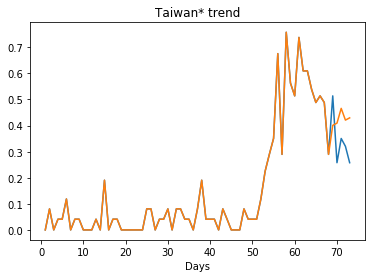

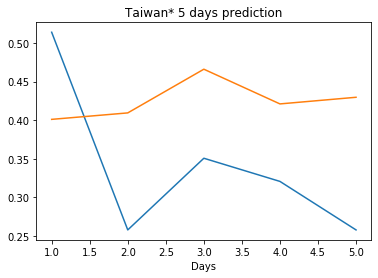

Creating directory ./offline7/Korea, South/training/
Korea, South
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5887
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5684
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5664
train error: 1.1061377680223239
0.566410481929779
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1988
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0659
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0600
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0379
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0364
train error: 0.16337857863522673
0.036384206265211105
Saving the best model weights at Epoch [1], Best Valid Loss: 0.6072
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5836
Saving the be

Saving the best model weights at Epoch [6], Best Valid Loss: 0.9284
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4860
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4824
train error: 1.0855891533980244
0.48244163393974304
Saving the best model weights at Epoch [1], Best Valid Loss: 1.3378
Saving the best model weights at Epoch [2], Best Valid Loss: 1.2906
Saving the best model weights at Epoch [3], Best Valid Loss: 1.2670
Saving the best model weights at Epoch [4], Best Valid Loss: 1.2621
Saving the best model weights at Epoch [6], Best Valid Loss: 1.2508
train error: 2.0308974934251687
1.2508193254470825
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1171
Saving the best model weights at Epoch [2], Best Valid Loss: 0.6594
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5643
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5501
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5027
Saving the b

Saving the best model weights at Epoch [15], Best Valid Loss: 0.5678
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5598
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5419
train error: 1.0940214432775974
0.5418774485588074
Saving the best model weights at Epoch [1], Best Valid Loss: 0.6084
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4228
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4026
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1772
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0577
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0469
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0124
train error: 0.22544308580262096
0.012350140139460564


Saving the best model weights at Epoch [6], Best Valid Loss: 1.0017
Saving the best model weights at Epoch [7], Best Valid Loss: 0.9375
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9252
Saving the best model weights at Epoch [15], Best Valid Loss: 0.8575
Saving the best model weights at Epoch [16], Best Valid Loss: 0.7536
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5747
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4831
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4475
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4329
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4326
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4303
train error: 1.1603354435218007
0.43028679490089417
Saving the best model weights at Epoch [1], Best Valid Loss: 1.3292
Saving the best model weights at Epoch [2], Best Valid Loss: 0.9438
Saving the best model weights at Epoch [3], Best Valid L

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1805
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1158
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0803
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0551
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0490
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0488
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0371
train error: 0.1741111434040297
0.0370609425008297
Saving the best model weights at Epoch [1], Best Valid Loss: 1.8421
Saving the best model weights at Epoch [2], Best Valid Loss: 1.3238
Saving the best model weights at Epoch [3], Best Valid Loss: 0.9835
Saving the best model weights at Epoch [4], Best Valid Loss: 0.7697
Saving the best model weights at Epoch [5], Best Valid Loss: 0.6482
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5852
Saving the best model weights at Epoch [7], Best Valid Loss: 0

Saving the best model weights at Epoch [17], Best Valid Loss: 1.5852
Saving the best model weights at Epoch [21], Best Valid Loss: 1.5799
Saving the best model weights at Epoch [23], Best Valid Loss: 1.5701
Saving the best model weights at Epoch [25], Best Valid Loss: 1.5545
Saving the best model weights at Epoch [26], Best Valid Loss: 1.5536
Saving the best model weights at Epoch [27], Best Valid Loss: 1.5432
Saving the best model weights at Epoch [29], Best Valid Loss: 1.5403
Saving the best model weights at Epoch [40], Best Valid Loss: 1.5393
train error: 2.9488503070254075
1.5393062829971313
Saving the best model weights at Epoch [1], Best Valid Loss: 2.6138
train error: 4.8075031575403715
2.6137638092041016
Saving the best model weights at Epoch [1], Best Valid Loss: 2.0473
Saving the best model weights at Epoch [2], Best Valid Loss: 1.8437
Saving the best model weights at Epoch [3], Best Valid Loss: 1.7783
Saving the best model weights at Epoch [4], Best Valid Loss: 1.7758
train 

Saving the best model weights at Epoch [9], Best Valid Loss: 1.4499
Saving the best model weights at Epoch [10], Best Valid Loss: 1.4497
train error: 3.2007286862323157
1.4496581554412842
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3009
Saving the best model weights at Epoch [2], Best Valid Loss: 2.1589
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1045
Saving the best model weights at Epoch [4], Best Valid Loss: 2.0876
train error: 3.9478014252687754
2.0876388549804688
Saving the best model weights at Epoch [1], Best Valid Loss: 1.5698
train error: 3.2010150316514467
1.5697500705718994
Saving the best model weights at Epoch [1], Best Valid Loss: 1.9632
Saving the best model weights at Epoch [2], Best Valid Loss: 1.8781
Saving the best model weights at Epoch [3], Best Valid Loss: 1.7943
Saving the best model weights at Epoch [4], Best Valid Loss: 1.7115
Saving the best model weights at Epoch [5], Best Valid Loss: 1.6309
Saving the best model weights 

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0494
train error: 0.20488059867516553
0.049375902861356735
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3336
Saving the best model weights at Epoch [2], Best Valid Loss: 2.2336
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1295
Saving the best model weights at Epoch [4], Best Valid Loss: 2.0223
Saving the best model weights at Epoch [5], Best Valid Loss: 1.9189
Saving the best model weights at Epoch [6], Best Valid Loss: 1.8193
Saving the best model weights at Epoch [7], Best Valid Loss: 1.7243
Saving the best model weights at Epoch [8], Best Valid Loss: 1.6266
Saving the best model weights at Epoch [9], Best Valid Loss: 1.5286
Saving the best model weights at Epoch [10], Best Valid Loss: 1.4196
Saving the best model weights at Epoch [11], Best Valid Loss: 1.3043
Saving the best model weights at Epoch [12], Best Valid Loss: 1.1953
Saving the best model weights at Epoch [13], Best Valid Lo

Saving the best model weights at Epoch [18], Best Valid Loss: 0.5620
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5467
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5423
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5416
train error: 1.147672160871719
0.5416126847267151
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3066
Saving the best model weights at Epoch [2], Best Valid Loss: 2.1302
Saving the best model weights at Epoch [3], Best Valid Loss: 1.9160
Saving the best model weights at Epoch [4], Best Valid Loss: 1.7032
Saving the best model weights at Epoch [5], Best Valid Loss: 1.4982
Saving the best model weights at Epoch [6], Best Valid Loss: 1.3018
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1171
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9460
Saving the best model weights at Epoch [9], Best Valid Loss: 0.7904
Saving the best model weights at Epoch [10], Best Valid Loss: 

Saving the best model weights at Epoch [9], Best Valid Loss: 1.3411
Saving the best model weights at Epoch [10], Best Valid Loss: 1.2797
Saving the best model weights at Epoch [11], Best Valid Loss: 1.2231
Saving the best model weights at Epoch [12], Best Valid Loss: 1.1710
Saving the best model weights at Epoch [13], Best Valid Loss: 1.1244
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0805
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0416
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0051
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9722
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9425
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9152
Saving the best model weights at Epoch [20], Best Valid Loss: 0.8907
Saving the best model weights at Epoch [21], Best Valid Loss: 0.8688
Saving the best model weights at Epoch [22], Best Valid Loss: 0.8489
Saving the best model weights at Ep

Saving the best model weights at Epoch [29], Best Valid Loss: 0.9926
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9827
Saving the best model weights at Epoch [31], Best Valid Loss: 0.9737
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9656
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9584
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9522
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9467
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9423
Saving the best model weights at Epoch [37], Best Valid Loss: 0.9382
Saving the best model weights at Epoch [38], Best Valid Loss: 0.9348
Saving the best model weights at Epoch [39], Best Valid Loss: 0.9319
Saving the best model weights at Epoch [40], Best Valid Loss: 0.9297
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9279
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9264
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 1.0102
Saving the best model weights at Epoch [39], Best Valid Loss: 1.0095
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0093
train error: 2.311093776045661
1.0093268156051636
Saving the best model weights at Epoch [1], Best Valid Loss: 1.9572
Saving the best model weights at Epoch [2], Best Valid Loss: 1.4751
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1428
Saving the best model weights at Epoch [4], Best Valid Loss: 0.9362
Saving the best model weights at Epoch [5], Best Valid Loss: 0.8128
Saving the best model weights at Epoch [6], Best Valid Loss: 0.7557
Saving the best model weights at Epoch [7], Best Valid Loss: 0.7338
Saving the best model weights at Epoch [41], Best Valid Loss: 0.7336
Saving the best model weights at Epoch [42], Best Valid Loss: 0.7325
Saving the best model weights at Epoch [43], Best Valid Loss: 0.7322
Saving the best model weights at Epoch [44], Best Valid Loss

Saving the best model weights at Epoch [6], Best Valid Loss: 1.5079
Saving the best model weights at Epoch [7], Best Valid Loss: 1.4766
Saving the best model weights at Epoch [8], Best Valid Loss: 1.4605
Saving the best model weights at Epoch [9], Best Valid Loss: 1.4522
Saving the best model weights at Epoch [10], Best Valid Loss: 1.4499
Saving the best model weights at Epoch [34], Best Valid Loss: 1.4493
Saving the best model weights at Epoch [35], Best Valid Loss: 1.4488
Saving the best model weights at Epoch [36], Best Valid Loss: 1.4484
Saving the best model weights at Epoch [37], Best Valid Loss: 1.4483
Saving the best model weights at Epoch [43], Best Valid Loss: 1.4044
Saving the best model weights at Epoch [44], Best Valid Loss: 1.2672
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1493
Saving the best model weights at Epoch [46], Best Valid Loss: 1.0707
Saving the best model weights at Epoch [47], Best Valid Loss: 1.0165
Saving the best model weights at Epoch

Saving the best model weights at Epoch [1], Best Valid Loss: 1.9039
Saving the best model weights at Epoch [2], Best Valid Loss: 1.5412
Saving the best model weights at Epoch [3], Best Valid Loss: 1.3152
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1478
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0553
Saving the best model weights at Epoch [6], Best Valid Loss: 0.9893
Saving the best model weights at Epoch [7], Best Valid Loss: 0.9519
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9319
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9236
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9230
train error: 2.337723946885059
0.9229527711868286
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3230
Saving the best model weights at Epoch [2], Best Valid Loss: 2.2596
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1985
Saving the best model weights at Epoch [4], Best Valid Loss: 2.14

Saving the best model weights at Epoch [16], Best Valid Loss: 1.3890
Saving the best model weights at Epoch [17], Best Valid Loss: 1.3416
Saving the best model weights at Epoch [18], Best Valid Loss: 1.2961
Saving the best model weights at Epoch [19], Best Valid Loss: 1.2526
Saving the best model weights at Epoch [20], Best Valid Loss: 1.2107
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1706
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1323
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0954
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0601
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0262
Saving the best model weights at Epoch [26], Best Valid Loss: 0.9939
Saving the best model weights at Epoch [27], Best Valid Loss: 0.9629
Saving the best model weights at Epoch [28], Best Valid Loss: 0.9331
Saving the best model weights at Epoch [29], Best Valid Loss: 0.9049
Saving the best model weights at E

Saving the best model weights at Epoch [24], Best Valid Loss: 0.7522
Saving the best model weights at Epoch [25], Best Valid Loss: 0.7111
Saving the best model weights at Epoch [26], Best Valid Loss: 0.6718
Saving the best model weights at Epoch [27], Best Valid Loss: 0.6343
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5985
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5643
Saving the best model weights at Epoch [30], Best Valid Loss: 0.5318
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5008
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4711
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4430
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3906
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3663
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3434
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 2.2418
Saving the best model weights at Epoch [36], Best Valid Loss: 2.2398
Saving the best model weights at Epoch [37], Best Valid Loss: 2.2379
Saving the best model weights at Epoch [38], Best Valid Loss: 2.2362
Saving the best model weights at Epoch [39], Best Valid Loss: 2.2347
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2333
Saving the best model weights at Epoch [41], Best Valid Loss: 2.2320
Saving the best model weights at Epoch [42], Best Valid Loss: 2.2309
Saving the best model weights at Epoch [43], Best Valid Loss: 2.2299
Saving the best model weights at Epoch [44], Best Valid Loss: 2.2290
Saving the best model weights at Epoch [45], Best Valid Loss: 2.2283
Saving the best model weights at Epoch [46], Best Valid Loss: 2.2277
Saving the best model weights at Epoch [47], Best Valid Loss: 2.2271
Saving the best model weights at Epoch [48], Best Valid Loss: 2.2267
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 1.9850
Saving the best model weights at Epoch [50], Best Valid Loss: 1.9811
train error: 4.114068934791966
1.9810783863067627
Saving the best model weights at Epoch [1], Best Valid Loss: 2.2286
Saving the best model weights at Epoch [2], Best Valid Loss: 2.0854
Saving the best model weights at Epoch [3], Best Valid Loss: 1.9511
Saving the best model weights at Epoch [4], Best Valid Loss: 1.8270
Saving the best model weights at Epoch [5], Best Valid Loss: 1.7111
Saving the best model weights at Epoch [6], Best Valid Loss: 1.6037
Saving the best model weights at Epoch [7], Best Valid Loss: 1.5039
Saving the best model weights at Epoch [8], Best Valid Loss: 1.4124
Saving the best model weights at Epoch [9], Best Valid Loss: 1.3236
Saving the best model weights at Epoch [10], Best Valid Loss: 1.2458
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1699
Saving the best model weights at Epoch [12], Best Valid Loss: 

Saving the best model weights at Epoch [9], Best Valid Loss: 1.9567
Saving the best model weights at Epoch [10], Best Valid Loss: 1.9130
Saving the best model weights at Epoch [11], Best Valid Loss: 1.8713
Saving the best model weights at Epoch [12], Best Valid Loss: 1.8332
Saving the best model weights at Epoch [13], Best Valid Loss: 1.7973
Saving the best model weights at Epoch [14], Best Valid Loss: 1.7645
Saving the best model weights at Epoch [15], Best Valid Loss: 1.7335
Saving the best model weights at Epoch [16], Best Valid Loss: 1.7055
Saving the best model weights at Epoch [17], Best Valid Loss: 1.6787
Saving the best model weights at Epoch [18], Best Valid Loss: 1.6542
Saving the best model weights at Epoch [19], Best Valid Loss: 1.6307
Saving the best model weights at Epoch [20], Best Valid Loss: 1.6099
Saving the best model weights at Epoch [21], Best Valid Loss: 1.5899
Saving the best model weights at Epoch [22], Best Valid Loss: 1.5720
Saving the best model weights at Ep

Saving the best model weights at Epoch [14], Best Valid Loss: 1.0562
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0045
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9563
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9121
Saving the best model weights at Epoch [18], Best Valid Loss: 0.8731
Saving the best model weights at Epoch [19], Best Valid Loss: 0.8357
Saving the best model weights at Epoch [20], Best Valid Loss: 0.8018
Saving the best model weights at Epoch [21], Best Valid Loss: 0.7709
Saving the best model weights at Epoch [22], Best Valid Loss: 0.7430
Saving the best model weights at Epoch [23], Best Valid Loss: 0.7180
Saving the best model weights at Epoch [24], Best Valid Loss: 0.6954
Saving the best model weights at Epoch [25], Best Valid Loss: 0.6753
Saving the best model weights at Epoch [26], Best Valid Loss: 0.6572
Saving the best model weights at Epoch [27], Best Valid Loss: 0.6406
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 1.5683
Saving the best model weights at Epoch [40], Best Valid Loss: 1.5670
Saving the best model weights at Epoch [41], Best Valid Loss: 1.5660
Saving the best model weights at Epoch [42], Best Valid Loss: 1.5652
Saving the best model weights at Epoch [43], Best Valid Loss: 1.5647
Saving the best model weights at Epoch [44], Best Valid Loss: 1.5644
Saving the best model weights at Epoch [45], Best Valid Loss: 1.5642
train error: 3.2372672416661916
1.5642446279525757
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3549
Saving the best model weights at Epoch [2], Best Valid Loss: 2.2509
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1835
Saving the best model weights at Epoch [4], Best Valid Loss: 2.1364
Saving the best model weights at Epoch [5], Best Valid Loss: 2.1111
Saving the best model weights at Epoch [6], Best Valid Loss: 2.0954
Saving the best model weights at Epoch [7], Best Valid Los

Saving the best model weights at Epoch [43], Best Valid Loss: 1.6534
Saving the best model weights at Epoch [44], Best Valid Loss: 1.6473
Saving the best model weights at Epoch [45], Best Valid Loss: 1.6415
Saving the best model weights at Epoch [46], Best Valid Loss: 1.6360
Saving the best model weights at Epoch [47], Best Valid Loss: 1.6308
Saving the best model weights at Epoch [48], Best Valid Loss: 1.6259
Saving the best model weights at Epoch [49], Best Valid Loss: 1.6213
Saving the best model weights at Epoch [50], Best Valid Loss: 1.6169
train error: 3.421299275599028
1.6168826818466187
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3953
Saving the best model weights at Epoch [2], Best Valid Loss: 2.3291
Saving the best model weights at Epoch [3], Best Valid Loss: 2.2678
Saving the best model weights at Epoch [4], Best Valid Loss: 2.2111
Saving the best model weights at Epoch [5], Best Valid Loss: 2.1586
Saving the best model weights at Epoch [6], Best Valid Los

Saving the best model weights at Epoch [7], Best Valid Loss: 1.9328
Saving the best model weights at Epoch [8], Best Valid Loss: 1.8682
Saving the best model weights at Epoch [9], Best Valid Loss: 1.8106
Saving the best model weights at Epoch [10], Best Valid Loss: 1.7564
Saving the best model weights at Epoch [11], Best Valid Loss: 1.7061
Saving the best model weights at Epoch [12], Best Valid Loss: 1.6604
Saving the best model weights at Epoch [13], Best Valid Loss: 1.6187
Saving the best model weights at Epoch [14], Best Valid Loss: 1.5808
Saving the best model weights at Epoch [15], Best Valid Loss: 1.5446
Saving the best model weights at Epoch [16], Best Valid Loss: 1.5126
Saving the best model weights at Epoch [17], Best Valid Loss: 1.4831
Saving the best model weights at Epoch [18], Best Valid Loss: 1.4563
Saving the best model weights at Epoch [19], Best Valid Loss: 1.4319
Saving the best model weights at Epoch [20], Best Valid Loss: 1.4094
Saving the best model weights at Epoc

Saving the best model weights at Epoch [41], Best Valid Loss: 2.4915
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4864
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4813
Saving the best model weights at Epoch [44], Best Valid Loss: 2.4764
Saving the best model weights at Epoch [45], Best Valid Loss: 2.4716
Saving the best model weights at Epoch [46], Best Valid Loss: 2.4668
Saving the best model weights at Epoch [47], Best Valid Loss: 2.4621
Saving the best model weights at Epoch [48], Best Valid Loss: 2.4575
Saving the best model weights at Epoch [49], Best Valid Loss: 2.4531
Saving the best model weights at Epoch [50], Best Valid Loss: 2.4486
train error: 4.491624664319189
2.44858980178833
Saving the best model weights at Epoch [1], Best Valid Loss: 2.2053
Saving the best model weights at Epoch [2], Best Valid Loss: 2.1711
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1374
Saving the best model weights at Epoch [4], Best Valid Los

Saving the best model weights at Epoch [13], Best Valid Loss: 2.0326
Saving the best model weights at Epoch [14], Best Valid Loss: 2.0101
Saving the best model weights at Epoch [15], Best Valid Loss: 1.9881
Saving the best model weights at Epoch [16], Best Valid Loss: 1.9658
Saving the best model weights at Epoch [17], Best Valid Loss: 1.9439
Saving the best model weights at Epoch [18], Best Valid Loss: 1.9222
Saving the best model weights at Epoch [19], Best Valid Loss: 1.9004
Saving the best model weights at Epoch [20], Best Valid Loss: 1.8791
Saving the best model weights at Epoch [21], Best Valid Loss: 1.8580
Saving the best model weights at Epoch [22], Best Valid Loss: 1.8369
Saving the best model weights at Epoch [23], Best Valid Loss: 1.8158
Saving the best model weights at Epoch [24], Best Valid Loss: 1.7948
Saving the best model weights at Epoch [25], Best Valid Loss: 1.7739
Saving the best model weights at Epoch [26], Best Valid Loss: 1.7534
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 1.5890
Saving the best model weights at Epoch [48], Best Valid Loss: 1.5755
Saving the best model weights at Epoch [49], Best Valid Loss: 1.5620
Saving the best model weights at Epoch [50], Best Valid Loss: 1.5486
train error: 3.475193473853563
1.54863440990448
Saving the best model weights at Epoch [1], Best Valid Loss: 2.4841
Saving the best model weights at Epoch [2], Best Valid Loss: 2.4778
Saving the best model weights at Epoch [3], Best Valid Loss: 2.4716
Saving the best model weights at Epoch [4], Best Valid Loss: 2.4647
Saving the best model weights at Epoch [5], Best Valid Loss: 2.4508
Saving the best model weights at Epoch [6], Best Valid Loss: 2.4370
Saving the best model weights at Epoch [7], Best Valid Loss: 2.4223
Saving the best model weights at Epoch [8], Best Valid Loss: 2.4074
Saving the best model weights at Epoch [9], Best Valid Loss: 2.3889
Saving the best model weights at Epoch [10], Best Valid Loss: 2.

Saving the best model weights at Epoch [25], Best Valid Loss: 2.2777
Saving the best model weights at Epoch [26], Best Valid Loss: 2.2635
Saving the best model weights at Epoch [27], Best Valid Loss: 2.2496
Saving the best model weights at Epoch [28], Best Valid Loss: 2.2353
Saving the best model weights at Epoch [29], Best Valid Loss: 2.2213
Saving the best model weights at Epoch [30], Best Valid Loss: 2.2072
Saving the best model weights at Epoch [31], Best Valid Loss: 2.1932
Saving the best model weights at Epoch [32], Best Valid Loss: 2.1794
Saving the best model weights at Epoch [33], Best Valid Loss: 2.1657
Saving the best model weights at Epoch [34], Best Valid Loss: 2.1522
Saving the best model weights at Epoch [35], Best Valid Loss: 2.1387
Saving the best model weights at Epoch [36], Best Valid Loss: 2.1254
Saving the best model weights at Epoch [37], Best Valid Loss: 2.1122
Saving the best model weights at Epoch [38], Best Valid Loss: 2.0991
Saving the best model weights at E

Saving the best model weights at Epoch [5], Best Valid Loss: 2.2848
Saving the best model weights at Epoch [6], Best Valid Loss: 2.2773
Saving the best model weights at Epoch [7], Best Valid Loss: 2.2699
Saving the best model weights at Epoch [8], Best Valid Loss: 2.2624
Saving the best model weights at Epoch [9], Best Valid Loss: 2.2550
Saving the best model weights at Epoch [10], Best Valid Loss: 2.2477
Saving the best model weights at Epoch [11], Best Valid Loss: 2.2403
Saving the best model weights at Epoch [12], Best Valid Loss: 2.2330
Saving the best model weights at Epoch [13], Best Valid Loss: 2.2257
Saving the best model weights at Epoch [14], Best Valid Loss: 2.2185
Saving the best model weights at Epoch [15], Best Valid Loss: 2.2113
Saving the best model weights at Epoch [16], Best Valid Loss: 2.2041
Saving the best model weights at Epoch [17], Best Valid Loss: 2.1970
Saving the best model weights at Epoch [18], Best Valid Loss: 2.1899
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [24], Best Valid Loss: 1.9502
Saving the best model weights at Epoch [25], Best Valid Loss: 1.9386
Saving the best model weights at Epoch [26], Best Valid Loss: 1.9271
Saving the best model weights at Epoch [27], Best Valid Loss: 1.9165
Saving the best model weights at Epoch [28], Best Valid Loss: 1.9066
Saving the best model weights at Epoch [29], Best Valid Loss: 1.8970
Saving the best model weights at Epoch [30], Best Valid Loss: 1.8876
Saving the best model weights at Epoch [31], Best Valid Loss: 1.8794
Saving the best model weights at Epoch [32], Best Valid Loss: 1.8708
Saving the best model weights at Epoch [33], Best Valid Loss: 1.8633
Saving the best model weights at Epoch [34], Best Valid Loss: 1.8561
Saving the best model weights at Epoch [35], Best Valid Loss: 1.8488
Saving the best model weights at Epoch [36], Best Valid Loss: 1.8426
Saving the best model weights at Epoch [37], Best Valid Loss: 1.8366
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 1.8674
Saving the best model weights at Epoch [43], Best Valid Loss: 1.8557
Saving the best model weights at Epoch [44], Best Valid Loss: 1.8442
Saving the best model weights at Epoch [45], Best Valid Loss: 1.8330
Saving the best model weights at Epoch [46], Best Valid Loss: 1.8216
Saving the best model weights at Epoch [47], Best Valid Loss: 1.8103
Saving the best model weights at Epoch [48], Best Valid Loss: 1.7991
Saving the best model weights at Epoch [49], Best Valid Loss: 1.7882
Saving the best model weights at Epoch [50], Best Valid Loss: 1.7771
train error: 3.725223398522327
1.7771049737930298
Saving the best model weights at Epoch [1], Best Valid Loss: 2.2320
Saving the best model weights at Epoch [2], Best Valid Loss: 2.1622
Saving the best model weights at Epoch [3], Best Valid Loss: 2.0943
Saving the best model weights at Epoch [4], Best Valid Loss: 2.0282
Saving the best model weights at Epoch [5], Best Valid Lo

Saving the best model weights at Epoch [9], Best Valid Loss: 2.5244
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5213
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5181
Saving the best model weights at Epoch [12], Best Valid Loss: 2.5151
Saving the best model weights at Epoch [13], Best Valid Loss: 2.5120
Saving the best model weights at Epoch [14], Best Valid Loss: 2.5090
Saving the best model weights at Epoch [15], Best Valid Loss: 2.5060
Saving the best model weights at Epoch [16], Best Valid Loss: 2.5030
Saving the best model weights at Epoch [17], Best Valid Loss: 2.5000
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4971
Saving the best model weights at Epoch [19], Best Valid Loss: 2.4942
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4913
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4885
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4857
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 2.4321
Saving the best model weights at Epoch [28], Best Valid Loss: 2.4283
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4246
Saving the best model weights at Epoch [30], Best Valid Loss: 2.4208
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4171
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4134
Saving the best model weights at Epoch [33], Best Valid Loss: 2.4097
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4060
Saving the best model weights at Epoch [35], Best Valid Loss: 2.4023
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3986
Saving the best model weights at Epoch [37], Best Valid Loss: 2.3950
Saving the best model weights at Epoch [38], Best Valid Loss: 2.3914
Saving the best model weights at Epoch [39], Best Valid Loss: 2.3878
Saving the best model weights at Epoch [40], Best Valid Loss: 2.3842
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.8726
Saving the best model weights at Epoch [48], Best Valid Loss: 0.8607
Saving the best model weights at Epoch [49], Best Valid Loss: 0.8491
Saving the best model weights at Epoch [50], Best Valid Loss: 0.8383
train error: 2.1102080541221717
0.8382821083068848
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3430
Saving the best model weights at Epoch [2], Best Valid Loss: 2.3377
Saving the best model weights at Epoch [3], Best Valid Loss: 2.3324
Saving the best model weights at Epoch [4], Best Valid Loss: 2.3271
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3219
Saving the best model weights at Epoch [6], Best Valid Loss: 2.3167
Saving the best model weights at Epoch [7], Best Valid Loss: 2.3115
Saving the best model weights at Epoch [8], Best Valid Loss: 2.3063
Saving the best model weights at Epoch [9], Best Valid Loss: 2.3011
Saving the best model weights at Epoch [10], Best Valid Loss:

Saving the best model weights at Epoch [14], Best Valid Loss: 1.6786
Saving the best model weights at Epoch [15], Best Valid Loss: 1.6434
Saving the best model weights at Epoch [16], Best Valid Loss: 1.6090
Saving the best model weights at Epoch [17], Best Valid Loss: 1.5762
Saving the best model weights at Epoch [18], Best Valid Loss: 1.5456
Saving the best model weights at Epoch [19], Best Valid Loss: 1.5157
Saving the best model weights at Epoch [20], Best Valid Loss: 1.4869
Saving the best model weights at Epoch [21], Best Valid Loss: 1.4569
Saving the best model weights at Epoch [22], Best Valid Loss: 1.4314
Saving the best model weights at Epoch [23], Best Valid Loss: 1.4045
Saving the best model weights at Epoch [24], Best Valid Loss: 1.3795
Saving the best model weights at Epoch [25], Best Valid Loss: 1.3557
Saving the best model weights at Epoch [26], Best Valid Loss: 1.3315
Saving the best model weights at Epoch [27], Best Valid Loss: 1.3095
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 1.8862
Saving the best model weights at Epoch [33], Best Valid Loss: 1.8739
Saving the best model weights at Epoch [34], Best Valid Loss: 1.8616
Saving the best model weights at Epoch [35], Best Valid Loss: 1.8497
Saving the best model weights at Epoch [36], Best Valid Loss: 1.8376
Saving the best model weights at Epoch [37], Best Valid Loss: 1.8257
Saving the best model weights at Epoch [38], Best Valid Loss: 1.8136
Saving the best model weights at Epoch [39], Best Valid Loss: 1.8021
Saving the best model weights at Epoch [40], Best Valid Loss: 1.7904
Saving the best model weights at Epoch [41], Best Valid Loss: 1.7788
Saving the best model weights at Epoch [42], Best Valid Loss: 1.7671
Saving the best model weights at Epoch [43], Best Valid Loss: 1.7557
Saving the best model weights at Epoch [44], Best Valid Loss: 1.7445
Saving the best model weights at Epoch [45], Best Valid Loss: 1.7331
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 1.9768
train error: 4.030993894526833
1.9768457412719727
Saving the best model weights at Epoch [1], Best Valid Loss: 2.6138
train error: 4.8075031575403715
2.6137638092041016
Saving the best model weights at Epoch [1], Best Valid Loss: 2.4200
Saving the best model weights at Epoch [2], Best Valid Loss: 2.3638
Saving the best model weights at Epoch [3], Best Valid Loss: 2.3110
Saving the best model weights at Epoch [4], Best Valid Loss: 2.2574
Saving the best model weights at Epoch [5], Best Valid Loss: 2.2065
Saving the best model weights at Epoch [6], Best Valid Loss: 2.1585
Saving the best model weights at Epoch [7], Best Valid Loss: 2.1103
Saving the best model weights at Epoch [8], Best Valid Loss: 2.0661
Saving the best model weights at Epoch [9], Best Valid Loss: 2.0223
Saving the best model weights at Epoch [10], Best Valid Loss: 1.9813
Saving the best model weights at Epoch [11], Best Valid Loss: 1.9402
Saving the b

Saving the best model weights at Epoch [14], Best Valid Loss: 1.8119
Saving the best model weights at Epoch [15], Best Valid Loss: 1.7744
Saving the best model weights at Epoch [16], Best Valid Loss: 1.7411
Saving the best model weights at Epoch [17], Best Valid Loss: 1.7051
Saving the best model weights at Epoch [18], Best Valid Loss: 1.6730
Saving the best model weights at Epoch [19], Best Valid Loss: 1.6414
Saving the best model weights at Epoch [20], Best Valid Loss: 1.6109
Saving the best model weights at Epoch [21], Best Valid Loss: 1.5830
Saving the best model weights at Epoch [22], Best Valid Loss: 1.5527
Saving the best model weights at Epoch [23], Best Valid Loss: 1.5274
Saving the best model weights at Epoch [24], Best Valid Loss: 1.5000
Saving the best model weights at Epoch [25], Best Valid Loss: 1.4747
Saving the best model weights at Epoch [26], Best Valid Loss: 1.4503
Saving the best model weights at Epoch [27], Best Valid Loss: 1.4271
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 2.1024
Saving the best model weights at Epoch [31], Best Valid Loss: 2.0947
Saving the best model weights at Epoch [32], Best Valid Loss: 2.0874
Saving the best model weights at Epoch [33], Best Valid Loss: 2.0802
Saving the best model weights at Epoch [34], Best Valid Loss: 2.0741
Saving the best model weights at Epoch [35], Best Valid Loss: 2.0677
Saving the best model weights at Epoch [36], Best Valid Loss: 2.0615
Saving the best model weights at Epoch [37], Best Valid Loss: 2.0553
Saving the best model weights at Epoch [38], Best Valid Loss: 2.0498
Saving the best model weights at Epoch [39], Best Valid Loss: 2.0438
Saving the best model weights at Epoch [40], Best Valid Loss: 2.0387
Saving the best model weights at Epoch [41], Best Valid Loss: 2.0333
Saving the best model weights at Epoch [42], Best Valid Loss: 2.0280
Saving the best model weights at Epoch [43], Best Valid Loss: 2.0232
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 2.2565
Saving the best model weights at Epoch [49], Best Valid Loss: 2.2511
Saving the best model weights at Epoch [50], Best Valid Loss: 2.2457
train error: 4.338346507988478
2.2456600666046143
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5304
Saving the best model weights at Epoch [2], Best Valid Loss: 2.4941
Saving the best model weights at Epoch [3], Best Valid Loss: 2.4578
Saving the best model weights at Epoch [4], Best Valid Loss: 2.4238
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3906
Saving the best model weights at Epoch [6], Best Valid Loss: 2.3576
Saving the best model weights at Epoch [7], Best Valid Loss: 2.3272
Saving the best model weights at Epoch [8], Best Valid Loss: 2.2974
Saving the best model weights at Epoch [9], Best Valid Loss: 2.2686
Saving the best model weights at Epoch [10], Best Valid Loss: 2.2421
Saving the best model weights at Epoch [11], Best Valid Loss: 

Saving the best model weights at Epoch [15], Best Valid Loss: 2.2405
Saving the best model weights at Epoch [16], Best Valid Loss: 2.2273
Saving the best model weights at Epoch [17], Best Valid Loss: 2.2140
Saving the best model weights at Epoch [18], Best Valid Loss: 2.2008
Saving the best model weights at Epoch [19], Best Valid Loss: 2.1878
Saving the best model weights at Epoch [20], Best Valid Loss: 2.1747
Saving the best model weights at Epoch [21], Best Valid Loss: 2.1619
Saving the best model weights at Epoch [22], Best Valid Loss: 2.1492
Saving the best model weights at Epoch [23], Best Valid Loss: 2.1366
Saving the best model weights at Epoch [24], Best Valid Loss: 2.1240
Saving the best model weights at Epoch [25], Best Valid Loss: 2.1117
Saving the best model weights at Epoch [26], Best Valid Loss: 2.0991
Saving the best model weights at Epoch [27], Best Valid Loss: 2.0869
Saving the best model weights at Epoch [28], Best Valid Loss: 2.0749
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 2.2136
Saving the best model weights at Epoch [34], Best Valid Loss: 2.2063
Saving the best model weights at Epoch [35], Best Valid Loss: 2.1991
Saving the best model weights at Epoch [36], Best Valid Loss: 2.1918
Saving the best model weights at Epoch [37], Best Valid Loss: 2.1847
Saving the best model weights at Epoch [38], Best Valid Loss: 2.1775
Saving the best model weights at Epoch [39], Best Valid Loss: 2.1703
Saving the best model weights at Epoch [40], Best Valid Loss: 2.1632
Saving the best model weights at Epoch [41], Best Valid Loss: 2.1562
Saving the best model weights at Epoch [42], Best Valid Loss: 2.1491
Saving the best model weights at Epoch [43], Best Valid Loss: 2.1421
Saving the best model weights at Epoch [44], Best Valid Loss: 2.1351
Saving the best model weights at Epoch [45], Best Valid Loss: 2.1282
Saving the best model weights at Epoch [46], Best Valid Loss: 2.1213
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 2.3605
Saving the best model weights at Epoch [2], Best Valid Loss: 2.3542
Saving the best model weights at Epoch [3], Best Valid Loss: 2.3480
Saving the best model weights at Epoch [4], Best Valid Loss: 2.3418
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3356
Saving the best model weights at Epoch [6], Best Valid Loss: 2.3294
Saving the best model weights at Epoch [7], Best Valid Loss: 2.3232
Saving the best model weights at Epoch [8], Best Valid Loss: 2.3171
Saving the best model weights at Epoch [9], Best Valid Loss: 2.3110
Saving the best model weights at Epoch [10], Best Valid Loss: 2.3050
Saving the best model weights at Epoch [11], Best Valid Loss: 2.2989
Saving the best model weights at Epoch [12], Best Valid Loss: 2.2929
Saving the best model weights at Epoch [13], Best Valid Loss: 2.2869
Saving the best model weights at Epoch [14], Best Valid Loss: 2.2810
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 2.3389
Saving the best model weights at Epoch [20], Best Valid Loss: 2.3317
Saving the best model weights at Epoch [21], Best Valid Loss: 2.3249
Saving the best model weights at Epoch [22], Best Valid Loss: 2.3186
Saving the best model weights at Epoch [23], Best Valid Loss: 2.3125
Saving the best model weights at Epoch [24], Best Valid Loss: 2.3067
Saving the best model weights at Epoch [25], Best Valid Loss: 2.3011
Saving the best model weights at Epoch [26], Best Valid Loss: 2.2960
Saving the best model weights at Epoch [27], Best Valid Loss: 2.2909
Saving the best model weights at Epoch [28], Best Valid Loss: 2.2860
Saving the best model weights at Epoch [29], Best Valid Loss: 2.2817
Saving the best model weights at Epoch [30], Best Valid Loss: 2.2774
Saving the best model weights at Epoch [31], Best Valid Loss: 2.2734
Saving the best model weights at Epoch [32], Best Valid Loss: 2.2698
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 2.3023
Saving the best model weights at Epoch [39], Best Valid Loss: 2.2963
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2906
Saving the best model weights at Epoch [41], Best Valid Loss: 2.2847
Saving the best model weights at Epoch [42], Best Valid Loss: 2.2790
Saving the best model weights at Epoch [43], Best Valid Loss: 2.2733
Saving the best model weights at Epoch [44], Best Valid Loss: 2.2677
Saving the best model weights at Epoch [45], Best Valid Loss: 2.2620
Saving the best model weights at Epoch [46], Best Valid Loss: 2.2565
Saving the best model weights at Epoch [47], Best Valid Loss: 2.2510
Saving the best model weights at Epoch [48], Best Valid Loss: 2.2455
Saving the best model weights at Epoch [49], Best Valid Loss: 2.2401
Saving the best model weights at Epoch [50], Best Valid Loss: 2.2346
train error: 4.307538499957637
2.2345588207244873
Saving the best model weights at Epoch [1], Best Vali

Saving the best model weights at Epoch [5], Best Valid Loss: 2.4336
Saving the best model weights at Epoch [6], Best Valid Loss: 2.4215
Saving the best model weights at Epoch [7], Best Valid Loss: 2.4096
Saving the best model weights at Epoch [8], Best Valid Loss: 2.3977
Saving the best model weights at Epoch [9], Best Valid Loss: 2.3859
Saving the best model weights at Epoch [10], Best Valid Loss: 2.3742
Saving the best model weights at Epoch [11], Best Valid Loss: 2.3626
Saving the best model weights at Epoch [12], Best Valid Loss: 2.3509
Saving the best model weights at Epoch [13], Best Valid Loss: 2.3396
Saving the best model weights at Epoch [14], Best Valid Loss: 2.3282
Saving the best model weights at Epoch [15], Best Valid Loss: 2.3170
Saving the best model weights at Epoch [16], Best Valid Loss: 2.3057
Saving the best model weights at Epoch [17], Best Valid Loss: 2.2945
Saving the best model weights at Epoch [18], Best Valid Loss: 2.2837
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 2.4318
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4277
Saving the best model weights at Epoch [25], Best Valid Loss: 2.4236
Saving the best model weights at Epoch [26], Best Valid Loss: 2.4195
Saving the best model weights at Epoch [27], Best Valid Loss: 2.4154
Saving the best model weights at Epoch [28], Best Valid Loss: 2.4113
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4073
Saving the best model weights at Epoch [30], Best Valid Loss: 2.4032
Saving the best model weights at Epoch [31], Best Valid Loss: 2.3992
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3952
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3912
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3873
Saving the best model weights at Epoch [35], Best Valid Loss: 2.3833
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3794
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.7951
Saving the best model weights at Epoch [43], Best Valid Loss: 0.7803
Saving the best model weights at Epoch [44], Best Valid Loss: 0.7652
Saving the best model weights at Epoch [45], Best Valid Loss: 0.7516
Saving the best model weights at Epoch [46], Best Valid Loss: 0.7396
Saving the best model weights at Epoch [47], Best Valid Loss: 0.7270
Saving the best model weights at Epoch [48], Best Valid Loss: 0.7162
Saving the best model weights at Epoch [49], Best Valid Loss: 0.7038
Saving the best model weights at Epoch [50], Best Valid Loss: 0.6935
train error: 2.0685254000127316
0.6935465931892395
Saving the best model weights at Epoch [1], Best Valid Loss: 2.1480
Saving the best model weights at Epoch [2], Best Valid Loss: 2.1473
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1465
Saving the best model weights at Epoch [4], Best Valid Loss: 2.1458
Saving the best model weights at Epoch [5], Best Valid L

Saving the best model weights at Epoch [9], Best Valid Loss: 2.2783
Saving the best model weights at Epoch [10], Best Valid Loss: 2.2750
Saving the best model weights at Epoch [11], Best Valid Loss: 2.2717
Saving the best model weights at Epoch [12], Best Valid Loss: 2.2681
Saving the best model weights at Epoch [13], Best Valid Loss: 2.2649
Saving the best model weights at Epoch [14], Best Valid Loss: 2.2615
Saving the best model weights at Epoch [15], Best Valid Loss: 2.2581
Saving the best model weights at Epoch [16], Best Valid Loss: 2.2550
Saving the best model weights at Epoch [17], Best Valid Loss: 2.2516
Saving the best model weights at Epoch [18], Best Valid Loss: 2.2483
Saving the best model weights at Epoch [19], Best Valid Loss: 2.2451
Saving the best model weights at Epoch [20], Best Valid Loss: 2.2418
Saving the best model weights at Epoch [21], Best Valid Loss: 2.2388
Saving the best model weights at Epoch [22], Best Valid Loss: 2.2354
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 2.3358
Saving the best model weights at Epoch [28], Best Valid Loss: 2.3342
Saving the best model weights at Epoch [29], Best Valid Loss: 2.3327
Saving the best model weights at Epoch [30], Best Valid Loss: 2.3310
Saving the best model weights at Epoch [31], Best Valid Loss: 2.3294
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3278
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3262
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3246
Saving the best model weights at Epoch [35], Best Valid Loss: 2.3229
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3213
Saving the best model weights at Epoch [37], Best Valid Loss: 2.3196
Saving the best model weights at Epoch [38], Best Valid Loss: 2.3180
Saving the best model weights at Epoch [39], Best Valid Loss: 2.3163
Saving the best model weights at Epoch [40], Best Valid Loss: 2.3146
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 2.3364
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3352
Saving the best model weights at Epoch [47], Best Valid Loss: 2.3339
Saving the best model weights at Epoch [48], Best Valid Loss: 2.3326
Saving the best model weights at Epoch [49], Best Valid Loss: 2.3313
Saving the best model weights at Epoch [50], Best Valid Loss: 2.3300
train error: 4.5848541259765625
2.3299505710601807
Saving the best model weights at Epoch [1], Best Valid Loss: 2.4871
Saving the best model weights at Epoch [2], Best Valid Loss: 2.4836
Saving the best model weights at Epoch [3], Best Valid Loss: 2.4801
Saving the best model weights at Epoch [4], Best Valid Loss: 2.4765
Saving the best model weights at Epoch [5], Best Valid Loss: 2.4730
Saving the best model weights at Epoch [6], Best Valid Loss: 2.4695
Saving the best model weights at Epoch [7], Best Valid Loss: 2.4659
Saving the best model weights at Epoch [8], Best Valid Loss

Saving the best model weights at Epoch [12], Best Valid Loss: 2.6020
Saving the best model weights at Epoch [13], Best Valid Loss: 2.6016
Saving the best model weights at Epoch [14], Best Valid Loss: 2.6012
Saving the best model weights at Epoch [15], Best Valid Loss: 2.6009
Saving the best model weights at Epoch [16], Best Valid Loss: 2.6005
Saving the best model weights at Epoch [17], Best Valid Loss: 2.6001
Saving the best model weights at Epoch [18], Best Valid Loss: 2.5998
Saving the best model weights at Epoch [19], Best Valid Loss: 2.5994
Saving the best model weights at Epoch [20], Best Valid Loss: 2.5990
Saving the best model weights at Epoch [21], Best Valid Loss: 2.5987
Saving the best model weights at Epoch [22], Best Valid Loss: 2.5983
Saving the best model weights at Epoch [23], Best Valid Loss: 2.5979
Saving the best model weights at Epoch [24], Best Valid Loss: 2.5976
Saving the best model weights at Epoch [25], Best Valid Loss: 2.5972
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 1.8890
Saving the best model weights at Epoch [32], Best Valid Loss: 1.8690
Saving the best model weights at Epoch [33], Best Valid Loss: 1.8490
Saving the best model weights at Epoch [34], Best Valid Loss: 1.8283
Saving the best model weights at Epoch [35], Best Valid Loss: 1.8092
Saving the best model weights at Epoch [36], Best Valid Loss: 1.7892
Saving the best model weights at Epoch [37], Best Valid Loss: 1.7699
Saving the best model weights at Epoch [38], Best Valid Loss: 1.7499
Saving the best model weights at Epoch [39], Best Valid Loss: 1.7310
Saving the best model weights at Epoch [40], Best Valid Loss: 1.7116
Saving the best model weights at Epoch [41], Best Valid Loss: 1.6927
Saving the best model weights at Epoch [42], Best Valid Loss: 1.6737
Saving the best model weights at Epoch [43], Best Valid Loss: 1.6542
Saving the best model weights at Epoch [44], Best Valid Loss: 1.6357
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 2.4701
Saving the best model weights at Epoch [50], Best Valid Loss: 2.4698
train error: 4.589308451665075
2.469816207885742
Saving the best model weights at Epoch [1], Best Valid Loss: 2.2124
Saving the best model weights at Epoch [2], Best Valid Loss: 2.2050
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1976
Saving the best model weights at Epoch [4], Best Valid Loss: 2.1904
Saving the best model weights at Epoch [5], Best Valid Loss: 2.1829
Saving the best model weights at Epoch [6], Best Valid Loss: 2.1754
Saving the best model weights at Epoch [7], Best Valid Loss: 2.1679
Saving the best model weights at Epoch [8], Best Valid Loss: 2.1606
Saving the best model weights at Epoch [9], Best Valid Loss: 2.1532
Saving the best model weights at Epoch [10], Best Valid Loss: 2.1459
Saving the best model weights at Epoch [11], Best Valid Loss: 2.1387
Saving the best model weights at Epoch [12], Best Valid Loss: 2

Saving the best model weights at Epoch [18], Best Valid Loss: 2.2373
Saving the best model weights at Epoch [19], Best Valid Loss: 2.2358
Saving the best model weights at Epoch [20], Best Valid Loss: 2.2343
Saving the best model weights at Epoch [21], Best Valid Loss: 2.2328
Saving the best model weights at Epoch [22], Best Valid Loss: 2.2313
Saving the best model weights at Epoch [23], Best Valid Loss: 2.2298
Saving the best model weights at Epoch [24], Best Valid Loss: 2.2283
Saving the best model weights at Epoch [25], Best Valid Loss: 2.2268
Saving the best model weights at Epoch [26], Best Valid Loss: 2.2253
Saving the best model weights at Epoch [27], Best Valid Loss: 2.2238
Saving the best model weights at Epoch [28], Best Valid Loss: 2.2224
Saving the best model weights at Epoch [29], Best Valid Loss: 2.2209
Saving the best model weights at Epoch [30], Best Valid Loss: 2.2194
Saving the best model weights at Epoch [31], Best Valid Loss: 2.2179
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 2.4362
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4355
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4348
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4341
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4334
Saving the best model weights at Epoch [41], Best Valid Loss: 2.4328
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4321
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4314
Saving the best model weights at Epoch [44], Best Valid Loss: 2.4307
Saving the best model weights at Epoch [45], Best Valid Loss: 2.4301
Saving the best model weights at Epoch [46], Best Valid Loss: 2.4294
Saving the best model weights at Epoch [47], Best Valid Loss: 2.4287
Saving the best model weights at Epoch [48], Best Valid Loss: 2.4280
Saving the best model weights at Epoch [49], Best Valid Loss: 2.4273
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 2.5692
Saving the best model weights at Epoch [4], Best Valid Loss: 2.5687
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5682
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5677
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5673
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5668
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5663
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5658
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5653
Saving the best model weights at Epoch [12], Best Valid Loss: 2.5648
Saving the best model weights at Epoch [13], Best Valid Loss: 2.5643
Saving the best model weights at Epoch [14], Best Valid Loss: 2.5638
Saving the best model weights at Epoch [15], Best Valid Loss: 2.5634
Saving the best model weights at Epoch [16], Best Valid Loss: 2.5629
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [21], Best Valid Loss: 2.4100
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4039
Saving the best model weights at Epoch [23], Best Valid Loss: 2.3980
Saving the best model weights at Epoch [24], Best Valid Loss: 2.3921
Saving the best model weights at Epoch [25], Best Valid Loss: 2.3859
Saving the best model weights at Epoch [26], Best Valid Loss: 2.3800
Saving the best model weights at Epoch [27], Best Valid Loss: 2.3739
Saving the best model weights at Epoch [28], Best Valid Loss: 2.3682
Saving the best model weights at Epoch [29], Best Valid Loss: 2.3622
Saving the best model weights at Epoch [30], Best Valid Loss: 2.3564
Saving the best model weights at Epoch [31], Best Valid Loss: 2.3505
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3448
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3389
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3329
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 2.1609
Saving the best model weights at Epoch [41], Best Valid Loss: 2.1596
Saving the best model weights at Epoch [42], Best Valid Loss: 2.1583
Saving the best model weights at Epoch [43], Best Valid Loss: 2.1570
Saving the best model weights at Epoch [44], Best Valid Loss: 2.1557
Saving the best model weights at Epoch [45], Best Valid Loss: 2.1544
Saving the best model weights at Epoch [46], Best Valid Loss: 2.1531
Saving the best model weights at Epoch [47], Best Valid Loss: 2.1518
Saving the best model weights at Epoch [48], Best Valid Loss: 2.1505
Saving the best model weights at Epoch [49], Best Valid Loss: 2.1492
Saving the best model weights at Epoch [50], Best Valid Loss: 2.1479
train error: 4.177479284374337
2.1478960514068604
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3890
Saving the best model weights at Epoch [2], Best Valid Loss: 2.3860
Saving the best model weights at Epoch [3], Best Valid 

Saving the best model weights at Epoch [8], Best Valid Loss: 2.4886
Saving the best model weights at Epoch [9], Best Valid Loss: 2.4871
Saving the best model weights at Epoch [10], Best Valid Loss: 2.4855
Saving the best model weights at Epoch [11], Best Valid Loss: 2.4839
Saving the best model weights at Epoch [12], Best Valid Loss: 2.4823
Saving the best model weights at Epoch [13], Best Valid Loss: 2.4807
Saving the best model weights at Epoch [14], Best Valid Loss: 2.4792
Saving the best model weights at Epoch [15], Best Valid Loss: 2.4776
Saving the best model weights at Epoch [16], Best Valid Loss: 2.4760
Saving the best model weights at Epoch [17], Best Valid Loss: 2.4744
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4729
Saving the best model weights at Epoch [19], Best Valid Loss: 2.4713
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4697
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4682
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 2.4329
Saving the best model weights at Epoch [27], Best Valid Loss: 2.4323
Saving the best model weights at Epoch [28], Best Valid Loss: 2.4317
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4311
Saving the best model weights at Epoch [30], Best Valid Loss: 2.4305
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4299
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4293
Saving the best model weights at Epoch [33], Best Valid Loss: 2.4288
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4282
Saving the best model weights at Epoch [35], Best Valid Loss: 2.4276
Saving the best model weights at Epoch [36], Best Valid Loss: 2.4270
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4264
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4258
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4252
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 2.4543
Saving the best model weights at Epoch [45], Best Valid Loss: 2.4527
Saving the best model weights at Epoch [46], Best Valid Loss: 2.4511
Saving the best model weights at Epoch [47], Best Valid Loss: 2.4496
Saving the best model weights at Epoch [48], Best Valid Loss: 2.4479
Saving the best model weights at Epoch [49], Best Valid Loss: 2.4464
Saving the best model weights at Epoch [50], Best Valid Loss: 2.4448
train error: 4.589068404938045
2.4448306560516357
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5309
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5302
Saving the best model weights at Epoch [3], Best Valid Loss: 2.5295
Saving the best model weights at Epoch [4], Best Valid Loss: 2.5288
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5281
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5274
Saving the best model weights at Epoch [7], Best Valid Loss

Saving the best model weights at Epoch [12], Best Valid Loss: 2.5039
Saving the best model weights at Epoch [13], Best Valid Loss: 2.4999
Saving the best model weights at Epoch [14], Best Valid Loss: 2.4960
Saving the best model weights at Epoch [15], Best Valid Loss: 2.4921
Saving the best model weights at Epoch [16], Best Valid Loss: 2.4882
Saving the best model weights at Epoch [17], Best Valid Loss: 2.4845
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4807
Saving the best model weights at Epoch [19], Best Valid Loss: 2.4769
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4730
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4692
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4654
Saving the best model weights at Epoch [23], Best Valid Loss: 2.4616
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4578
Saving the best model weights at Epoch [25], Best Valid Loss: 2.4543
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 2.4308
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4305
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4302
Saving the best model weights at Epoch [33], Best Valid Loss: 2.4299
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4297
Saving the best model weights at Epoch [35], Best Valid Loss: 2.4294
Saving the best model weights at Epoch [36], Best Valid Loss: 2.4291
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4288
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4285
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4282
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4279
Saving the best model weights at Epoch [41], Best Valid Loss: 2.4277
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4274
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4271
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 2.5207
Saving the best model weights at Epoch [49], Best Valid Loss: 2.5203
Saving the best model weights at Epoch [50], Best Valid Loss: 2.5199
train error: 4.685457513520592
2.5198540687561035
Saving the best model weights at Epoch [1], Best Valid Loss: 2.4218
Saving the best model weights at Epoch [2], Best Valid Loss: 2.4206
Saving the best model weights at Epoch [3], Best Valid Loss: 2.4193
Saving the best model weights at Epoch [4], Best Valid Loss: 2.4181
Saving the best model weights at Epoch [5], Best Valid Loss: 2.4169
Saving the best model weights at Epoch [6], Best Valid Loss: 2.4157
Saving the best model weights at Epoch [7], Best Valid Loss: 2.4144
Saving the best model weights at Epoch [8], Best Valid Loss: 2.4132
Saving the best model weights at Epoch [9], Best Valid Loss: 2.4120
Saving the best model weights at Epoch [10], Best Valid Loss: 2.4108
Saving the best model weights at Epoch [11], Best Valid Loss: 

Saving the best model weights at Epoch [15], Best Valid Loss: 2.5288
Saving the best model weights at Epoch [16], Best Valid Loss: 2.5286
Saving the best model weights at Epoch [17], Best Valid Loss: 2.5284
Saving the best model weights at Epoch [18], Best Valid Loss: 2.5282
Saving the best model weights at Epoch [19], Best Valid Loss: 2.5280
Saving the best model weights at Epoch [20], Best Valid Loss: 2.5278
Saving the best model weights at Epoch [21], Best Valid Loss: 2.5276
Saving the best model weights at Epoch [22], Best Valid Loss: 2.5274
Saving the best model weights at Epoch [23], Best Valid Loss: 2.5272
Saving the best model weights at Epoch [24], Best Valid Loss: 2.5271
Saving the best model weights at Epoch [25], Best Valid Loss: 2.5269
Saving the best model weights at Epoch [26], Best Valid Loss: 2.5267
Saving the best model weights at Epoch [27], Best Valid Loss: 2.5265
Saving the best model weights at Epoch [28], Best Valid Loss: 2.5263
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 2.1966
Saving the best model weights at Epoch [34], Best Valid Loss: 2.1901
Saving the best model weights at Epoch [35], Best Valid Loss: 2.1835
Saving the best model weights at Epoch [36], Best Valid Loss: 2.1771
Saving the best model weights at Epoch [37], Best Valid Loss: 2.1705
Saving the best model weights at Epoch [38], Best Valid Loss: 2.1640
Saving the best model weights at Epoch [39], Best Valid Loss: 2.1575
Saving the best model weights at Epoch [40], Best Valid Loss: 2.1512
Saving the best model weights at Epoch [41], Best Valid Loss: 2.1450
Saving the best model weights at Epoch [42], Best Valid Loss: 2.1385
Saving the best model weights at Epoch [43], Best Valid Loss: 2.1320
Saving the best model weights at Epoch [44], Best Valid Loss: 2.1259
Saving the best model weights at Epoch [45], Best Valid Loss: 2.1196
Saving the best model weights at Epoch [46], Best Valid Loss: 2.1133
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 2.5464
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5424
Saving the best model weights at Epoch [3], Best Valid Loss: 2.5386
Saving the best model weights at Epoch [4], Best Valid Loss: 2.5350
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5312
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5274
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5237
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5199
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5162
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5126
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5089
Saving the best model weights at Epoch [12], Best Valid Loss: 2.5052
Saving the best model weights at Epoch [13], Best Valid Loss: 2.5016
Saving the best model weights at Epoch [14], Best Valid Loss: 2.4980
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 2.4528
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4520
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4513
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4505
Saving the best model weights at Epoch [23], Best Valid Loss: 2.4497
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4490
Saving the best model weights at Epoch [25], Best Valid Loss: 2.4482
Saving the best model weights at Epoch [26], Best Valid Loss: 2.4475
Saving the best model weights at Epoch [27], Best Valid Loss: 2.4467
Saving the best model weights at Epoch [28], Best Valid Loss: 2.4459
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4452
Saving the best model weights at Epoch [30], Best Valid Loss: 2.4444
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4437
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4429
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 2.4263
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4257
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4250
Saving the best model weights at Epoch [41], Best Valid Loss: 2.4244
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4238
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4231
Saving the best model weights at Epoch [44], Best Valid Loss: 2.4225
Saving the best model weights at Epoch [45], Best Valid Loss: 2.4219
Saving the best model weights at Epoch [46], Best Valid Loss: 2.4212
Saving the best model weights at Epoch [47], Best Valid Loss: 2.4206
Saving the best model weights at Epoch [48], Best Valid Loss: 2.4200
Saving the best model weights at Epoch [49], Best Valid Loss: 2.4193
Saving the best model weights at Epoch [50], Best Valid Loss: 2.4187
train error: 4.547241449356079
2.418698310852051
Saving the best model weights at Epoch [1], Best Valid

Saving the best model weights at Epoch [5], Best Valid Loss: 2.4743
Saving the best model weights at Epoch [6], Best Valid Loss: 2.4737
Saving the best model weights at Epoch [7], Best Valid Loss: 2.4730
Saving the best model weights at Epoch [8], Best Valid Loss: 2.4724
Saving the best model weights at Epoch [9], Best Valid Loss: 2.4717
Saving the best model weights at Epoch [10], Best Valid Loss: 2.4711
Saving the best model weights at Epoch [11], Best Valid Loss: 2.4704
Saving the best model weights at Epoch [12], Best Valid Loss: 2.4698
Saving the best model weights at Epoch [13], Best Valid Loss: 2.4691
Saving the best model weights at Epoch [14], Best Valid Loss: 2.4685
Saving the best model weights at Epoch [15], Best Valid Loss: 2.4678
Saving the best model weights at Epoch [16], Best Valid Loss: 2.4672
Saving the best model weights at Epoch [17], Best Valid Loss: 2.4665
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4659
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 2.4612
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4574
Saving the best model weights at Epoch [25], Best Valid Loss: 2.4536
Saving the best model weights at Epoch [26], Best Valid Loss: 2.4497
Saving the best model weights at Epoch [27], Best Valid Loss: 2.4458
Saving the best model weights at Epoch [28], Best Valid Loss: 2.4420
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4382
Saving the best model weights at Epoch [30], Best Valid Loss: 2.4345
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4307
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4270
Saving the best model weights at Epoch [33], Best Valid Loss: 2.4233
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4195
Saving the best model weights at Epoch [35], Best Valid Loss: 2.4158
Saving the best model weights at Epoch [36], Best Valid Loss: 2.4121
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 2.4854
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4841
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4829
Saving the best model weights at Epoch [44], Best Valid Loss: 2.4816
Saving the best model weights at Epoch [45], Best Valid Loss: 2.4803
Saving the best model weights at Epoch [46], Best Valid Loss: 2.4790
Saving the best model weights at Epoch [47], Best Valid Loss: 2.4778
Saving the best model weights at Epoch [48], Best Valid Loss: 2.4765
Saving the best model weights at Epoch [49], Best Valid Loss: 2.4752
Saving the best model weights at Epoch [50], Best Valid Loss: 2.4739
train error: 4.640532399478712
2.4739339351654053
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5478
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5413
Saving the best model weights at Epoch [3], Best Valid Loss: 2.5348
Saving the best model weights at Epoch [4], Best Valid L

Saving the best model weights at Epoch [8], Best Valid Loss: 2.5008
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5008
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5007
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5007
Saving the best model weights at Epoch [12], Best Valid Loss: 2.5007
Saving the best model weights at Epoch [13], Best Valid Loss: 2.5007
Saving the best model weights at Epoch [14], Best Valid Loss: 2.5007
Saving the best model weights at Epoch [15], Best Valid Loss: 2.5006
Saving the best model weights at Epoch [16], Best Valid Loss: 2.5006
Saving the best model weights at Epoch [17], Best Valid Loss: 2.5006
Saving the best model weights at Epoch [18], Best Valid Loss: 2.5006
Saving the best model weights at Epoch [19], Best Valid Loss: 2.5005
Saving the best model weights at Epoch [20], Best Valid Loss: 2.5005
Saving the best model weights at Epoch [21], Best Valid Loss: 2.5005
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 2.3667
Saving the best model weights at Epoch [27], Best Valid Loss: 2.3666
Saving the best model weights at Epoch [28], Best Valid Loss: 2.3666
Saving the best model weights at Epoch [29], Best Valid Loss: 2.3665
Saving the best model weights at Epoch [30], Best Valid Loss: 2.3664
Saving the best model weights at Epoch [31], Best Valid Loss: 2.3663
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3662
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3662
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3661
Saving the best model weights at Epoch [35], Best Valid Loss: 2.3660
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3659
Saving the best model weights at Epoch [37], Best Valid Loss: 2.3658
Saving the best model weights at Epoch [38], Best Valid Loss: 2.3657
Saving the best model weights at Epoch [39], Best Valid Loss: 2.3657
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 2.3371
Saving the best model weights at Epoch [45], Best Valid Loss: 2.3362
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3354
Saving the best model weights at Epoch [47], Best Valid Loss: 2.3346
Saving the best model weights at Epoch [48], Best Valid Loss: 2.3337
Saving the best model weights at Epoch [49], Best Valid Loss: 2.3329
Saving the best model weights at Epoch [50], Best Valid Loss: 2.3321
train error: 4.462880187912991
2.3320963382720947
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5908
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5907
Saving the best model weights at Epoch [3], Best Valid Loss: 2.5907
Saving the best model weights at Epoch [4], Best Valid Loss: 2.5907
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5907
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5907
Saving the best model weights at Epoch [7], Best Valid Loss

Saving the best model weights at Epoch [11], Best Valid Loss: 2.4474
Saving the best model weights at Epoch [12], Best Valid Loss: 2.4463
Saving the best model weights at Epoch [13], Best Valid Loss: 2.4451
Saving the best model weights at Epoch [14], Best Valid Loss: 2.4439
Saving the best model weights at Epoch [15], Best Valid Loss: 2.4428
Saving the best model weights at Epoch [16], Best Valid Loss: 2.4416
Saving the best model weights at Epoch [17], Best Valid Loss: 2.4405
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4393
Saving the best model weights at Epoch [19], Best Valid Loss: 2.4381
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4369
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4358
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4347
Saving the best model weights at Epoch [23], Best Valid Loss: 2.4335
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4323
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 2.5797
Saving the best model weights at Epoch [30], Best Valid Loss: 2.5795
Saving the best model weights at Epoch [31], Best Valid Loss: 2.5794
Saving the best model weights at Epoch [32], Best Valid Loss: 2.5792
Saving the best model weights at Epoch [33], Best Valid Loss: 2.5790
Saving the best model weights at Epoch [34], Best Valid Loss: 2.5788
Saving the best model weights at Epoch [35], Best Valid Loss: 2.5786
Saving the best model weights at Epoch [36], Best Valid Loss: 2.5784
Saving the best model weights at Epoch [37], Best Valid Loss: 2.5782
Saving the best model weights at Epoch [38], Best Valid Loss: 2.5781
Saving the best model weights at Epoch [39], Best Valid Loss: 2.5779
Saving the best model weights at Epoch [40], Best Valid Loss: 2.5777
Saving the best model weights at Epoch [41], Best Valid Loss: 2.5775
Saving the best model weights at Epoch [42], Best Valid Loss: 2.5773
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 2.3239
Saving the best model weights at Epoch [48], Best Valid Loss: 2.3238
Saving the best model weights at Epoch [49], Best Valid Loss: 2.3238
Saving the best model weights at Epoch [50], Best Valid Loss: 2.3238
train error: 4.450683184360203
2.323754072189331
Saving the best model weights at Epoch [1], Best Valid Loss: 2.1686
Saving the best model weights at Epoch [2], Best Valid Loss: 2.1685
Saving the best model weights at Epoch [3], Best Valid Loss: 2.1684
Saving the best model weights at Epoch [4], Best Valid Loss: 2.1683
Saving the best model weights at Epoch [5], Best Valid Loss: 2.1682
Saving the best model weights at Epoch [6], Best Valid Loss: 2.1681
Saving the best model weights at Epoch [7], Best Valid Loss: 2.1680
Saving the best model weights at Epoch [8], Best Valid Loss: 2.1679
Saving the best model weights at Epoch [9], Best Valid Loss: 2.1678
Saving the best model weights at Epoch [10], Best Valid Loss: 2

Saving the best model weights at Epoch [14], Best Valid Loss: 2.4423
Saving the best model weights at Epoch [15], Best Valid Loss: 2.4422
Saving the best model weights at Epoch [16], Best Valid Loss: 2.4421
Saving the best model weights at Epoch [17], Best Valid Loss: 2.4421
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4420
Saving the best model weights at Epoch [19], Best Valid Loss: 2.4420
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4419
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4418
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4418
Saving the best model weights at Epoch [23], Best Valid Loss: 2.4417
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4416
Saving the best model weights at Epoch [25], Best Valid Loss: 2.4416
Saving the best model weights at Epoch [26], Best Valid Loss: 2.4415
Saving the best model weights at Epoch [27], Best Valid Loss: 2.4415
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 2.3572
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3562
Saving the best model weights at Epoch [35], Best Valid Loss: 2.3553
Saving the best model weights at Epoch [36], Best Valid Loss: 2.3543
Saving the best model weights at Epoch [37], Best Valid Loss: 2.3533
Saving the best model weights at Epoch [38], Best Valid Loss: 2.3523
Saving the best model weights at Epoch [39], Best Valid Loss: 2.3513
Saving the best model weights at Epoch [40], Best Valid Loss: 2.3503
Saving the best model weights at Epoch [41], Best Valid Loss: 2.3493
Saving the best model weights at Epoch [42], Best Valid Loss: 2.3483
Saving the best model weights at Epoch [43], Best Valid Loss: 2.3474
Saving the best model weights at Epoch [44], Best Valid Loss: 2.3464
Saving the best model weights at Epoch [45], Best Valid Loss: 2.3454
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3444
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 2.5316
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5310
Saving the best model weights at Epoch [3], Best Valid Loss: 2.5304
Saving the best model weights at Epoch [4], Best Valid Loss: 2.5298
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5291
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5285
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5279
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5273
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5267
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5261
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5255
Saving the best model weights at Epoch [12], Best Valid Loss: 2.5249
Saving the best model weights at Epoch [13], Best Valid Loss: 2.5243
Saving the best model weights at Epoch [14], Best Valid Loss: 2.5237
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 2.5269
Saving the best model weights at Epoch [20], Best Valid Loss: 2.5268
Saving the best model weights at Epoch [21], Best Valid Loss: 2.5267
Saving the best model weights at Epoch [22], Best Valid Loss: 2.5266
Saving the best model weights at Epoch [23], Best Valid Loss: 2.5265
Saving the best model weights at Epoch [24], Best Valid Loss: 2.5265
Saving the best model weights at Epoch [25], Best Valid Loss: 2.5264
Saving the best model weights at Epoch [26], Best Valid Loss: 2.5263
Saving the best model weights at Epoch [27], Best Valid Loss: 2.5262
Saving the best model weights at Epoch [28], Best Valid Loss: 2.5261
Saving the best model weights at Epoch [29], Best Valid Loss: 2.5260
Saving the best model weights at Epoch [30], Best Valid Loss: 2.5259
Saving the best model weights at Epoch [31], Best Valid Loss: 2.5259
Saving the best model weights at Epoch [32], Best Valid Loss: 2.5258
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 2.4433
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4433
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4432
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4432
Saving the best model weights at Epoch [41], Best Valid Loss: 2.4431
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4431
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4431
Saving the best model weights at Epoch [44], Best Valid Loss: 2.4430
Saving the best model weights at Epoch [45], Best Valid Loss: 2.4430
Saving the best model weights at Epoch [46], Best Valid Loss: 2.4429
Saving the best model weights at Epoch [47], Best Valid Loss: 2.4429
Saving the best model weights at Epoch [48], Best Valid Loss: 2.4428
Saving the best model weights at Epoch [49], Best Valid Loss: 2.4428
Saving the best model weights at Epoch [50], Best Valid Loss: 2.4428
train error: 4.582949219565642
2.4

Saving the best model weights at Epoch [4], Best Valid Loss: 2.5124
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5123
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5123
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5122
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5121
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5121
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5120
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5119
Saving the best model weights at Epoch [12], Best Valid Loss: 2.5119
Saving the best model weights at Epoch [13], Best Valid Loss: 2.5118
Saving the best model weights at Epoch [14], Best Valid Loss: 2.5117
Saving the best model weights at Epoch [15], Best Valid Loss: 2.5117
Saving the best model weights at Epoch [16], Best Valid Loss: 2.5116
Saving the best model weights at Epoch [17], Best Valid Loss: 2.5115
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 2.3961
Saving the best model weights at Epoch [23], Best Valid Loss: 2.3957
Saving the best model weights at Epoch [24], Best Valid Loss: 2.3954
Saving the best model weights at Epoch [25], Best Valid Loss: 2.3950
Saving the best model weights at Epoch [26], Best Valid Loss: 2.3946
Saving the best model weights at Epoch [27], Best Valid Loss: 2.3943
Saving the best model weights at Epoch [28], Best Valid Loss: 2.3939
Saving the best model weights at Epoch [29], Best Valid Loss: 2.3935
Saving the best model weights at Epoch [30], Best Valid Loss: 2.3932
Saving the best model weights at Epoch [31], Best Valid Loss: 2.3928
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3924
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3921
Saving the best model weights at Epoch [34], Best Valid Loss: 2.3917
Saving the best model weights at Epoch [35], Best Valid Loss: 2.3913
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 2.5144
Saving the best model weights at Epoch [41], Best Valid Loss: 2.5144
Saving the best model weights at Epoch [42], Best Valid Loss: 2.5143
Saving the best model weights at Epoch [43], Best Valid Loss: 2.5142
Saving the best model weights at Epoch [44], Best Valid Loss: 2.5141
Saving the best model weights at Epoch [45], Best Valid Loss: 2.5140
Saving the best model weights at Epoch [46], Best Valid Loss: 2.5139
Saving the best model weights at Epoch [47], Best Valid Loss: 2.5138
Saving the best model weights at Epoch [48], Best Valid Loss: 2.5138
Saving the best model weights at Epoch [49], Best Valid Loss: 2.5137
Saving the best model weights at Epoch [50], Best Valid Loss: 2.5136
train error: 4.6915865164054065
2.5135905742645264
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5107
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5103
Saving the best model weights at Epoch [3], Best Valid

Saving the best model weights at Epoch [9], Best Valid Loss: 2.5016
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5015
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5013
Saving the best model weights at Epoch [12], Best Valid Loss: 2.5012
Saving the best model weights at Epoch [13], Best Valid Loss: 2.5010
Saving the best model weights at Epoch [14], Best Valid Loss: 2.5008
Saving the best model weights at Epoch [15], Best Valid Loss: 2.5007
Saving the best model weights at Epoch [16], Best Valid Loss: 2.5005
Saving the best model weights at Epoch [17], Best Valid Loss: 2.5003
Saving the best model weights at Epoch [18], Best Valid Loss: 2.5002
Saving the best model weights at Epoch [19], Best Valid Loss: 2.5000
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4998
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4997
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4995
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 2.2367
Saving the best model weights at Epoch [28], Best Valid Loss: 2.2366
Saving the best model weights at Epoch [29], Best Valid Loss: 2.2366
Saving the best model weights at Epoch [30], Best Valid Loss: 2.2365
Saving the best model weights at Epoch [31], Best Valid Loss: 2.2364
Saving the best model weights at Epoch [32], Best Valid Loss: 2.2363
Saving the best model weights at Epoch [33], Best Valid Loss: 2.2363
Saving the best model weights at Epoch [34], Best Valid Loss: 2.2362
Saving the best model weights at Epoch [35], Best Valid Loss: 2.2361
Saving the best model weights at Epoch [36], Best Valid Loss: 2.2360
Saving the best model weights at Epoch [37], Best Valid Loss: 2.2359
Saving the best model weights at Epoch [38], Best Valid Loss: 2.2359
Saving the best model weights at Epoch [39], Best Valid Loss: 2.2358
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2357
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 2.3009
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3002
Saving the best model weights at Epoch [47], Best Valid Loss: 2.2994
Saving the best model weights at Epoch [48], Best Valid Loss: 2.2987
Saving the best model weights at Epoch [49], Best Valid Loss: 2.2979
Saving the best model weights at Epoch [50], Best Valid Loss: 2.2971
train error: 4.373625592181557
2.29713773727417
Saving the best model weights at Epoch [1], Best Valid Loss: 2.3892
Saving the best model weights at Epoch [2], Best Valid Loss: 2.3891
Saving the best model weights at Epoch [3], Best Valid Loss: 2.3891
Saving the best model weights at Epoch [4], Best Valid Loss: 2.3890
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3889
Saving the best model weights at Epoch [6], Best Valid Loss: 2.3888
Saving the best model weights at Epoch [7], Best Valid Loss: 2.3887
Saving the best model weights at Epoch [8], Best Valid Loss: 2

Saving the best model weights at Epoch [12], Best Valid Loss: 2.2417
Saving the best model weights at Epoch [13], Best Valid Loss: 2.2410
Saving the best model weights at Epoch [14], Best Valid Loss: 2.2403
Saving the best model weights at Epoch [15], Best Valid Loss: 2.2396
Saving the best model weights at Epoch [16], Best Valid Loss: 2.2388
Saving the best model weights at Epoch [17], Best Valid Loss: 2.2381
Saving the best model weights at Epoch [18], Best Valid Loss: 2.2374
Saving the best model weights at Epoch [19], Best Valid Loss: 2.2367
Saving the best model weights at Epoch [20], Best Valid Loss: 2.2359
Saving the best model weights at Epoch [21], Best Valid Loss: 2.2352
Saving the best model weights at Epoch [22], Best Valid Loss: 2.2345
Saving the best model weights at Epoch [23], Best Valid Loss: 2.2338
Saving the best model weights at Epoch [24], Best Valid Loss: 2.2331
Saving the best model weights at Epoch [25], Best Valid Loss: 2.2323
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 2.4162
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4156
Saving the best model weights at Epoch [30], Best Valid Loss: 2.4150
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4144
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4139
Saving the best model weights at Epoch [33], Best Valid Loss: 2.4133
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4127
Saving the best model weights at Epoch [35], Best Valid Loss: 2.4121
Saving the best model weights at Epoch [36], Best Valid Loss: 2.4115
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4109
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4103
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4097
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4091
Saving the best model weights at Epoch [41], Best Valid Loss: 2.4086
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 2.5902
Saving the best model weights at Epoch [47], Best Valid Loss: 2.5902
Saving the best model weights at Epoch [48], Best Valid Loss: 2.5902
Saving the best model weights at Epoch [49], Best Valid Loss: 2.5901
Saving the best model weights at Epoch [50], Best Valid Loss: 2.5901
train error: 4.776440849429683
2.5900814533233643
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5506
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5504
Saving the best model weights at Epoch [3], Best Valid Loss: 2.5502
Saving the best model weights at Epoch [4], Best Valid Loss: 2.5500
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5498
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5496
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5495
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5493
Saving the best model weights at Epoch [9], Best Valid Loss: 

Saving the best model weights at Epoch [13], Best Valid Loss: 2.4359
Saving the best model weights at Epoch [14], Best Valid Loss: 2.4359
Saving the best model weights at Epoch [15], Best Valid Loss: 2.4359
Saving the best model weights at Epoch [16], Best Valid Loss: 2.4358
Saving the best model weights at Epoch [17], Best Valid Loss: 2.4358
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4358
Saving the best model weights at Epoch [19], Best Valid Loss: 2.4357
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4357
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4357
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4357
Saving the best model weights at Epoch [23], Best Valid Loss: 2.4356
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4356
Saving the best model weights at Epoch [25], Best Valid Loss: 2.4356
Saving the best model weights at Epoch [26], Best Valid Loss: 2.4355
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 2.4384
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4383
Saving the best model weights at Epoch [33], Best Valid Loss: 2.4383
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4383
Saving the best model weights at Epoch [35], Best Valid Loss: 2.4382
Saving the best model weights at Epoch [36], Best Valid Loss: 2.4382
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4382
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4381
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4381
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4380
Saving the best model weights at Epoch [41], Best Valid Loss: 2.4380
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4380
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4379
Saving the best model weights at Epoch [44], Best Valid Loss: 2.4379
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 2.5165
Saving the best model weights at Epoch [50], Best Valid Loss: 2.5161
train error: 4.68141959058611
2.5161447525024414
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5685
Saving the best model weights at Epoch [2], Best Valid Loss: 2.5685
Saving the best model weights at Epoch [3], Best Valid Loss: 2.5684
Saving the best model weights at Epoch [4], Best Valid Loss: 2.5684
Saving the best model weights at Epoch [5], Best Valid Loss: 2.5684
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5683
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5683
Saving the best model weights at Epoch [8], Best Valid Loss: 2.5683
Saving the best model weights at Epoch [9], Best Valid Loss: 2.5683
Saving the best model weights at Epoch [10], Best Valid Loss: 2.5682
Saving the best model weights at Epoch [11], Best Valid Loss: 2.5682
Saving the best model weights at Epoch [12], Best Valid Loss: 2

Saving the best model weights at Epoch [17], Best Valid Loss: 2.4069
Saving the best model weights at Epoch [18], Best Valid Loss: 2.4062
Saving the best model weights at Epoch [19], Best Valid Loss: 2.4054
Saving the best model weights at Epoch [20], Best Valid Loss: 2.4047
Saving the best model weights at Epoch [21], Best Valid Loss: 2.4039
Saving the best model weights at Epoch [22], Best Valid Loss: 2.4032
Saving the best model weights at Epoch [23], Best Valid Loss: 2.4024
Saving the best model weights at Epoch [24], Best Valid Loss: 2.4017
Saving the best model weights at Epoch [25], Best Valid Loss: 2.4009
Saving the best model weights at Epoch [26], Best Valid Loss: 2.4002
Saving the best model weights at Epoch [27], Best Valid Loss: 2.3994
Saving the best model weights at Epoch [28], Best Valid Loss: 2.3987
Saving the best model weights at Epoch [29], Best Valid Loss: 2.3979
Saving the best model weights at Epoch [30], Best Valid Loss: 2.3972
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 2.5505
Saving the best model weights at Epoch [36], Best Valid Loss: 2.5504
Saving the best model weights at Epoch [37], Best Valid Loss: 2.5504
Saving the best model weights at Epoch [38], Best Valid Loss: 2.5503
Saving the best model weights at Epoch [39], Best Valid Loss: 2.5502
Saving the best model weights at Epoch [40], Best Valid Loss: 2.5501
Saving the best model weights at Epoch [41], Best Valid Loss: 2.5501
Saving the best model weights at Epoch [42], Best Valid Loss: 2.5500
Saving the best model weights at Epoch [43], Best Valid Loss: 2.5499
Saving the best model weights at Epoch [44], Best Valid Loss: 2.5498
Saving the best model weights at Epoch [45], Best Valid Loss: 2.5498
Saving the best model weights at Epoch [46], Best Valid Loss: 2.5497
Saving the best model weights at Epoch [47], Best Valid Loss: 2.5496
Saving the best model weights at Epoch [48], Best Valid Loss: 2.5495
Saving the best model weights at E

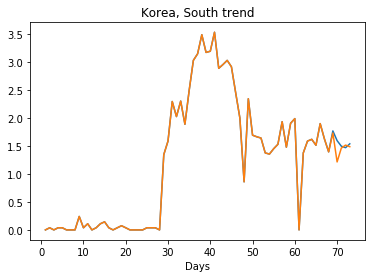

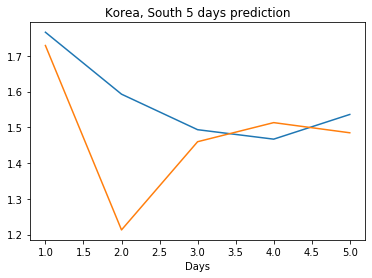

Creating directory ./offline7/Japan/training/
Japan
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3567
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3433
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3311
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3296
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3292
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3284
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3239
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3223
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3218
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3175
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3117
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [48], Best Valid

train error: 0.0702080819020538
0.2715955674648285
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3079
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2896
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2872
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2839
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2780
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2744
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2689
train error: 0.052549975360498616
0.26892200112342834
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4143
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4139
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3881
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3766
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3762
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3508
Saving 

Saving the best model weights at Epoch [5], Best Valid Loss: 0.4213
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4201
train error: 0.0716759572540851
0.42010924220085144
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2851
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2735
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2726
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2716
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2691
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2653
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2622
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2614
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2592
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2589
train error: 0.044471882602297945
0.2589026689529419
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4389
Saving

Saving the best model weights at Epoch [2], Best Valid Loss: 0.2651
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2617
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2543
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2493
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2461
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2443
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2427
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2395
train error: 0.06031999072844261
0.23954574763774872
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2989
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2772
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2735
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2615
train error: 0.07048189657201108
0.26147931814193726
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3187
Savin

Saving the best model weights at Epoch [5], Best Valid Loss: 0.4135
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4135
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4135
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4133
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4126
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4126
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4111
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4107
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4101
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4099
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4096
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4090
train error: 0.08377494352967724
0.4089841842651367
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [6], Best Valid Loss: 0.3400
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3338
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3286
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3244
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3210
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3181
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3157
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3138
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3121
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3107
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3095
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3087
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3078
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3072
Saving the best model weights at Epoch

Saving the best model weights at Epoch [40], Best Valid Loss: 0.3385
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3384
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3383
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3383
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3383
train error: 0.056864281307513774
0.33825698494911194
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3612
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3328
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3113
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2974
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2880
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2816
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2781
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2742
Saving the best model weights at Epoch [9], Best Valid Lo

Saving the best model weights at Epoch [22], Best Valid Loss: 0.3256
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3254
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3253
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3252
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3252
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3251
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3250
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3250
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3249
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3249
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3248
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3247
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3246
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3245
train error: 0.04533320175189721
0

Saving the best model weights at Epoch [12], Best Valid Loss: 0.3571
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3559
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3550
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3542
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3536
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3530
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3525
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3520
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3517
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3514
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3513
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3512
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3511
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3508
Saving the best model weights at E

Saving the best model weights at Epoch [10], Best Valid Loss: 0.3941
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3940
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3937
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3936
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3936
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3935
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3934
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3934
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3931
train error: 0.06538188587384004
0.3930959403514862
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3847
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3792
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3755
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3733
Saving the best model weights at Epoch [17], Best Valid

Saving the best model weights at Epoch [8], Best Valid Loss: 0.3300
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3283
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3281
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3268
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3264
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3262
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3261
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3260
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3256
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3254
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3253
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3251
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3250
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3248
train error: 0.04540260834619403
0.3

Saving the best model weights at Epoch [6], Best Valid Loss: 0.3491
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3468
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3447
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3428
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3413
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3401
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3393
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3384
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3376
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3371
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3366
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3362
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3359
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3358
Saving the best model weights at Epoch

Saving the best model weights at Epoch [6], Best Valid Loss: 0.3125
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3055
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2994
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2946
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2906
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2875
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2848
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2825
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2807
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2791
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2779
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2768
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2758
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2753
Saving the best model weights at Epoch

Saving the best model weights at Epoch [3], Best Valid Loss: 0.3955
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3855
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3776
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3711
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3659
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3616
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3581
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3530
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3512
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3484
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3473
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3463
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [11], Best Valid Loss: 0.4133
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4122
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4111
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4100
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4089
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4079
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4069
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4059
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4049
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4040
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4031
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4022
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4013
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4004
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.3155
train error: 0.04689151051111127
0.315477192401886
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4210
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4202
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4194
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4187
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4180
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4173
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4166
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4159
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4152
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4146
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4140
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4134
Saving the best model weights at Epoch [13], Best Valid Loss:

Saving the best model weights at Epoch [4], Best Valid Loss: 0.4323
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4303
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4284
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4266
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4247
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4229
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4212
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4195
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4178
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4146
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4130
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4115
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4100
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [26], Best Valid Loss: 0.2658
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2657
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2645
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2642
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2641
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2640
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2639
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2638
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2636
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2635
train error: 0.04245090060622284
0.2634528577327728
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4199
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4173
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4149
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [8], Best Valid Loss: 0.3970
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3945
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3919
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3901
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3895
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3874
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3860
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3851
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3846
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3830
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3830
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3821
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3817
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3813
Saving the best model weights at Epo

Saving the best model weights at Epoch [10], Best Valid Loss: 0.3892
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3880
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3869
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3858
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3847
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3837
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3827
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3816
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3807
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3797
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3788
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3778
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3769
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3760
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3703
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3664
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3628
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3593
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3527
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3468
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3440
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3412
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3387
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3361
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3338
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [48], Best Valid Loss: 0.3292
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3285
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3277
train error: 0.07185824563432681
0.3277287185192108
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4266
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4249
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4234
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4219
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4205
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4192
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4179
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4167
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4156
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4145
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [41], Best Valid Loss: 0.2803
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2794
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2778
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2770
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2763
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2756
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2748
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2742
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2737
train error: 0.060149028885031215
0.273714542388916
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3570
train error: 0.06782548163870447
0.3569824695587158
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3963
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3959
Sa

Saving the best model weights at Epoch [5], Best Valid Loss: 0.4204
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4198
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4192
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4187
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4181
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4176
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4171
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4167
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4158
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4154
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4149
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4145
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4142
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [25], Best Valid Loss: 0.2916
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2915
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2911
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2901
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2900
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2893
train error: 0.07007774097942993
0.2893168032169342
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4372
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4341
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4312
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4255
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4227
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4200
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [12], Best Valid Loss: 0.4240
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4235
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4231
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4228
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4226
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4225
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4220
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4219
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4218
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4215
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4213
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4213
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4212
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4212
train error: 0.08631049260791195
0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.3095
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2999
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2934
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2869
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2822
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2775
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2747
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2715
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2693
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2659
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2642
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2637
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2614
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2614
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [47], Best Valid Loss: 0.2598
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2591
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2584
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2577
train error: 0.03469320006153889
0.25772732496261597
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4462
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4438
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4424
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4409
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4401
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4398
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4390
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4387
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4385
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [47], Best Valid Loss: 0.3933
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3931
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3928
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3926
train error: 0.07608081230060443
0.39263689517974854
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4109
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4060
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4029
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4001
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3975
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3960
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3943
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3928
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3914
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [39], Best Valid Loss: 0.3741
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3735
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3729
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3724
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3719
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3715
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3710
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3705
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3701
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3697
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3693
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3689
train error: 0.055732549523542584
0.368897408246994
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4247
Saving the best model weights at Epoch [2], Best Val

Saving the best model weights at Epoch [32], Best Valid Loss: 0.2363
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2358
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2354
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2349
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2345
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2341
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2338
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2333
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2330
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2326
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2322
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2320
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2316
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2314
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.2645
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2636
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2628
train error: 0.03510242799836162
0.2628336250782013
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4256
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4122
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4023
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3881
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3833
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3786
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3754
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3735
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3711
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [37], Best Valid Loss: 0.3395
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3390
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3385
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3376
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3371
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3367
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3363
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3359
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3355
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3351
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3348
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3345
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3341
train error: 0.046198952734764466


Saving the best model weights at Epoch [24], Best Valid Loss: 0.3777
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3766
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3757
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3738
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3730
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3722
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3714
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3707
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3699
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3693
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3686
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3680
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3673
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.4142
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4138
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4133
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4130
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4127
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4123
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4118
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4115
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4112
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4108
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4105
train error: 0.07246549230215973
0.4104533791542053
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4199
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4198
Saving the best model weights at Epoch [3], Best Vali

Saving the best model weights at Epoch [7], Best Valid Loss: 0.3774
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3761
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3750
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3739
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3729
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3717
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3707
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3697
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3687
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3677
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3666
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3659
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3649
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3640
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.4134
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4131
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4128
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4125
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4122
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4119
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4116
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4113
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4110
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4107
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4105
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4102
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4099
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4096
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.3806
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3802
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3799
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3795
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3792
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3788
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3785
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3782
train error: 0.07181425456349787
0.37815412878990173
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4289
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4285
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4281
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4278
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4274
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [15], Best Valid Loss: 0.3849
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3846
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3844
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3841
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3838
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3836
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3833
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3830
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3828
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3825
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3822
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3820
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3817
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3815
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.3030
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3023
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3007
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2999
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2992
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2986
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2976
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2962
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2956
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2948
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2941
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2935
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3641
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3627
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3615
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3603
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3589
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3578
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3566
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3555
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3544
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3521
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3509
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3490
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [17], Best Valid Loss: 0.3534
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3511
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3488
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3466
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3445
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3423
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3402
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3383
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3362
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3345
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3324
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3305
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3288
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3269
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.4198
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4194
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4192
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4190
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4189
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4187
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4185
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4183
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4181
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4179
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4178
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4176
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4174
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3056
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3046
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3038
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3030
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3023
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3014
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3007
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2998
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2990
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2985
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2976
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2969
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2962
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2955
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.4187
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4182
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4178
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4173
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4169
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4164
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4160
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4155
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4151
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4147
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4142
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4138
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4133
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4129
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.4284
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4284
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4284
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4283
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4282
train error: 0.08412897285368097
0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.4152
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4149
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4147
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4144
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4142
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4139
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4137
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4134
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4132
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4130
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4127
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4125
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4122
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.3579
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3546
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3532
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3516
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3486
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3473
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3458
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3432
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3419
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3405
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3391
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.3925
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3924
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3922
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3920
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3919
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3917
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3915
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3914
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3912
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3910
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3909
train error: 0.06491954970222555
0.3908616602420807
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4203
train error: 0.07059570423964608
0.4203316867351532
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4003
S

Saving the best model weights at Epoch [6], Best Valid Loss: 0.3843
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3838
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3833
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3827
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3822
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3815
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3810
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3805
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3801
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3796
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3791
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3786
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3782
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3778
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.3617
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3614
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3610
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3606
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3602
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3599
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3595
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3591
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3587
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3583
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3580
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3576
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3573
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3569
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.4046
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4043
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4040
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4037
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4034
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4031
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4028
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4025
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4022
train error: 0.07757212044242279
0.4021991193294525
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4098
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4095
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4092
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4089
Saving the best model weights at Epoch [5], Best Valid 

Saving the best model weights at Epoch [9], Best Valid Loss: 0.4180
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4179
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4178
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4178
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4177
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4176
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4176
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4175
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4175
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4174
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4173
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4173
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4172
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4172
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.3830
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3830
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3829
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3829
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3828
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3828
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3827
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3827
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3826
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3826
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3825
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3824
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3824
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3823
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.3173
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3168
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3165
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3158
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3156
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3152
train error: 0.0709119516939513
0.3151586949825287
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4103
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4102
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4100
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4099
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4097
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4096
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4094
Saving the best model weights at Epoch [8], Best Valid Loss

Saving the best model weights at Epoch [12], Best Valid Loss: 0.4045
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4039
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4033
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4029
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4025
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4020
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4016
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4012
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4006
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4003
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3998
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3995
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3991
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3988
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.4032
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4028
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4024
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4021
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4017
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4014
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4010
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4007
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4003
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4000
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3996
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3993
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3989
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3986
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.3945
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3945
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3945
train error: 0.06341643524846356
0.394514799118042
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [15], Best Valid Loss: 0.4043
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4043
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4043
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4043
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4042
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4042
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4042
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4042
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4041
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4041
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4041
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4041
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4040
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4040
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4561
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4561
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.3448
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3446
train error: 0.07018945761343562
0.34457701444625854
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4311
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4310
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4310
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4310
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4310
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4309
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4309
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4309
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4309
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4309
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4308
Saving the best model weights at Epoch [12], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.4490
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4489
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4488
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4487
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4484
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4483
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4481
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4480
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4478
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4477
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4475
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4472
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.3796
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3796
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3795
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3795
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3795
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3795
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3795
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3795
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3794
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3794
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3794
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3794
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3794
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3794
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3951
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3951
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.4054
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4053
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4053
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4053
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4053
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4052
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4052
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4052
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4052
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4051
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4051
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4051
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4051
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4050
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [20], Best Valid Loss: 0.4398
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4397
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4397
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4397
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4396
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4396
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4396
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4395
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4395
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4395
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4395
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4394
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4394
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4394
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.4313
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4311
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4310
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4308
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4306
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4305
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4303
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4301
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4298
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4294
train error: 0.08703767187819865
0.42942485213279724
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2994
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [6], Best Valid Loss: 0.2953
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2952
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2952
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2951
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2950
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2950
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2949
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2948
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2948
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2947
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2946
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2946
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2945
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2944
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.3956
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3956
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3955
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3955
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3955
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3954
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3954
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3954
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3952
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3952
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.3808
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3808
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3808
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3808
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3807
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3807
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3807
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3807
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3806
train error: 0.07436993836400736
0.38062888383865356
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4442
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4442
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4442
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4442
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [9], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4444
Saving the best model weights at Ep

Saving the best model weights at Epoch [28], Best Valid Loss: 0.4369
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4368
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4367
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4366
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4365
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4362
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4361
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4360
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4359
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4358
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4357
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4356
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4355
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.4450
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4448
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4447
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4446
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4445
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4443
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4442
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4441
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4440
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4439
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4437
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4436
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4435
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4434
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.3771
train error: 0.07957641663961112
0.3771202564239502
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4333
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4331
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4329
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4326
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4324
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4321
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4319
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4316
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4314
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4311
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4309
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4307
Saving the best model weights at Epoch [13], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4381
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4381
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4381
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4381
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4381
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.4297
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4297
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4297
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4294
Saving the best model weights at E

train error: 0.08924701419585433
0.4553561210632324
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4297
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4297
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4295
Saving the best model weights at Epoch [14], Best Valid Loss

Saving the best model weights at Epoch [18], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4299
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4299
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.3999
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3998
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3997
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3996
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3995
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3994
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3993
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3992
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3991
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3989
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3989
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3987
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3986
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3985
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.4225
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4222
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4220
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4218
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4215
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4213
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4210
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4208
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4206
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4203
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4201
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4199
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4194
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.4469
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4469
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4469
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4468
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4468
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3454
train error: 0.06988801169944436
0.3453529477119446
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4304
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [15], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3879
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3879
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.3743
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3743
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3743
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3742
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3742
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.4502
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4502
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4502
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4502
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4500
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4500
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4500
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4345
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3015
train error: 0.046627966527778064


Saving the best model weights at Epoch [4], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4364
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4162
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4161
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4161
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.4246
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4246
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4245
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4245
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4245
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4244
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4244
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4244
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4243
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4243
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4243
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4242
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4242
train error: 0.08718967649129857
0.4242158532142639
Saving the best model weights at Epoch [1], Best Va

Saving the best model weights at Epoch [2], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3108
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3108
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3108
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3108
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3108
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3108
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [21], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3574
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3573
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3573
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.4197
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4197
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4197
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4196
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4195
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4195
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4195
train error: 0.08247142597591799
0.41951513290405273
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3904
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [6], Best Valid Loss: 0.4486
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4485
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4484
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4484
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4484
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4484
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4484
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4484
Saving the best model weights at Epoch

Saving the best model weights at Epoch [22], Best Valid Loss: 0.4102
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4101
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4101
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4101
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4100
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4100
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4100
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4099
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4099
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4099
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4099
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4098
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4098
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4098
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3747
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3746
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3746
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3746
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3746
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3746
train error: 0.07527061603277137
0.3746224343776703
Saving the best model weights at Epoch [1], Best Va

Saving the best model weights at Epoch [5], Best Valid Loss: 0.4059
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4059
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4059
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4059
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4059
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4059
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4058
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4120
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4120
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3990
train error: 0.08057216164582458
0.39897432923316956
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4246
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4246
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4246
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [7], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3640
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4474
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4474
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.3346
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3346
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3346
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3346
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3345
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3345
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3345
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3345
train error: 0.05737630084867736
0.33450692892074585
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3783
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3783
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3783
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3783
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3783
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [10], Best Valid Loss: 0.4107
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4107
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4107
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4107
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4107
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4106
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4106
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4525
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4525
Saving the best model weights at E

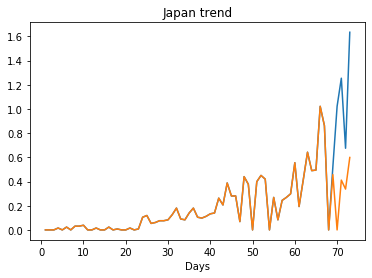

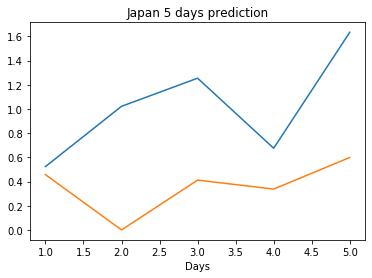

Creating directory ./offline7/Cambodia/training/
Cambodia
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0208
train error: 0.06859293654666875
0.020826442167162895
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0282
train error: 0.06475877717391333
0.028240246698260307
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0207
train error: 0.07842095232935566
0.0207186471670866
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0097
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0197
train error: 0.07081666422274077
0.019671374931931496
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0002
train error: 0.0718210200094759
0.00019283310393802822
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0239
train error: 0.07842095232935566
0.023852527141571045
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0187
Saving the best 

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0239
train error: 0.07842095232935566
0.023852527141571045
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0141
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0115
train error: 0.06821200895038518
0.011467192322015762
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0164
train error: 0.07364451733707084
0.016364237293601036
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0139
train error: 0.0784

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0043
train error: 0.062171751647397425
0.004272495862096548
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [12], Best Valid L

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0268
train error: 0.07539717152813506
0

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0110
train error: 0.07231833999905961
0.011029369197785854
Saving the best model weights at Epoch [1], Best 

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0113
train error: 0.06933332284009366
0.011311757378280163
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0240
train error: 0.07569213725880465
0.024027138948440552
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0149
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0122
train error: 0.07063140089369634
0.01220347173511982
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0133
Saving the best m

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0162
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0246
train error: 0.07245351729392441
0

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0181
train error: 0.07205839139748026
0.018115580081939697
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [4], Best Val

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0107
train error: 0.06710299395137664
0.010703164152801037
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [5], Best Vali

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0158
Saving the best model weights at E

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0067
Saving the best model weights at Epo

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0196
Saving the best model weights at Epo

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0163
train error: 0.07262075039783888
0.016262510791420937
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0079
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [10], Best Valid Lo

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0159
train error: 0.06941268895752728
0.01586359180510044
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0167
train error: 0.07539346625068874
0.01665167137980461
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0162
train error: 0.07536840025391994
0.016192032024264336
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0173
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [12], Best Valid Lo

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0196
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0173
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0149
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [16]

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0197
train error: 0.07220296403498981
0.019675707444548607
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0101
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0060
Saving the best model weights at Epoch [10], Best Valid Lo

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0193
train error: 0.0720761787855405
0.01926243305206299
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0346
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0291
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0261
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0120
Saving the best model weights at Epoch

train error: 0.07000706697616613
0.006488023791462183
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0152
train error: 0.07505359479480168
0.015173958614468575
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0267
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0264
Savin

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0189
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0209
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0116
train error: 0.07180053808472374
0.011644115671515465
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [10], Best Valid Lo

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0194
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0214
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0125
train error: 0.06674620804772007
0.012480984441936016
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0179
train error: 0.07295512726219992
0.017875755205750465
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0208
S

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0176
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0239
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0168
train error: 0.07030569894634413
0.016780754551291466
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [10], Best Valid Lo

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0174
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0174
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0173
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0173
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0172
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0168
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0197
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0080
train error: 0.06877858232650341
0.008006466552615166
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [13], Best Valid Lo

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0195
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0124
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0239
train error: 0.0737299303661778
0.023872874677181244
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [9], Best Valid Los

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0211
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0125
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0231
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0199
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0219
train error: 0.07115491007976799
0.02192286029458046
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0260
train error: 0.07561468982462291
0.026045754551887512
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0306
Savin

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0108
train error: 0.0693783153158923
0.010751431807875633
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0283
train error: 0.07567914176527693
0.0283056627959013

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0213
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0144
train error: 0.07124431520898009
0.014401364140212536
Saving the best model weights at Epoch [1], Best 

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0219
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0166
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0146
train error: 0.07402097918869306
0.014601156115531921
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0168
train error: 0.07330100104621978
0.016822556033730507
Saving the best model weights at Epoch [1], Best Valid Loss: 0.01

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0181
Saving the best model weights at Epoch

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0347
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0190
train error: 0.07583298401071013
0.018995096907019615
Saving the best model weights at Epoch [1], Best 

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0223
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0223
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0223
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0272
train error: 0.07450591026678342
0.02716692164540291
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0203
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0217
train error: 0.07398075267503207
0.021734243258833885
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [4], Best Val

In [ ]:
# optimization grid
lr_list = [0.1,0.01,0.001,1e-4,1e-5,1e-6]
hidden_lst = [1,2,3,4,5]
hState_lst = [10,30,50,100]
momentumS = [0.1,0.5,0.9]
tloss = []
ntloss = []

country_result = dict()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
best_error = 1e10
country_file_path = ("./country_file7.txt")
for i in range(len(countries)):
    if i in skip_countries:
        continue # too little data 
        
    country_result[countries[i]] = [] # store best validation parameter, test loss, test result
    best_error = 1e10
    
    best_param = [0,0,0]

    learning_rate = lr_list[0] # to be changed/optimized 
    hidden_dim = hidden_lst[0]
    hidden_state = hState_lst[0]
    
    
    model_name = countries[i]
    output_file_path = "./offline7/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    if not os.path.exists(directory):
        print("Creating directory %s" % output_file_path)
        os.makedirs(directory)
    else:
         print("Directory %s exists" % output_file_path)

    print(countries[i])
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[i]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[i]).unsqueeze_(1).float())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # load validation
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[i]).unsqueeze_(0).float())
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

    # load test
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[i]).unsqueeze_(0).float())
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    bestmodel = 0
    country_file = open(country_file_path,"a")
    # optimize (learning rate, hidden layer, hidden state, activation)
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                for s in range(len(momentumS)):
                # train
                # specific parameters
                    learning_rate = lr_list[j]
                    hidden_dim = hState_lst[m]
                    num_layers = hidden_lst[k]
                    momentum = momentumS[s]
                    #lstm_input_size = len()

                    net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
                    #print(net)
                    model = net.to(device)

                    #
                    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)
                    # to be changed/optimized 

                    model, err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim,num_layers,momentum)
                    print(err)
                    if err < best_error:
                        best_error = err
                        best_param = [lr_list[j],hidden_lst[k],hState_lst[m],momentum]
                        bestmodel = model
    
    country_result[countries[i]].append(best_param)
    
    # test data
    pred,final_loss = test_model(test_loader,bestmodel,device,criterion)
    print("test loss: ",final_loss)
    country_result[countries[i]].append([pred.tolist(),country_test_Y[i].tolist()])
    country_result[countries[i]].append(final_loss)
    torch.save(bestmodel.state_dict(), output_file_path+countries[i]+".th")
    
    tloss.append(final_loss)
    ntloss.append(final_loss/max(country_test_Y[i]))
    
    print("%s, %s, %s, %s" % (countries[i], pred.tolist(), final_loss,best_param), file=country_file)
                   
    country_file.close()
    graph_country(i,pred.tolist(),graph_dir)

In [ ]:
import json
with open("country_summary_7.js",'w+') as outfile:
    json.dump(country_result, outfile , sort_keys = True , indent = 4, separators = (",",": "))


In [ ]:
#country_test_Y[0]
sns.distplot(np.array(ntloss)); # normalized loss

In [ ]:
sns.distplot(np.array(tloss)); # not normalized loss